## The Matched Lattice
Knowing the RF cavities required to get to the necessary energies, and knowing the absorber lengths at each stage, the matched solenoids for each cells can be made, iterated via G4BL.

Step 1) Simulate a beam through one absorber, 40 T fields

Step 2) Acquire the momentum loss from the 1 sigma particles

Step 3) Generate matched solenoids from 4 T to 40 T to 4 T, considering the momentum loss from the absorber

Step 4) Simulate in G4BL the result from the matched solenoids

Step 5) Match solenoids between the RF cavities

Step 6) Simulate in G4BL the result from the matched cavities

Step 7) Correct the solenoids from the momentum increase in G4Beamline 

Step 8) Match the output with a field flip for the next cell

Repeat 10x

#### Preamble

In [1]:
# Packages
import numpy as np
import pandas as pd
import coolpy as cp
import matplotlib as mpl
import matplotlib.pyplot as plt
import subprocess
from py2g4bl_match_helpers import P, CellBeamGen, compute_emit_from_phasespace, readfile, E_to_dpp_to_dE, plot_solenoid

from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.integrate import solve_ivp

import matplotlib
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#ff3645","#bf3a68","#803e8b", "#4042ad","#0046d0"])
cmap_r = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#0046d0","#4042ad", "#803e8b","#bf3a68","#ff3645"])

from copy import deepcopy

In [2]:
# Global Parameters as defined by the genetic algorithm
Energies = [123.4874061 , 123.34209297, 100.41454084,  85.48562669,  74.47974494,  51.82242803,  32.01412767,  18.28142271, 17.9391355 ,  14.70422686]
AbsorberLengths = np.array([1.27736269, 1.32518469, 1.10521782, 1.13798138, 0.81575282, 0.43656683, 0.30241914, 0.10448507, 0.11920284, 0.09100977])
EnergySpreads = [5.41686927, 5.81701861, 5.25003438, 5.06819512, 5.65785391, 4.36047814, 2.39677483, 1.29680007, 1.25195259, 1.20749703]

Length_max = np.sum(AbsorberLengths)

In [3]:
# Target emittances as achieved by the simple G4BL setup
EmitT_Target = np.array([0.0002466918788431969,  0.0002026040562576625,  0.00016493170280864206,  0.00012640334072074876,  0.00010316360751668846,  8.722476322836085e-05,  6.031231528154821e-05,  4.5028352240203934e-05,  3.15684664407679e-05,  2.221710939561845e-05])
EmitL_Target = np.array([0.0018836404178010724,  0.0022763763903832462,  0.0028338086313568615,  0.003975051209763533,  0.005130191267191367,  0.006728425742772072,  0.011819326472499425,  0.020757848567312387,  0.03924855255649506,  0.07171590993046725])

In [111]:
m_mu = 0.105658375
ref_charge = 0.299792458
EmitL_Target = EmitL_Target * m_mu / ref_charge 

In [112]:
EmitL_Target*1E3

array([ 0.66386722,  0.80228246,  0.99874299,  1.4009607 ,  1.80807642,
        2.37135562,  4.16558454,  7.31586299, 13.83269717, 25.27544073])

In [4]:
EmitL_Target*1E3

array([ 1.88364042,  2.27637639,  2.83380863,  3.97505121,  5.13019127,
        6.72842574, 11.81932647, 20.75784857, 39.24855256, 71.71590993])

##### Define solenoid geometries

In [5]:
# Solenoid parameters
nSheet = 5
offset = 0.0

### Radius
L_radius_in  = 0.1 #[m] Low Field
L_radius_out = 0.3 #[m]
M_radius_in  = 0.1 # Matching field
M_radius_out = 0.3
H_radius_in  = 0.03 # High Field
H_radius_out = 0.09

Hcorr1_radius_out = 0.135 #outer most down and up stream correctors
Hcorr2_radius_out = 0.125 #middle  down and up stream correctors
Hcorr3_radius_out = 0.115 #inner most down and up stream correctors

### Length
L_Lsol = 1 #[m]
L_Lsol_short = 0.5 # 0.5
M_Lsol = 0.2
H_Lsol_list = [abslen + 2*0.12 for abslen in AbsorberLengths]
# Custom Lengths
#H_Lsol_list[7] += 0.5
#H_Lsol_list[8] += 0.5
#H_Lsol_list[9] += 0.5

Hcorr_Lsol = 0.012

#### Current density ####
L_current_density = 17.  #[A/mm^2]
H_current_density = 535.3 #A mm^-2
H2_current_density = -17 #A mm^-2
M_current_density = 50 #A mm^-2

NU_matchers = 4
ND_matchers = 10

L_Lgap = 0.4
L_Hgap = 0.1
L_MUgap = 0.1
L_MDgap = 0.25+0.1
L1_pos = 0 #[m]

Define solenoid positions

In [6]:
# Setting up first cell (unique)
MU_pos_arr = [(L_Lsol/2 + L_Lgap + L_MUgap*i + M_Lsol*i + M_Lsol/2) for i in range(NU_matchers)]
H1_pos = MU_pos_arr[-1] + M_Lsol/2 + L_Hgap + H_Lsol_list[0]/2 + Hcorr_Lsol*3

H_pos_arr = np.zeros(10)
H_pos_arr[0] = H1_pos

# Finds the high field solenoid and downstream matcher positions iteratively
MD_pos_arr_all = []
for ncell in range(1, 10):
    H_pos = H_pos_arr[ncell-1]
    if H_pos != 0:
        MD_pos_arr = [(H_pos + Hcorr_Lsol*3 + H_Lsol_list[ncell-1]/2 + L_Hgap + L_MDgap*i + M_Lsol*i + M_Lsol/2) for i in range(ND_matchers)]
    H_pos_new = MD_pos_arr[-1] + M_Lsol/2 + L_Hgap + H_Lsol_list[ncell]/2 + Hcorr_Lsol*3
    MD_pos_arr_all.append(np.array(MD_pos_arr))
    H_pos_arr[ncell] = H_pos_new
MD_pos_arr_all = np.array(MD_pos_arr_all)


L2_pos = H_pos_arr[-1]  + H_Lsol_list[-1]/2 + Hcorr_Lsol*3 + 4*M_Lsol + 3*L_MUgap + L_Hgap  + L_Lsol/2 + L_Lgap
MU2_pos_arr = [(L2_pos - L_Lsol/2 - L_Lgap - L_MUgap*i - M_Lsol*i - M_Lsol/2) for i in range(NU_matchers)]

In [7]:
MU2_pos_arr

[np.float64(61.185183050000035),
 np.float64(60.88518305000003),
 np.float64(60.58518305000003),
 np.float64(60.285183050000036)]

In [8]:
# Same but for the high-field correctors
Hcorr_rad_arr = [Hcorr1_radius_out, Hcorr2_radius_out, Hcorr3_radius_out]

HcorrU_pos_arr_all = []
HcorrD_pos_arr_all = []

for ncell in range(10):
    HcorrU_arr = [(H_pos_arr[ncell] - (H_Lsol_list[ncell]*0.5 + Hcorr_Lsol*(3-i)) + Hcorr_Lsol*0.5) for i in range(3)]
    HcorrD_arr = [(H_pos_arr[ncell] + (H_Lsol_list[ncell]*0.5 + Hcorr_Lsol*(3-i)) - Hcorr_Lsol*0.5) for i in range(3)]
    HcorrU_pos_arr_all.append(np.array(HcorrU_arr))
    HcorrD_pos_arr_all.append(np.array(HcorrD_arr))

Generate solenoid models with coolpy

In [9]:
fieldflip = np.tile([1, -1], 5)

In [10]:
# First Cell
L1 = cp.SolenoidSheet(current_density=L_current_density, radius_inner=L_radius_in, radius_outer=L_radius_out, rho=offset, L_sol=L_Lsol, nSheet=nSheet, position=L1_pos)
L2 = cp.SolenoidSheet(current_density=-L_current_density, radius_inner=L_radius_in, radius_outer=L_radius_out, rho=offset, L_sol=L_Lsol, nSheet=nSheet, position=L2_pos)
MU1_list = [cp.SolenoidSheet(current_density=M_current_density, radius_inner=M_radius_in, radius_outer=M_radius_out, rho=0.0, L_sol=M_Lsol, nSheet=nSheet, position=MU_pos_arr[m]) for m in [0, 2, 3]]
MU2_list = [cp.SolenoidSheet(current_density=M_current_density, radius_inner=M_radius_in, radius_outer=M_radius_out, rho=0.0, L_sol=M_Lsol, nSheet=nSheet, position=MU2_pos_arr[m]) for m in [0, 2, 3]]

# Matching solenoids
MD_solenoid_list = []
for ncell in range(9):
    for m in range(ND_matchers):
        MD_list = cp.SolenoidSheet(current_density=M_current_density, radius_inner=M_radius_in, radius_outer=M_radius_out, rho=0.0, L_sol=M_Lsol, nSheet=nSheet, position=MD_pos_arr_all[ncell][m])
        MD_solenoid_list.append(MD_list)


In [11]:
# High field solenoids and correctors
H_solenoid_list = [cp.SolenoidSheet(current_density=fieldflip[ncell]*H_current_density, radius_inner=H_radius_in, radius_outer=H_radius_out, rho=offset, L_sol=H_Lsol_list[ncell], nSheet=nSheet, position=H_pos_arr[ncell]) for ncell in range(10)]

HcorrU_solenoid_list = []
HcorrD_solenoid_list = []
for ncell in range(10):
    for corr in range(3):
        HcorrU = cp.SolenoidSheet(current_density=fieldflip[ncell]*H_current_density, radius_inner=H_radius_in, radius_outer=Hcorr_rad_arr[corr], rho=0.0, L_sol=Hcorr_Lsol, nSheet=nSheet, position=HcorrU_pos_arr_all[ncell][corr])
        HcorrD = cp.SolenoidSheet(current_density=fieldflip[ncell]*H_current_density, radius_inner=H_radius_in, radius_outer=Hcorr_rad_arr[corr], rho=0.0, L_sol=Hcorr_Lsol, nSheet=nSheet, position=HcorrD_pos_arr_all[ncell][corr])
        HcorrU_solenoid_list.append(HcorrU)
        HcorrD_solenoid_list.append(HcorrD)

Combine solenoid models to get analytical fields

In [12]:
def get_matching_solenoid_index(cell: int, offset: int) -> range:
    return range(10 * (cell - 1) + offset, 10 * cell + offset)

In [13]:
MU_optimized_params = [34.07907333777548, 3.3219755405093148, 51.652979865357764]

for m, matcher in enumerate(MU1_list):
    matcher.current_density = MU_optimized_params[m]

J_diff = 9.110632177470304 # p2_interp(MU1_list[0].position) / p2_interp(MU2_list[0].position), 
for m, matcher in enumerate(MU2_list):
    matcher.current_density = -MU_optimized_params[2-m] / J_diff
L2.current_density = -L_current_density /  9.110632177470304

#MD1_optimized_params = np.array([35.508740647947036, -7.775637580448505, -12.148933874280392, 1.1659173138855703, -14.173355652807334, 3.1998081438712456, 2.3815554497724882, -9.459754369901425, 24.349408687342134, -45.67855729411018])
#MD2_optimized_params = np.array([-28.31789277065613, -18.501887818005812, -1.8784318575656016, -0.7270962827746912, -18.06964647404582, -8.53553912519761, 0.0009505872611441622, 9.413088307598954, 20.368889231178734, 29.575276718397387])
#MD3_optimized_params = np.array([20.850624369473344, 12.413159406555176, -11.020477105084112, -4.4959745919857355, -1.2261645525741547, -7.944903700775784, -0.02232899339689541, 11.214227282445574, -15.610248028781658, -24.94776206574598])
#MD4_optimized_params = np.array([-30.10777573536053, 16.754070695307373, -11.847294928772918, 9.937535310012745, -7.382114373194557, 8.695539334740689, 13.679726322160738, 17.198860048441876, 18.27987415942097, 32.30642320204957])
#MD5_optimized_params = np.array([11.343974014339874, 12.336638733666955, -7.14255313126038, 0.765784357408995, -1.312317853070624, 7.019639246966744, 1.127414852195843, 11.369090082700511, -8.053117866227542, -21.067312426060433] )
#MD6_optimized_params = np.array([-21.49148506645938, -15.017781723049705, 14.406865606476686, 18.694530436181793, -16.102623903649572, -7.952328947438012, 12.561827306816, -8.000509582115589, 17.426440855050668, 27.430956877734616])
#MD7_optimized_params = np.array([29.792987462002387, -12.763595718600296, -28.990955354902574, 10.769888120436011, -6.448759848624242, -5.185552678204381, -14.743813821719531, 11.217477407701237, -9.595475068755617, -30.409549227155907])
#MD8_optimized_params = np.array([-22.053040769011826, -15.389054394144107, 13.418263668885078, 19.058865525103563, -14.513990372251277, -8.22610135643363, 11.561728700959243, -8.41556114530449, 18.02540058315934, 28.403136256583092])
#MD9_optimized_params = np.array([24.90996132453933, -10.12802897056051, -30.352135584470346, 8.86821549314558, -8.077319330293964, -6.019592753431176, -13.850729144435995, 15.243303750935036, -4.801301343959765, -31.23911694442866])

#MD1_optimized_params = [35.508740647947036, -7.775637580448505, -12.148933874280392, 1.1659173138855703, -14.173355652807334, 3.1998081438712456, 2.3815554497724882, -9.459754369901425, 24.349408687342134, -45.67855729411018]
#MD2_optimized_params = [-28.334138602427913, -18.431715440219733, -1.8529310774283174, -0.7396277735737722, -18.08609030347646, -8.54763195601096, 0.0009673962361045998, 9.52430341142502, 20.397960787679445, 29.556592977301975]
#MD3_optimized_params = [21.012621654497096, 12.244461370921899, -11.097449571960091, -4.5045177322268195, -1.2384944237811228, -8.106579877886627, -0.022295960992406223, 11.267593100105538, -15.663338462735148, -24.942415716187753]
#MD4_optimized_params = [-29.881346668714592, 16.744336886371848, -11.819662580805698, 9.950325737531157, -7.483195432733175, 8.724360618218066, 13.792092053439175, 17.363911559598638, 18.412403662763268, 32.41448982831251]
#MD5_optimized_params = [11.369558929743466, 12.310983999339264, -7.198581912134298, 0.7722998442491082, -1.3293470467535062, 7.025454878824878, 1.1407216424801891, 11.469503794614873, -7.918146505524364, -21.16029651285568]
#MD6_optimized_params = [-9.351199516185929, -8.265483470824226, -5.642855921818294, -1.6810582839808403, -0.10171718576806638, -0.7056563222222092, -3.4193851559764092, 6.131475790137806, 8.008457203287477, 9.299822544002978]
#MD7_optimized_params = [7.647602416613121, 4.3973410507563, -3.47664895621583, -3.23381354548873, 0.36024739488718593, 1.8285887361704665, 3.1151628772141673, 4.260515394876277, -5.064935915662694, -7.099356339291422]
#MD8_optimized_params = [-3.0, -3.0, -2.9097644512676304, -1.7544701789369905, -0.9130424166269479, 1.1217040669560694, 2.9999990742060376, 3.0, 3.0, 2.970215956564008]
#MD9_optimized_params = [1.0583103982607092, 1.0500455941704727, 1.9252227367437993, 1.4278263534742615, 1.945881674263419, 1.8739729691909845, 1.9480803385146983, -1.85545832857671, -1.635804923119968MD1_optimized_params = 7, -1.318972828853515]

In [55]:

MD1_optimized_params = [30.125066811956053, 4.0355430977380085, 8.518591646897644, 7.869896052767877, -7.424502408884381, 7.893244655364064, -8.869937412235945, -10.12121145021159, -5.043555958647721, -39.49891302335202]
MD2_optimized_params = [-28.99153790187729, -2.455150916981401, -8.44511341880514, -7.746422814716358, 7.411718980743935, -7.64282778711053, 8.2467560996944, 9.271931275920496, 2.776999380452089, 33.762506615871644]
MD3_optimized_params = [24.535090078312955, 2.162951894388427, 7.517152302671933, 6.893109197616641, -6.264313851992294, 6.530461862981002, -7.498042978012147, -8.515640021492915, -2.5468671267855787, -29.984316528127895]
MD4_optimized_params = [-19.01286106187003, -1.794425176489208, -6.062530023164502, -5.524840114230026, 5.113683130843557, -5.525924075431258, 6.404675600670917, 7.490931317008707, 2.351505802368655, 26.320629921705294]
MD5_optimized_params = [19.763354698926857, 1.735535421914831, 6.305679390092116, 5.4856240144833075, -4.963264759266727, 5.094699874661763, -5.767149802943776, -6.78550082491812, -1.9101210965004207, -22.23498494576598]
MD6_optimized_params = [-16.118188184928396, -6.589705232854463, -6.202220283916977, -5.262639343690967, 4.385060293356586, -4.370510765587717, 5.211032524968429, 6.1297337315243405, 6.493950393326015, 15.827272215806763]
MD7_optimized_params = [8.902619322306725, 4.4865104975287, 2.8502834813231313, 2.8580384421606873, -2.989740335078115, 3.11457276223633, -3.2346769274173397, -3.3332278215298308, -5.3954190405679245, -11.014005438858815]
MD8_optimized_params = [-7.9305836190274475, -4.28445550261257, -3.3076805077548013, -1.9141293936016524, 2.9501555035968208, -3.1449839872394993, 2.322571663919341, 4.144682937825561, 5.544410535778864, 10.6042808417015]
MD9_optimized_params = [7.574086468190269, 3.3954636576611423, 2.7469260699771016, 1.5635884913294291, -2.5027292037461235, 2.7422968300476556, -2.067153240769994, -3.7490144847608207, -4.767850886698832, -10.963444026598914]

MD1_optimized_params =  [29.111657748265788, 7.770668698322591, 2.0780735138438775, 10.49900954085786, -7.495575151591984, 7.95373971302427, -11.816292655746388, -2.4743724994023184, -9.754001590741128, -38.405798160744546]
MD2_optimized_params = [-28.75291932501496, -5.10160776559983, -10.18166836971315, -5.363069453702374, 7.639264017480231, -7.899052061165514, 5.739264071854043, 11.250204071335906, 5.818381929582298, 33.81469975810126]
MD3_optimized_params =  [21.90186401612319, 6.320592677788482, 12.009145546441621, -1.3421215151747294, -1.5780337875156931, 1.6424583889103515, 1.4509902530049335, -13.465906659415078, -7.342993609800253, -26.30828332018152]
MD4_optimized_params = [-15.431556230093507, -9.611600087960788, -0.8383559110788232, -7.075477675647452, 2.3981197230759586, -2.5745684617479547, 8.082573316056695, 1.014213731399288, 12.269454669895454, 20.704478284982653]
MD5_optimized_params =  [15.50829970461758, 9.913449024277261, 2.2073513529462976, 1.0747809258483876, -7.582640563326531, 7.746929031823667, -1.145990558767439, -2.407496936612131, -11.049148885114635, -17.641089016344765]
MD6_optimized_params = [-15.896704333473627, -9.654794824212937, -2.797751134653994, -2.2902786051365074, 7.590003301306175, -7.563888983408606, 2.266121493386907, 2.7683276213206307, 9.550587179682509, 15.71358487210756]
MD7_optimized_params =  [13.87171139351456, 7.74300996465068, 2.1430743564766717, 4.869856949198033, -4.7427501037346245, 4.904887103931407, -5.382408908897361, -2.4434130716369795, -9.084788356507474, -16.70032507115389]
MD8_optimized_params = [-12.815128360695166, -7.428042025371942, 1.5768619761417524, -5.752538447933559, 3.101508248837534, -3.2855480975916325, 6.847347726303871, -1.9935365097631788, 9.934117791205598, 18.06410815854812]
MD9_optimized_params =  [12.212406755168324, 5.817456777536307, 2.0353823431486724, 3.6849363005010187, -4.13445172574256, 4.243575812050509, -3.986262655911847, -2.318428015995362, -6.988528837636954, -14.244461777251574]

MD_current_densities = [MD1_optimized_params, MD2_optimized_params, MD3_optimized_params, MD4_optimized_params, MD5_optimized_params, MD6_optimized_params, MD7_optimized_params, MD8_optimized_params, MD9_optimized_params]

NCELL_RANGE = range(1,10)
for ncell in NCELL_RANGE:
    for m, matcher in enumerate(np.array(MD_solenoid_list)[get_matching_solenoid_index(ncell, 0)]):
        matcher.current_density = MD_current_densities[ncell-1][m]
        #matcher.current_density = (optimisation_map[ncell-1]['params'])[m]

In [56]:
import matplotlib.patches as patches

In [57]:
all_solenoid_dict = {}
all_solenoid_dict['L'] = [L1, L2]
all_solenoid_dict['MU'] = MU1_list + MU2_list
all_solenoid_dict['MD'] = MD_solenoid_list
all_solenoid_dict['H'] = H_solenoid_list
all_solenoid_dict['HU'] = HcorrU_solenoid_list
all_solenoid_dict['HD'] = HcorrD_solenoid_list

[(0.0, 62.185183050000035), (-0.5, 0.5)]

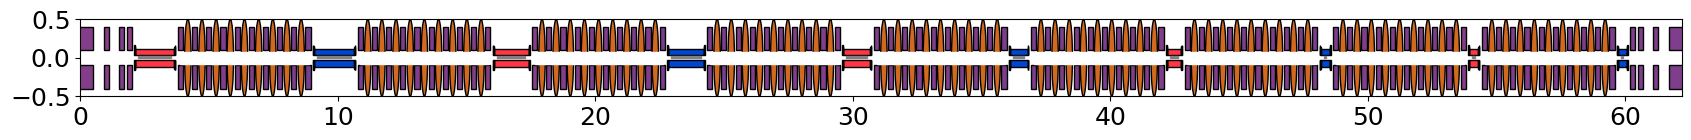

In [58]:
#Construct beamline
#sol_list = [L1, L2] + MU1_list + MU2_list + MD_solenoid_list + H_solenoid_list + HcorrU_solenoid_list + HcorrD_solenoid_list
# Gives a compressed list of solenoids from dictionary
sol_list = [item for key in all_solenoid_dict for item in all_solenoid_dict[key]]

mag_field = cp.MagneticField()
[mag_field.add_solenoid(solenoid) for solenoid in sol_list];

fig = plt.figure(figsize=(25,5))
gs = mpl.gridspec.GridSpec(3, 2, height_ratios=[0.5, 1, 1], width_ratios=[1, 0.1])
# Create axes
ax1 = fig.add_subplot(gs[0])
plt.subplots_adjust(hspace=0)

I_max = H_current_density

for solenoid in sol_list:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)
for s, solenoid in enumerate(MD_solenoid_list):
    if s%10 < 9:
        RF_cavity = patches.Ellipse((solenoid.position + 0.285,0), 0.25, 1, linewidth=1, edgecolor='k',facecolor='chocolate')
        ax1.add_patch(RF_cavity)
for i in range(0,10):
    absorber = patches.Rectangle((H_solenoid_list[i].position-AbsorberLengths[i]/2, 0), AbsorberLengths[i], 0.025, color='grey')
    ax1.add_patch(absorber)

for i in range(0,9):
    start_pos = MD_solenoid_list[i*10].position
    gap_length = 0.25*20
    gap_width = 0.15
    RF_gap = patches.Rectangle((start_pos, -gap_width/2), gap_length, gap_width, color='white')
    ax1.add_patch(RF_gap)

ax1.set(xlim=(0, L2.position), ylim=(-0.5, 0.5))

In [59]:
matplotlib.rcParams.update({'font.size': 18})

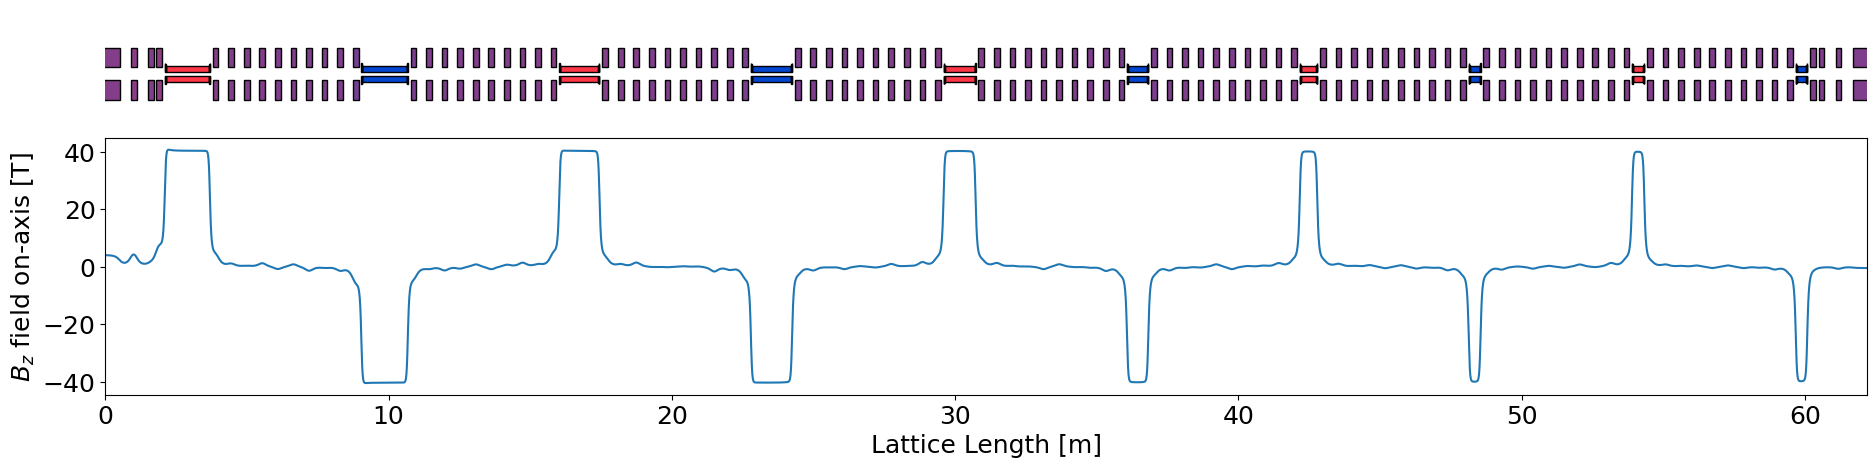

In [60]:
import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(25,5))
gs = mpl.gridspec.GridSpec(2, 2, height_ratios=[0.5, 1], width_ratios=[1, 0.0])
# Create axes
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
plt.subplots_adjust(hspace=0)

s = np.arange(0., L2_pos, 0.001)
B_superposed = mag_field.superposed_field_z(s)

I_max = H_current_density
max_S = L2_pos # max(s)
max_r = 1

for solenoid in sol_list:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])

# Set plot limits and labels
ax1.set(xlim=(0, max_S), ylim=(-1*max_r, max_r), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax2.plot(s, B_superposed)
ax2.set(ylabel=(r'$B_z$ field on-axis [T]'), xlabel="Lattice Length [m]", xlim=(0, max_S))

#for point in points:
#    ax3.plot(point, 0, 'bo')

ax1.set_axis_off()

#ax1.set_title('10 Cells: Solenoid Spacing & B-Fields')
plt.show()

In [61]:
EmitT_Target = np.array([0.0003, 0.0002466918788431969,  0.0002026040562576625,  0.00016493170280864206,  0.00012640334072074876,  0.00010316360751668846,  8.722476322836085e-05,  6.031231528154821e-05,  4.5028352240203934e-05,  3.15684664407679e-05,  2.221710939561845e-05])

#### Functions for calculating beta and for optimisations

In [62]:
def beta_system(s_, b, kappa_interp, L):
    b1, b2 = b
    db1ds = b2
    k_s = kappa_interp(s_)
    db2ds = (b2**2 + 4*(1 + L**2) - 4*b1**2 * k_s**2) / (2 * b1)
    return [db1ds, db2ds]

In [63]:
def interp_beta(s_, B_superposed, momentum):
    kappa = abs(cp.Gc_2 * B_superposed / momentum)
    kappa_interp = interp1d(s_, kappa, kind='linear', fill_value="extrapolate")
    b0 = [1/kappa_interp(0), 0.]
    L=0
    solution = solve_ivp(fun=beta_system, t_span=[s_[0], s_[-1]], t_eval=s_, y0=b0, args=(kappa_interp, L))
    #beta_interp = interp1d(s,  solution[:,0], kind='linear', fill_value="extrapolate")
    #betaP_interp = interp1d(s, solution[:,1], kind='linear', fill_value="extrapolate")
    return(solution.y[0],  solution.y[1], kappa)

In [64]:
def calc_beta_betap(mag_field_, s_, p1, p2, p3):
    #L = 0.
    B_superposed_ = mag_field_.superposed_field_z(s_)
    beta_interp1, betaP_interp1 = interp_beta(s_, B_superposed_, p1)
    beta_interp2, betaP_interp2 = interp_beta(s_, B_superposed_, p2)
    beta_interp3, betaP_interp3 = interp_beta(s_, B_superposed_, p3)
    return([beta_interp1, betaP_interp1], [beta_interp2, betaP_interp2], [beta_interp3, betaP_interp3], B_superposed_)

In [65]:
def objective_old(params, matching_index, MD_matchers_, s_, all_solenoids, p1_interp, p2_interp, p3_interp, points, weights=[1,0,1,100], extra_condition='None'):
    p1 = p1_interp(s_)
    p2 = p2_interp(s_)
    p3 = p3_interp(s_)

    w1, w2, w3, wp = weights

    npoints = len(points)

    magfields, b1, b1p, b2, b2p, b3, b3p, kappa = solve_ode(matching_index, MD_matchers_, params, [p1, p2, p3], p2_interp, s_, all_solenoids) #Calculates the beta and beta' for one momenta set 
    
    B_superposed = magfields.superposed_field_z(s_) # Gets the mag_field layout which has been updated from solve_ode
    B_interpol = cp.B_field_interpol(s_, B_superposed) # Gets the field just at s-points 
    #plt.plot(s_, B_superposed)
    #plt.plot(points, B_interpol(points))


    beta0_idal_1 = abs(p1_interp(points) / cp.Gc_2 / B_interpol(points)) # Calculates what the beta should be, considering the momentum and field
    b1_points = np.interp(points, s_, b1)
    err_b_1 = np.sum(abs(beta0_idal_1 - b1_points))/npoints # Error between what the beta should be, and what the magfield gives
    b1p_points = np.interp(points, s_, b1p)
    err_b_prime_1 = np.sum((abs(b1p_points) )**2)/npoints # There is no ideal beta_prime, so instead we consider difference from zero
    err1 = err_b_1 + wp*err_b_prime_1
    print('error 1=',err_b_1, wp*err_b_prime_1)

    beta0_idal_2 = abs(p2_interp(points) / cp.Gc_2 / B_interpol(points)) # Calculates what the beta should be, considering the momentum and field
    b2_points = np.interp(points, s_, b2)
    err_b_2 = np.sum(abs(beta0_idal_2 - b2_points))/npoints # Error between what the beta should be, and what the magfield gives
    b2p_points = np.interp(points, s_, b2p)
    err_b_prime_2 = np.sum((abs(b2p_points) )**2)/npoints # There is no ideal beta_prime, so instead we consider difference from zero
    err2 = err_b_2 + wp*err_b_prime_2

    beta0_idal_3 = abs(p3_interp(points) / cp.Gc_2 / B_interpol(points))# Calculates what the beta should be, considering the momentum and field
    b3_points = np.interp(points, s_, b3)
    err_b_3 = np.sum(abs(beta0_idal_3 - b3_points))/npoints # Error between what the beta should be, and what the magfield gives
    b3p_points = np.interp(points, s_, b3p)
    err_b_prime_3 = np.sum((abs(b3p_points) )**2)/npoints # There is no ideal beta_prime, so instead we consider difference from zero
    err3 = err_b_3 + wp*err_b_prime_3
    print("error 3=",err_b_3, wp*err_b_prime_3)

    err = w1*err1 + w2*err2 + w3*err3


    if extra_condition != 'None':
        MD_points = [matcher.position for matcher in np.array(MD_solenoid_list)[get_matching_solenoid_index(NCELL_MATCH,0)]]
        npoints_MD = len(MD_points)
        b1_extra_points = np.interp(MD_points, s_array, b1)
        b1_result = np.where(b1_extra_points < extra_condition, 0, b1_extra_points - extra_condition) #Adds an error if beta is greater than 2

        bp1_extra_points = np.interp(MD_points, s_array, b1p)
        bp1_result = abs(np.where(abs(bp1_extra_points) < extra_condition, 0, abs(b1_extra_points) - extra_condition)) #Adds an error if beta is greater than 2

        err_b1_extra = np.sum(b1_result) + np.sum(bp1_result) # Sum and divide

        b3_extra_points = np.interp(MD_points, s_array, b3)
        b3_result = np.where(b3_extra_points < extra_condition, 0, b3_extra_points - extra_condition) # Adds an error if beta is greater than 2

        bp3_extra_points = np.interp(MD_points, s_array, np.abs(b3p))
        bp3_result = abs(np.where(abs(bp3_extra_points) < extra_condition, 0, abs(b3_extra_points) - extra_condition)) #Adds an error if beta is greater than 2

        err_b3_extra = np.sum(b3_result) + np.sum(bp3_result) # Sum and divide
        
        err += err_b1_extra + err_b3_extra
    #print([matchers.current_density for matchers in np.array(MD_matchers_)[matching_index]])
    print(f"{params.tolist()}, {err}")

    return err

In [66]:
params = np.array([-200, -150, -100, 50, -25])

In [67]:
def solve_ode(matching_index, MD_matchers_, params, Momentum, MeanMomentum_interp, s_, all_solenoids):
    #L = 0
    params_ = np.r_[params, -params[::-1]]
    matcher_position = []
    for m, M in enumerate(matching_index): 
        matcher_position.append(MD_matchers_[M].position)
    momentum_per_matcher = MeanMomentum_interp(matcher_position)
    current_density_params = params_ * momentum_per_matcher

    for m, M in enumerate(matching_index):
        MD_matchers_[M].current_density = current_density_params[m]

    #print(params, params_, current_density_params)
    
    #Construct beamline
    sol_list_ = all_solenoids + MD_matchers_
    mag_field_ = cp.MagneticField()
    [mag_field_.add_solenoid(solenoid) for solenoid in sol_list_]

    B_superposed = mag_field_.superposed_field_z(s_)
    b1, b1_p = interp_beta(s_, B_superposed, Momentum[0])
    b2, b2_p = interp_beta(s_, B_superposed, Momentum[1])
    b3, b3_p = interp_beta(s_, B_superposed, Momentum[2])

    return mag_field_, b1, b1_p, b2, b2_p, b3, b3_p

In [68]:
def solve_ode(matching_index, MD_matchers_, params, Momentum, MeanMomentum_interp, s_, all_solenoids):
    #L = 0
    
    params_ = np.r_[params, -params[::-1]]
    matcher_position = []
    for m, M in enumerate(matching_index): 
        matcher_position.append(MD_matchers_[M].position)
    momentum_per_matcher = MeanMomentum_interp(matcher_position)
    current_density_params = params_ * momentum_per_matcher

    for m, M in enumerate(matching_index):
        print(m, current_density_params[m])
        MD_matchers_[M].current_density = current_density_params[m]

    #print(params, params_, current_density_params)
    
    #Construct beamline
    sol_list_ = all_solenoids + MD_matchers_
    mag_field_ = cp.MagneticField()
    [mag_field_.add_solenoid(solenoid) for solenoid in sol_list_]

    B_superposed = mag_field_.superposed_field_z(s_)
    b1, b1_p, kappa = interp_beta(s_, B_superposed, Momentum[0])
    b2, b2_p, k = interp_beta(s_, B_superposed, Momentum[1])
    b3, b3_p, k = interp_beta(s_, B_superposed, Momentum[2])

    return mag_field_, b1, b1_p, b2, b2_p, b3, b3_p, kappa

In [69]:
def objective(params, points, s_array_, all_solenoid_dict_, matched_solenoid, matched_indices, particles, mean_momentum, weights=[1,1,100], print_counter=100):
    '''
    Generalised objective function for matching N solenoids.
    params: list : set of effective current dentities to optimise 
    points: list : set of points to evaluate effectiveness
    '''
    objective.counter += 1 #count the number of iterations

    params_ = np.r_[params, -params[::-1]] #flip the params for symmetry
    npoints = len(points)
     
    #extracts the matched solenoid from the dictionary of solenoids
    matching_list = [all_solenoid_dict_[matched_solenoid][i] for i in matched_indices]
    for m, index in enumerate(matched_indices):
        momentum_per_matcher = mean_momentum[m]
        #Convert to current density
        current_density_params = params_[m] * momentum_per_matcher
        all_solenoid_dict_[matched_solenoid][index].current_density = current_density_params
    # converts dictionary of solenoids to list to feed to MagneticField
    all_solenoid_list = [item for key in all_solenoid_dict_ for item in all_solenoid_dict_[key]]
    mag_field_ = cp.MagneticField()
    [mag_field_.add_solenoid(solenoid) for solenoid in all_solenoid_list]
    Bz = mag_field_.superposed_field_z(s_array_)
    
    B_start  = Bz[0]
    B_points = np.interp(points, s_array_, Bz) #Evaluate Bz at target points
    inv_B_points = 1.0 / B_points
    inv_Gc2 = 1.0 / cp.Gc_2
    err = 0.0
    b1_arr = []
    b2_arr = []
    for p, part in enumerate(particles):
        momentum = part["p_pz"]
        p_points = part["p_points"]

        # initial beta from on-axis field
        kappa0 = abs(cp.Gc_2 * B_start / momentum[0])
        b0 = [1.0 / kappa0, 0.0]
        kappa = np.abs(cp.Gc_2 * Bz / momentum)
        sol = cp.solve_beta_rk4(s_array_, kappa, beta0=b0[0],betap0=b0[1],L=0.0)
        b1, b2 = sol[:, 0], sol[:, 1]
        b1_arr.append(b1), b2_arr.append(b2)

        # target beta at points
        beta0_ideal = abs(p_points * inv_Gc2 * inv_B_points) #Target Twiss beta
                                                             #Target Twiss beta' = 0 
        # interpolate solution to points
        b1_at_pts = np.interp(points, s_array_, b1) #Evaluate actual Twiss beta at target points
        b2_at_pts = np.interp(points, s_array_, b2) #Evaluate actual Twiss beta' at target points
    
        #plt.plot(beta0_ideal - b1_at_pts)
        #plt.show()


        # error contribution
        err_beta = np.sum(abs(beta0_ideal - b1_at_pts))/npoints
        err_betaprime = np.sum((abs(b2_at_pts)) ** 2) /npoints
        err += weights[p] * (err_beta  + weights[-1] * err_betaprime)

        #print(f"error {p+1}", err_beta, weights[-1] * err_betaprime)

    if objective.counter == 1: 
        print(f"{objective.counter}: {params.tolist()}, {err}")  #print the first error
        plt.plot(s_array_, b1_arr[0], color='blue')
        plt.plot(s_array_, b1_arr[1], color='green')
        plt.plot(s_array_, b2_arr[0], color='black')
        plt.plot(s_array_, b2_arr[1], color='grey')
        plt.show()
    if objective.counter % print_counter == 0: #!optional!
        print(f"{objective.counter}: {params.tolist()}, {err}")  #print J and error every 100th iteration 
        plt.plot(s_array_, b1_arr[0], color='blue')
        plt.plot(s_array_, b1_arr[1], color='green')
        plt.plot(s_array_, b2_arr[0], color='black')
        plt.plot(s_array_, b2_arr[1], color='grey')
        plt.show()
        
    return err

In [102]:
def compute_emit_from_phasespace(beam, sigmacut):
    m_mu = 0.105658375
    c= cp.c
    ref_charge = 0.299792458
    X, PX, Y, PY, T, PZ = beam['X'], beam['Px'], beam['Y'], beam['Py'], 1E9*beam['T'], beam['Pz']
    BZ = beam['Bz']
    E = (PZ*PZ + PY*PY + PX*PX + m_mu*m_mu)**0.5

    filt = True

    if filt:
        # Stack the variables for easier filtering
        data = np.stack([X, PX, Y, PY, T, E])
        # Calculate the mean and standard deviation of each variable
        means = np.mean(data, axis=1)
        stds = np.std(data, axis=1)
        # Identify high amplitude particles (above 5 sigma)
        sigma = sigmacut
        filtered_indices = np.all(np.abs(data - means[:, np.newaxis]) < sigma * stds[:, np.newaxis], axis=0)
        # Filter the data
        filtered_data = data[:, filtered_indices]
        
        # Compute the covariance matrix of the filtered data
        Cov = np.cov(filtered_data)
    else:
        Cov = np.cov([X,PX,Y,PY,T,E])

    Cov4D = Cov[0:4, 0:4]
    Covz = Cov[4:6, 4:6]
    
    emi4D_ = np.linalg.det(Cov4D)**0.25 / m_mu 
    emitZ = (np.linalg.det(Covz) )**(0.5) * c / cp.m_mu
    
    Pzaverage = np.mean(PZ)
    Bzaverage = np.mean(BZ)
    emi4D_geo = emi4D_ * m_mu / Pzaverage
    
    xpy = Cov[0][3]
    ypx = Cov[1][2]
    xx = Cov[0][0]
    yy = Cov[2][2]
    
    L_ = (Bzaverage*ref_charge*0.5*(xx + yy) - (ypx - xpy )) * 0.5 / m_mu / emi4D_
    
    try:
        Cov4D_inv = np.linalg.inv(Cov4D)
    except np.linalg.LinAlgError:
        print(filtered_data)
        return np.nan, np.nan, np.nan
    U = np.stack(filtered_data[:4], axis=1)
    A = np.einsum('ij,jk,ik->i', U , Cov4D_inv, U ) * emi4D_geo

    ampsq_sp = A
    #ampsq_sp = (term1 + term2 + term3 +term4)/m_mu

    CovL = np.cov([np.array(filtered_data[4]), np.array(filtered_data[5]), ampsq_sp])
    AAT = CovL[2,2]
    emiL_ = (np.linalg.det(CovL) )**(0.5) / (AAT**0.5)  #in units of MeV ns ?
    #emiL_ = (np.linalg.det(CovL) )**(0.5) / m_mu * ref_charge / (AAT**0.5)  #in units of mm MeV
    return emi4D_, emiL_, emitZ, L_


In [103]:
def compute_optics_from_phasespace(beam, sigmacut):
    m_mu = 0.105658375
    X, PX, Y, PY, T, PZ = beam['X'], beam['Px'], beam['Y'], beam['Py'], 1E9*beam['T'], beam['Pz']
    E = (PZ*PZ + PY*PY + PX*PX + m_mu*m_mu)**0.5

    filt = True

    if filt:
        # Stack the variables for easier filtering
        data = np.stack([X, PX, Y, PY, T, E])
        # Calculate the mean and standard deviation of each variable
        means = np.mean(data, axis=1)
        stds = np.std(data, axis=1)
        # Identify high amplitude particles (above 5 sigma)
        sigma = sigmacut
        filtered_indices = np.all(np.abs(data - means[:, np.newaxis]) < sigma * stds[:, np.newaxis], axis=0)
        # Filter the data
        filtered_data = data[:, filtered_indices]
        
        # Compute the covariance matrix of the filtered data
        Cov = np.cov(filtered_data)
    else:
        Cov = np.cov([X,PX,Y,PY,T,E])

    Cov4D = Cov[0:4, 0:4]
    Covx = Cov[0:2, 0:2]
    Covy = Cov[2:4, 2:4]

    emi4D_ = np.linalg.det(Cov4D)**0.25 / m_mu 

    Pzaverage = np.mean(PZ)
    emi4D_geo = emi4D_ * m_mu / Pzaverage

        #normalized emittances
    emi4D_ = np.linalg.det(Cov4D)**0.25 / m_mu 

    #geometrical emittances 
    emi4D_geo = emi4D_ * m_mu / Pzaverage

    beta_perp_ = (Covx[0][0] + Covy[0][0])*0.5/emi4D_geo
    alpha_perp_ = -(Covy[0][1]+Covx[0][1]) *0.5 / emi4D_geo

    return(beta_perp_, alpha_perp_)

#### G4Beamline setup

Definitions, absorbers and coils

In [194]:
setup = f'''
g4ui when=4 "/vis/viewer/set/background 1 1 1"
# param disable=Decay   #Whether muons decay
param stochastics=1
physics QGSP_BIC # disable=$disable
param cell_end={L2.position*1E3}
param zstep=50
'''

absorber_list = []
highcoil_list = []
for cellno in [0,1,2,3,4,5,6,7,8,9]:
    absorbers = f'''
tube abs{cellno} length={AbsorberLengths[cellno]*1E3} material=LH2 innerRadius=0 outerRadius=25 color=1,1,1,1
place abs{cellno} z={H_pos_arr[cellno]*1E3:.2f}'''
    absorber_list.append(absorbers)

for cellno in range(10):
    highcoils = f'''
coil H{cellno+1}_C innerRadius=30 outerRadius=90 length={H_solenoid_list[cellno].L_sol*1E3} nSheets=3 tolerance=1 maxZ=7000'''
    highcoil_list.append(highcoils)

coils = f'''
### Low Field
coil L1_C innerRadius=100 outerRadius=300 length={L1.L_sol*1E3} nSheets=3 tolerance=1 maxZ=7000

### High Field
coil Hcorr1_C innerRadius=30 outerRadius=135 length=12 nSheets=3 tolerance=1 maxZ=7000
coil Hcorr2_C innerRadius=30 outerRadius=125 length=12 nSheets=3 tolerance=1 maxZ=7000
coil Hcorr3_C innerRadius=30 outerRadius=115 length=12 nSheets=3 tolerance=1 maxZ=7000

# Matchers
coil M_C innerRadius=100 outerRadius={M_radius_out*1E3} length={M_Lsol*1E3} nSheets=10 tolerance=1 maxZ=7000
'''

low_solenoid = f'''
solenoid L1 coil=L1_C current=17.0 color=0.929,0.616,0.035,1
place L1 z=0
solenoid L2 coil=L1_C current={L2.current_density} color=0.929,0.616,0.035,1
place L2 z={L2.position*1E3}'''


High field solenoids and high field corrections

In [195]:
high_solenoids = []
for cellno, Hsol in enumerate(H_solenoid_list):
    if Hsol.current_density > 0:
           color='1,0,0,0.5'
    else:
           color='0,0,1,0.5'
    highsolenoid = f'''
solenoid H{cellno+1} coil=H{cellno+1}_C current={Hsol.current_density} color={color}
place H{cellno+1} z={Hsol.position*1E3}'''
    high_solenoids.append(highsolenoid)
    
HCorrU_solenoids = []
for u, hcorr in enumerate(HcorrU_solenoid_list):
        if hcorr.current_density > 0:
                color='1,0,0,0.5'
        else:
                color='0,0,1,0.5'
        HCU = f'''
solenoid H{u//3+1}corr{u%3+1}_U coil=Hcorr{u%3+1}_C current={hcorr.current_density} color={color}
place H{u//3+1}corr{u%3+1}_U z={hcorr.position*1E3}'''
        HCorrU_solenoids.append(HCU)
        
HCorrD_solenoids = []
for d, hcorr in enumerate(HcorrD_solenoid_list):
        if hcorr.current_density > 0:
                color='1,0,0,0.5'
        else:
                color='0,0,1,0.5'
        HCD = f'''
solenoid H{d//3+1}corr{d%3+1}_U coil=Hcorr{d%3+1}_C current={hcorr.current_density} color={color}
place H{d//3+1}corr{d%3+1}_U z={hcorr.position*1E3}'''
        HCorrD_solenoids.append(HCD)

Matching solenoids upstream and downstream/rf

In [196]:
MU_pos_arr = [1.0, 1.6, 1.9000000000000004]
MU_solenoids = []
for i in range(3):
    MU = f'''
solenoid MU1_{i+1} coil=M_C current={MU1_list[i].current_density} color=1,0,1,1
place MU1_{i+1} z={MU_pos_arr[i]*1E3}'''
    MU_solenoids.append(MU)

for i in range(3):
    MU = f'''
solenoid MU2_{i+1} coil=M_C current={MU2_list[i].current_density} color=1,0,1,1
place MU2_{i+1} z={MU2_list[i].position*1E3}'''
    MU_solenoids.append(MU)

MD_solenoids = []
for md, Matcher in enumerate(MD_solenoid_list):
    MD = f'''
solenoid MD{md//10+1}_{md%10+1} coil=M_C current={Matcher.current_density} color=1,0,1,1
place MD{md//10+1}_{md%10+1} z={Matcher.position*1E3}'''
    MD_solenoids.append(MD)


RF definitions

Single reference particle tracking

In [197]:
N = 1000

In [198]:
track_p0 = f'''
param ref_p={P((Energies[0])*1E6)*1E-6}

zntuple output file=2208_Ver0.00_MatchingCell10_p0.txt format=FOR009.DAT zloop=0:$cell_end:$zstep referenceParticle=1
reference particle=mu+ beamZ=0 referenceMomentum=$ref_p beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 noEfield=0 noEloss=0
beam ascii file=050625BeamInput_Reference.txt beamZ=0.0 beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 lastEvent={3} # user provided file with particle data
trackcuts keep=mu+
'''

track_p1 = f'''
param ref_p={P((Energies[0]-EnergySpreads[0]/2)*1E6)*1E-6}

zntuple output file=2208_Ver0.00_MatchingCell10_p1.txt format=FOR009.DAT zloop=0:$cell_end:$zstep referenceParticle=1
reference particle=mu+ beamZ=0 referenceMomentum=$ref_p beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 noEfield=0 noEloss=0
beam ascii file=050625BeamInput_10000_4.04124T.txt beamZ=0.0 beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 lastEvent={1} # user provided file with particle data
trackcuts keep=mu+
'''

track_p2 = f'''
param ref_p={P((Energies[0]+EnergySpreads[0]/2)*1E6)*1E-6}

zntuple output file=2208_Ver0.00_MatchingCell10_p2.txt format=FOR009.DAT zloop=0:$cell_end:$zstep referenceParticle=1
reference particle=mu+ beamZ=0 referenceMomentum=$ref_p beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 noEfield=0 noEloss=0
beam ascii file=050625BeamInput_10000_4.04124T.txt beamZ=0.0 beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 lastEvent={1} # user provided file with particle data
trackcuts keep=mu+
'''

track_all = f'''
param kinetic_energy={Energies[0]}
param ref_p={P(Energies[0]*1E6)*1E-6}

zntuple output file=2208_Ver0.00_MatchingCell10_{N}.txt format=FOR009.DAT zloop=0:$cell_end:$zstep referenceParticle=1
reference particle=mu+ beamZ=0 referenceMomentum=$ref_p beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 noEfield=0 noEloss=0
beam ascii file=050625BeamInput_10000_4.04124T.txt beamZ=0.0 beamX=0.0 beamY=0.0 beamXp=0.0 beamYp=0.0 lastEvent={N} # user provided file with particle data
trackcuts keep=mu+

'''

In [199]:
timeOffsetbool = False

In [200]:
# With timeOffset=0
                   #1   2      3    4     5    6   7    8   9
rf_rot_grad_arr = [19,  19,    19,  6,   20,  20, 30,  20, 18]
rf_grad_arr     = [33,  16,    18,  25,   8,  25, 4.5,  6, 6.5]  # To meet energy requirements
rf_grad_arr     = [30,  16,    20,  27,   7,  30, 3.25,  6, 6]  # Lower energy = better cooling
acc_freq_arr    = [1,    1,    1,   1,    1,  10, 1,    1,  1]
rot_freq_arr    = [50,  50,   50,  50,   20,  10, 5,    5,  3]
acc_phase_arr   = [90,  90,   90,  90,   90,  5,  90,  90, 90]
rot_phase_arr   = [0,   0,    0,    0,    0, 180, 0,    0,  0]
#
                   #1   2      3    4     5    6    7    8   9
rf_rot_grad_arr = [35,  25,    19,  15,   30,  40,  20,  25, 100]
rf_grad_arr     = [33,  16,    18,  25,   8,   30,  40,  6, 6.5]  # To meet energy requirements
rf_grad_arr     = [33,  18,    18,  25,   50,  30,  15,  12,  11]  # Lower energy = better cooling
acc_freq_arr    = [1,    1,    1,   1,    10,  10,  5,    5,  5]
rot_freq_arr    = [100,  50,   50,  50,   20,  10,  5,    5,  4]
acc_phase_arr   = [80,  80,   80,   70,   9,   0,   15,  30, 8]
rot_phase_arr   = [0,   0,    0,    0,   180, 180,  0,   0,  180]
no_rot_arr      = [4,   4,    4,    4,    3,   3,   3,   3,  1]

acc_rot_swap_cell = 4

rf_list = []
for rf, Matcher in enumerate(MD_solenoid_list):
    rf_no, cell_no = rf%10, rf//10

    if cell_no < acc_rot_swap_cell: #Rotation first, then acceleration
        if rf_no >= 9: #There is no 10th solenoid
            pass
        else:
            if timeOffsetbool == True:
                try:
                    timeOffset = timeOffset_dict[f'rf{cell_no+1}_{rf_no+1}']
                    timeOffset_str = f'timeOffset={timeOffset}'
                except:
                    timeOffset_str = ''
            elif timeOffsetbool == False:
                timeOffset_str = ''
            rf1_pos= Matcher.position+0.25+0.05/2
            if rf_no < no_rot_arr[cell_no]: #Rotational cavities
                RF = f'''
pillbox rf{cell_no+1}_{rf_no+1} innerLength=250  maxGradient={rf_rot_grad_arr[cell_no]} frequency={1E-3*rot_freq_arr[cell_no]} innerRadius=160 phaseAcc={rot_phase_arr[cell_no]} {timeOffset_str} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            if rf_no >= no_rot_arr[cell_no]:
                RF = f'''
pillbox rf{cell_no+1}_{rf_no+1} innerLength=250  maxGradient={rf_grad_arr[cell_no]} frequency={1E-3*acc_freq_arr[cell_no]} innerRadius=160 phaseAcc={acc_phase_arr[cell_no]} {timeOffset_str} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            rf_list.append(RF)
    elif cell_no >= acc_rot_swap_cell:
        if rf_no >= 9: #There is no 10th solenoid
            pass
        else:
            if timeOffsetbool == True:
                try:
                    timeOffset = timeOffset_dict[f'rf{cell_no+1}_{rf_no+1}']
                    timeOffset_str = f'timeOffset={timeOffset}'
                except:
                    timeOffset_str = ''
            elif timeOffsetbool == False:
                timeOffset_str = ''
            rf1_pos= Matcher.position+0.25+0.05/2
            if rf_no <no_rot_arr[cell_no]: #Rotational cavities
                RF = f'''
pillbox rf{cell_no+1}_{rf_no+1} innerLength=250  maxGradient={rf_rot_grad_arr[cell_no]} frequency={1E-3*rot_freq_arr[cell_no]} innerRadius=160 phaseAcc={rot_phase_arr[cell_no]} {timeOffset_str} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            if rf_no >=no_rot_arr[cell_no]:
                RF = f'''
pillbox rf{cell_no+1}_{rf_no+1} innerLength=250  maxGradient={rf_grad_arr[cell_no]} frequency={1E-3*acc_freq_arr[cell_no]} innerRadius=160 phaseAcc={acc_phase_arr[cell_no]} {timeOffset_str} win1Thick=0 win2Thick=0 color=1,0.5,0.5,1
place rf{cell_no+1}_{rf_no+1} z={rf1_pos*1E3}'''
            rf_list.append(RF)

Write and run g4bl file

In [201]:
with open(f'Cell10_Ver0.10_151225.g4bl', "w") as f:
        f.write('output g4bl_log.txt')
        f.write(setup)
        f.write(coils)
        f.write(low_solenoid)
        for cellno in range(len(absorber_list)):
                f.write(absorber_list[cellno])
        f.write('''
                ''')
        for cellno in range(10):
                f.write(highcoil_list[cellno])
        f.write('''
                ''')
        for cellno in range(10):
                f.write(high_solenoids[cellno])
        f.write('''
                ''')
        for hcorr in HCorrU_solenoids:
                f.write(hcorr)
        for hcorr in HCorrD_solenoids:
                f.write(hcorr)
        f.write('''
                ''')
        for MU in MU_solenoids:
                f.write(MU)
        f.write('''
                ''')
        for MD in MD_solenoids:
                f.write(MD)
        f.write('''
                ''')
        for rf in rf_list:
                f.write(rf)
        f.write('''
                ''')
        f.write(track_all)
        #f.write(track_p0)
        #f.write(track_p1)
        #f.write(track_p2)

subprocess.run([r"C:\Program Files\Muons, Inc\G4beamline\bin\g4bl.exe", f"Cell10_Ver0.10_151225.g4bl"])

CompletedProcess(args=['C:\\Program Files\\Muons, Inc\\G4beamline\\bin\\g4bl.exe', 'Cell10_Ver0.10_151225.g4bl'], returncode=0)

In [202]:
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_{N}.txt', 'for009')
sol_df = pd.DataFrame(track_dict)

In [203]:
sol_df[sol_df.Z == sol_df.Z.max()]

IEVT  IPNUM  IPTYP  IPFLG    JSRG             T         X  \
1170341     0.0    1.0    2.0    0.0  1244.0  3.263590e-07  0.000000   
1170342     3.0    0.0    2.0    0.0  1244.0  3.167700e-07 -0.001244   
1170343     4.0    0.0    2.0    0.0  1244.0  3.420370e-07 -0.001853   
1170344     5.0    0.0    2.0    0.0  1244.0  3.118760e-07 -0.000456   
1170345     7.0    0.0    2.0    0.0  1244.0  3.278030e-07 -0.014189   
...         ...    ...    ...    ...     ...           ...       ...   
1171001   995.0    0.0    2.0    0.0  1244.0  3.378310e-07  0.003448   
1171002   996.0    0.0    2.0    0.0  1244.0  3.646540e-07  0.008767   
1171003   998.0    0.0    2.0    0.0  1244.0  3.160340e-07  0.040966   
1171004   999.0    0.0    2.0    0.0  1244.0  3.330400e-07 -0.006559   
1171005  1000.0    0.0    2.0    0.0  1244.0  3.058590e-07  0.003398   

                Y      Z        Px  ...            By        Bz  Weight   Ex  \
1170341  0.000000  62.15  0.000000  ...  0.000000e+00 -0.445511     1.0  0.0   
1170342  0.005955  62.15  0.000093  ... -1.470420e-05 -0.445552     1.0  0.0   
1170343  0.000965  62.15 -0.000411  ... -2.384010e-06 -0.445525     1.0  0.0   
1170344  0.005777  62.15 -0.000326  ... -1.426460e-05 -0.445550     1.0  0.0   
1170345  0.008173  62.15  0.000828  ... -2.018050e-05 -0.445622     1.0  0.0   
...           ...    ...       ...  ...           ...       ...     ...  ...   
1171001  0.000154  62.15  0.000128  ... -3.802810e-07 -0.445534     1.0  0.0   
1171002  0.000036  62.15  0.003183  ... -8.942370e-08 -0.445570     1.0  0.0   
1171003  0.020320  62.15 -0.004417  ... -5.012930e-05 -0.445819     1.0  0.0   
1171004  0.009973  62.15 -0.000670  ... -2.462580e-05 -0.445592     1.0  0.0   
1171005 -0.003538  62.15  0.000306  ...  8.736970e-06 -0.445544     1.0  0.0   

          Ey   Ez  SARC  POLx  POLy  POLz  
1170341  0.0  0.0   0.0   0.0   0.0   0.0  
1170342  0.0  0.0   0.0   0.0   0.0   0.0  
1170343  0.0  0.0   0.0   0.0   0.0   0.0  
1170344  0.0  0.0   0.0   0.0   0.0   0.0  
1170345  0.0  0.0   0.0   0.0   0.0   0.0  
...      ...  ...   ...   ...   ...   ...  
1171001  0.0  0.0   0.0   0.0   0.0   0.0  
1171002  0.0  0.0   0.0   0.0   0.0   0.0  
1171003  0.0  0.0   0.0   0.0   0.0   0.0  
1171004  0.0  0.0   0.0   0.0   0.0   0.0  
1171005  0.0  0.0   0.0   0.0   0.0   0.0  

[665 rows x 23 columns]

In [182]:
sol_df[sol_df.Z == sol_df.Z.max()]

IEVT  IPNUM  IPTYP  IPFLG    JSRG             T         X  \
1219163     0.0    1.0    2.0    0.0  1244.0  3.263590e-07  0.000000   
1219164     1.0    0.0    2.0    0.0  1244.0  3.351040e-07 -0.004682   
1219165     2.0    0.0    2.0    0.0  1244.0  3.456360e-07 -0.050482   
1219166     3.0    0.0    2.0    0.0  1244.0  3.139280e-07 -0.003535   
1219167     4.0    0.0    2.0    0.0  1244.0  3.153360e-07 -0.001452   
...         ...    ...    ...    ...     ...           ...       ...   
1219921   995.0    0.0    2.0    0.0  1244.0  3.253210e-07 -0.002479   
1219922   996.0    0.0    2.0    0.0  1244.0  3.225190e-07 -0.002193   
1219923   998.0    0.0    2.0    0.0  1244.0  3.117340e-07 -0.000499   
1219924   999.0    0.0    2.0    0.0  1244.0  3.238050e-07 -0.001756   
1219925  1000.0    0.0    2.0    0.0  1244.0  3.184340e-07  0.019259   

                Y      Z        Px  ...            By        Bz  Weight   Ex  \
1219163  0.000000  62.15  0.000000  ...  0.000000e+00 -0.445511     1.0  0.0   
1219164 -0.003024  62.15  0.000685  ...  7.466190e-06 -0.445549     1.0  0.0   
1219165  0.011505  62.15  0.001436  ... -2.861230e-05 -0.445882     1.0  0.0   
1219166  0.009757  62.15  0.000721  ... -2.409280e-05 -0.445581     1.0  0.0   
1219167 -0.001914  62.15 -0.000454  ...  4.727090e-06 -0.445527     1.0  0.0   
...           ...    ...       ...  ...           ...       ...     ...  ...   
1219921  0.014890  62.15 -0.000722  ... -3.676880e-05 -0.445614     1.0  0.0   
1219922  0.000318  62.15 -0.000643  ... -7.848060e-07 -0.445526     1.0  0.0   
1219923 -0.027914  62.15  0.001956  ...  6.890700e-05 -0.445700     1.0  0.0   
1219924  0.013382  62.15 -0.000600  ... -3.304360e-05 -0.445603     1.0  0.0   
1219925 -0.003252  62.15 -0.000312  ...  8.029920e-06 -0.445643     1.0  0.0   

          Ey   Ez  SARC  POLx  POLy  POLz  
1219163  0.0  0.0   0.0   0.0   0.0   0.0  
1219164  0.0  0.0   0.0   0.0   0.0   0.0  
1219165  0.0  0.0   0.0   0.0   0.0   0.0  
1219166  0.0  0.0   0.0   0.0   0.0   0.0  
1219167  0.0  0.0   0.0   0.0   0.0   0.0  
...      ...  ...   ...   ...   ...   ...  
1219921  0.0  0.0   0.0   0.0   0.0   0.0  
1219922  0.0  0.0   0.0   0.0   0.0   0.0  
1219923  0.0  0.0   0.0   0.0   0.0   0.0  
1219924  0.0  0.0   0.0   0.0   0.0   0.0  
1219925  0.0  0.0   0.0   0.0   0.0   0.0  

[763 rows x 23 columns]

In [564]:
def extract_time_offsets(path):
    result = {}
    with open(path, "r") as f:
        for line in f:
            if line.startswith("pillbox"):
                parts = line.split()
                # parts[1] is like "rf1_1:"
                key = parts[1].rstrip(":")
                # find "timeOffset="
                for p in parts:
                    if p.startswith("timeOffset="):
                        value = float(p.split("=")[1])
                        result[key] = value
                        break
    return result

if timeOffsetbool == False:
    timeOffset_dict = extract_time_offsets('g4bl_log.txt')
    timeOffsetbool = True

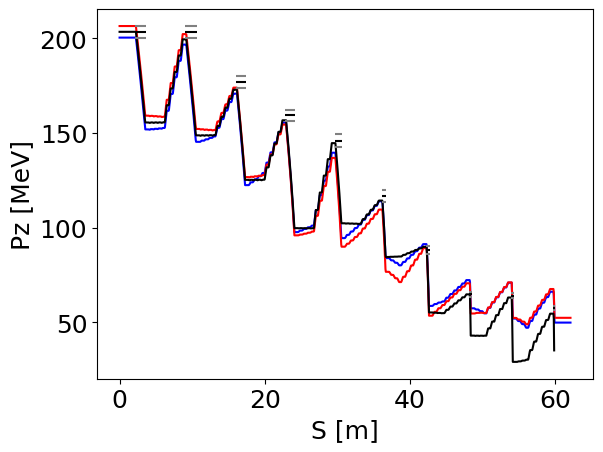

In [27]:
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_p1.txt', 'for009')
sol_df1 = pd.DataFrame(track_dict)
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_p2.txt', 'for009')
sol_df2 = pd.DataFrame(track_dict)
track_dict = readfile(f'2208_Ver0.00_MatchingCell10_p0.txt', 'for009')
sol_df0 = pd.DataFrame(track_dict)

plt.plot(sol_df1[sol_df1.IEVT==0].Z, sol_df1[sol_df1.IEVT==0].Pz*1E3, 'b', label=f'sigma -ve')
plt.plot(sol_df2[sol_df2.IEVT==0].Z, sol_df2[sol_df2.IEVT==0].Pz*1E3, 'r', label=f'sigma +ve')
plt.plot(sol_df0[sol_df0.IEVT==0].Z, sol_df0[sol_df0.IEVT==0].Pz*1E3, 'k', label=f'mean KE')

plt.ylabel('Pz [MeV]'), plt.xlabel('S [m]')

for i in range(10):
    plt.hlines(P((Energies[i]-EnergySpreads[i]/2)*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    plt.hlines(P((Energies[i]+EnergySpreads[i]/2)*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    plt.hlines(P(Energies[i]*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k')
plt.hlines(P(Energies[i]*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k', label='Energy Targets')
#plt.legend()


#plt.plot(sol_df1[sol_df1.IEVT==0].Z, 50 - sol_df1[sol_df1.IEVT==0].Pz*1E3 + sol_df2[sol_df2.IEVT==0].Pz*1E3, 'b', label=f'diff sigma')

In [28]:
pid1_PMev, pid2_PMev, pid3_PMev, s1_particle, s2_particle, s3_particle = sol_df1[sol_df1.IEVT==0].Pz*1E3, sol_df0[sol_df0.IEVT==0].Pz*1E3, sol_df2[sol_df2.IEVT==0].Pz*1E3, sol_df1[sol_df1.IEVT==0].Z, sol_df0[sol_df0.IEVT==0].Z, sol_df2[sol_df2.IEVT==0].Z
# With linear decrease
p1_interp = interp1d(s1_particle, 1E-3*pid1_PMev, kind='linear', fill_value="extrapolate")
p2_interp = interp1d(s2_particle, 1E-3*pid2_PMev, kind='linear', fill_value="extrapolate")
p3_interp = interp1d(s3_particle, 1E-3*pid3_PMev, kind='linear', fill_value="extrapolate")

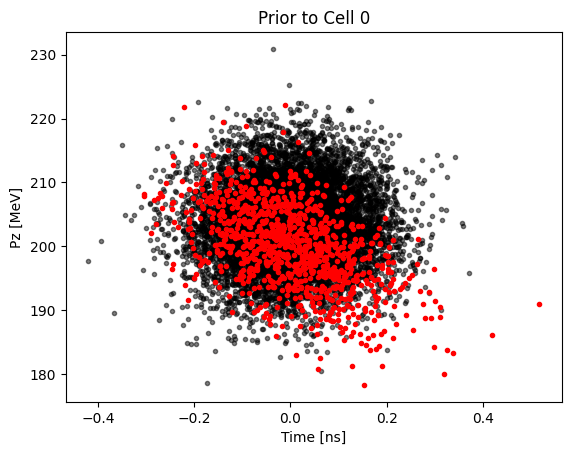

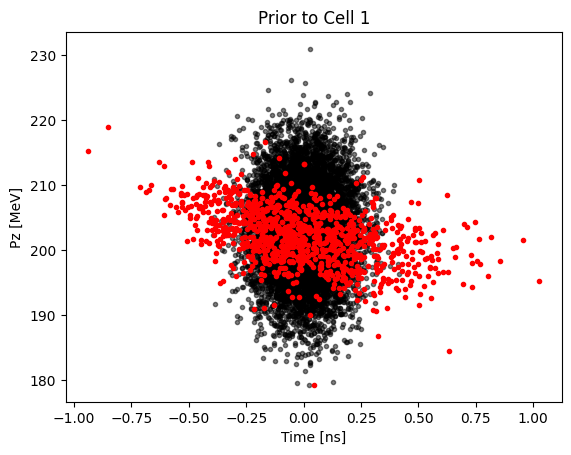

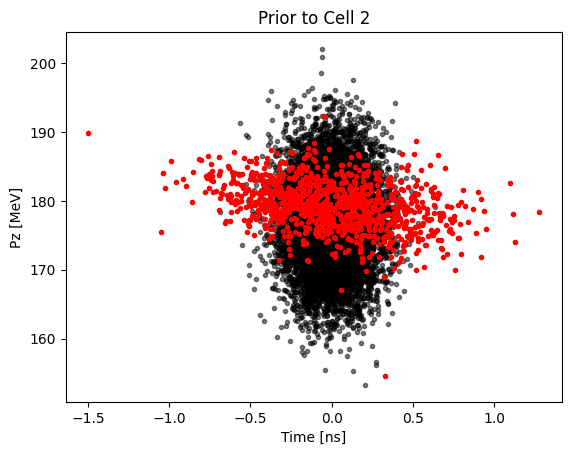

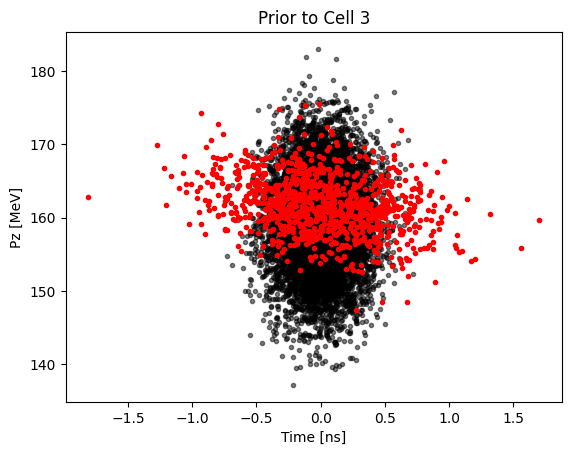

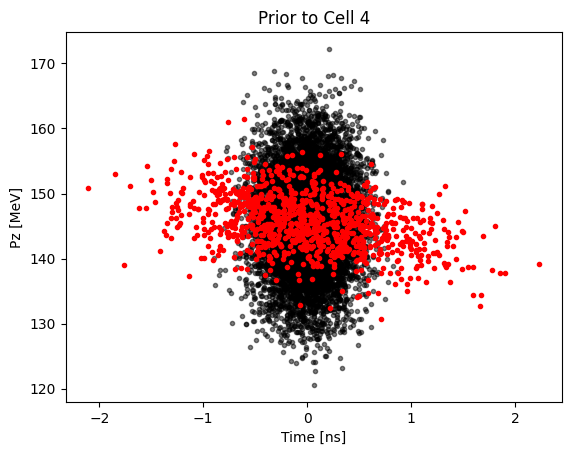

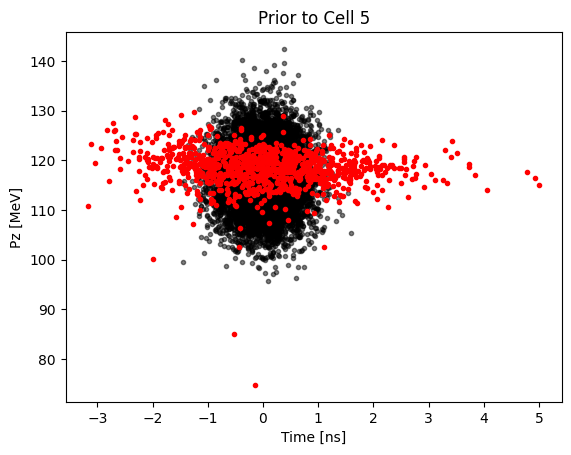

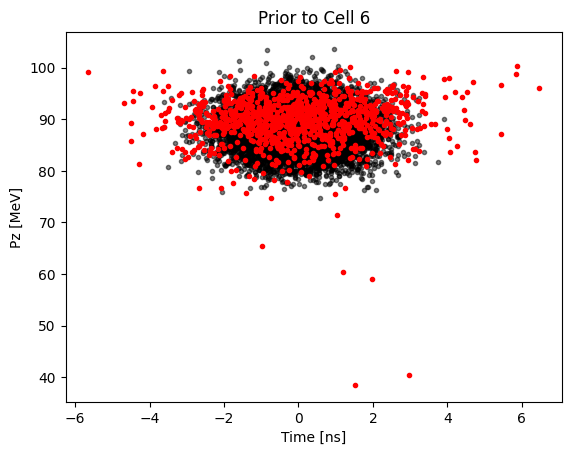

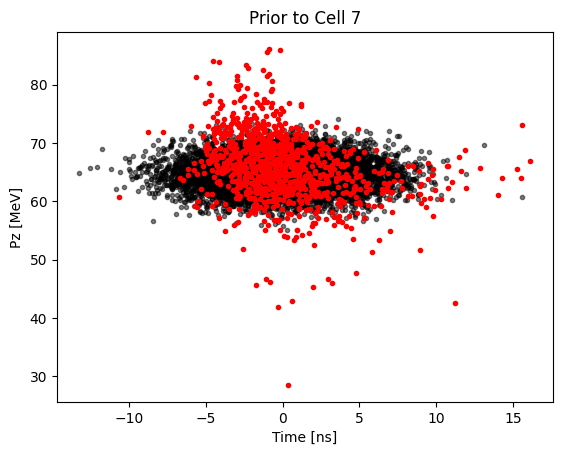

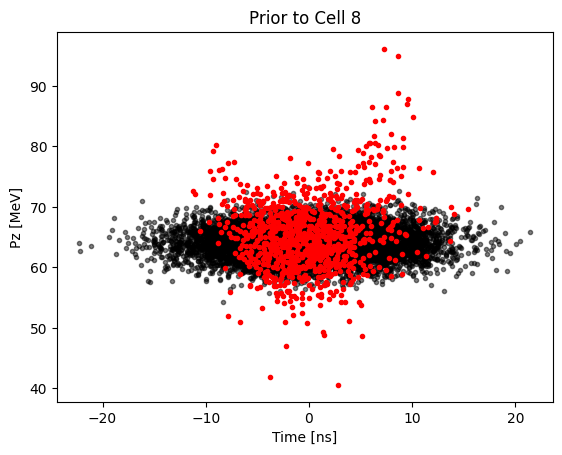

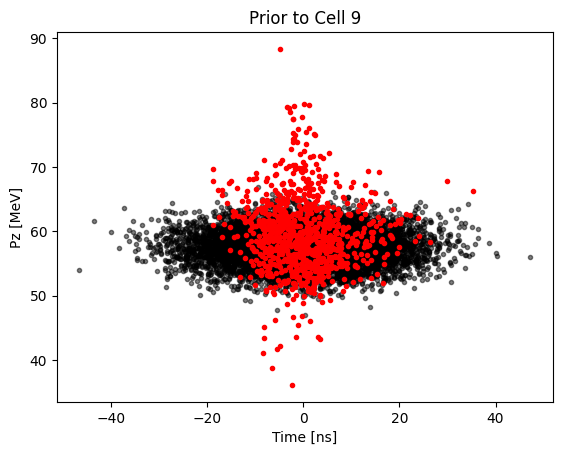

In [547]:
save_path = "../lattice_ga"

for i in range(10):
    Z_preabs = np.round(H_solenoid_list[i].position - AbsorberLengths[i]/2, 1)
    beam_dist = sol_df[sol_df.Z == Z_preabs]

    beam_dist_ideal = pd.read_csv(save_path+f"/220125BeamInput_10000_Cell{i+1}_of_10_GA_40T.txt", skiprows=2, usecols=[0,1,2,3,4,5,6], index_col=False, delimiter=' ', names=['x', 'y','z','Px','Py','Pz','t'])

    plt.plot(beam_dist_ideal['t'], beam_dist_ideal['Pz'], 'k.', alpha=0.5, label='Ideal beam')
    plt.plot((beam_dist['T']-beam_dist['T'].mean())*1E9, beam_dist['Pz']*1E3, 'r.', label='Start to end beam')
    plt.xlabel('Time [ns]'), plt.ylabel('Pz [MeV]'), plt.title(f'Prior to Cell {i}')
    plt.show()

(Text(0.5, 0, 'Time [ns]'), Text(0, 0.5, 'Momentum Pz [MeV]'))

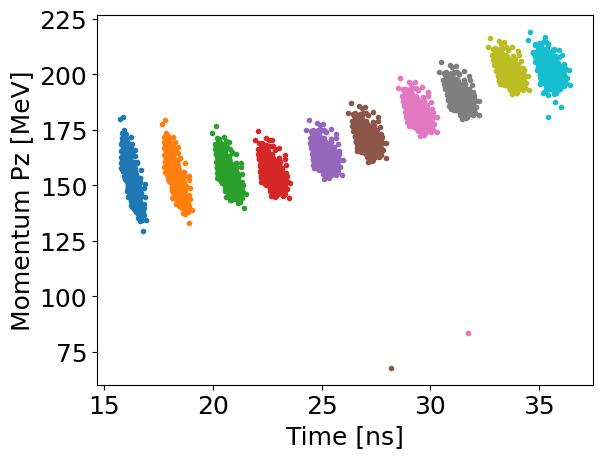

In [ ]:
for md_solenoid in MD_solenoid_list[0:10]:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')]*1E9, 1e3*sol_df['Pz'][sol_df.Z == float(f'{Z:.1f}')], '.')
plt.ylim(125,)
plt.xlabel('Time [ns]'), plt.ylabel('Momentum Pz [MeV]')

(Text(0.5, 0, 'Time [ns]'), Text(0, 0.5, 'Momentum Pz [MeV]'))

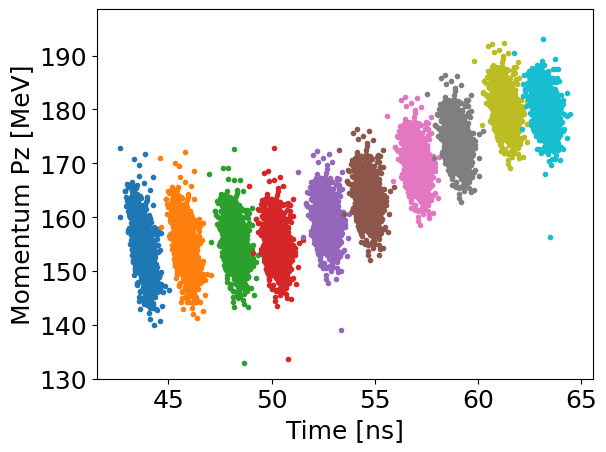

In [124]:
for md_solenoid in MD_solenoid_list[10:20]:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')]*1E9, 1e3*sol_df['Pz'][sol_df.Z == float(f'{Z:.1f}')], '.')
plt.ylim(130,)
plt.xlabel('Time [ns]'), plt.ylabel('Momentum Pz [MeV]')

(Text(0.5, 0, 'Time [ns]'), Text(0, 0.5, 'Momentum Pz [MeV]'))

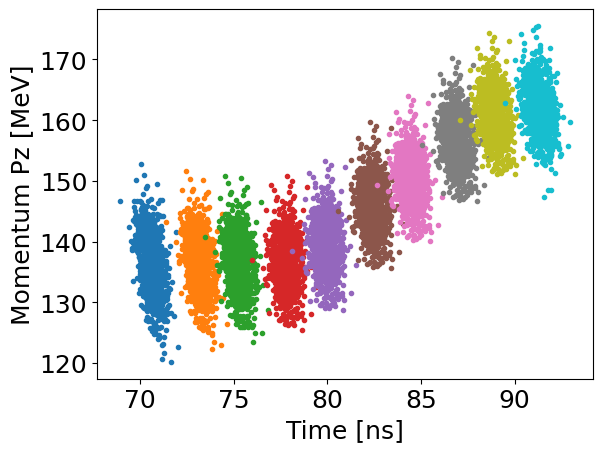

In [132]:
for md_solenoid in MD_solenoid_list[20:30]:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')]*1E9, 1e3*sol_df['Pz'][sol_df.Z == float(f'{Z:.1f}')], '.')
plt.xlabel('Time [ns]'), plt.ylabel('Momentum Pz [MeV]')

(Text(0.5, 0, 'Time [ns]'), Text(0, 0.5, 'Momentum Pz [MeV]'))

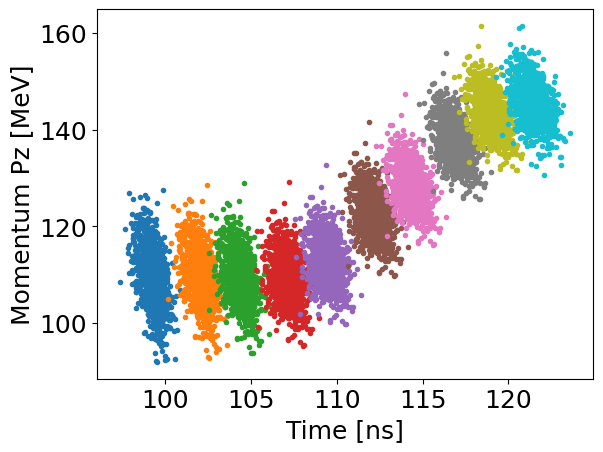

In [151]:
for md_solenoid in MD_solenoid_list[30:40]:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')]*1E9, 1e3*sol_df['Pz'][sol_df.Z == float(f'{Z:.1f}')], '.')
plt.xlabel('Time [ns]'), plt.ylabel('Momentum Pz [MeV]')

(Text(0.5, 0, 'Time [ns]'), Text(0, 0.5, 'Momentum Pz [MeV]'))

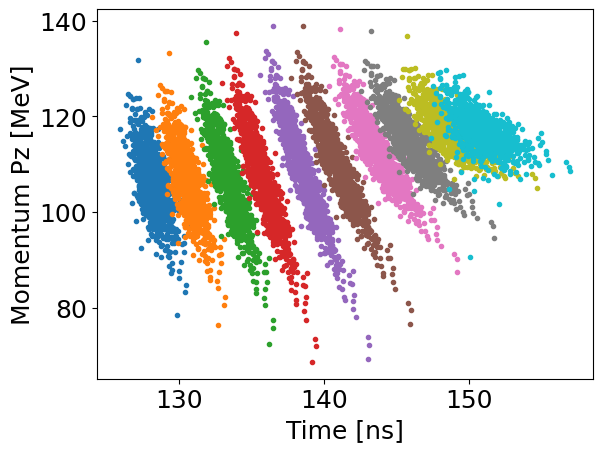

In [158]:
for md_solenoid in MD_solenoid_list[40:50]:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')]*1E9, 1e3*sol_df['Pz'][sol_df.Z == float(f'{Z:.1f}')], '.')


plt.xlabel('Time [ns]'), plt.ylabel('Momentum Pz [MeV]')

(Text(0.5, 0, 'Time [ns]'), Text(0, 0.5, 'Momentum Pz [MeV]'))

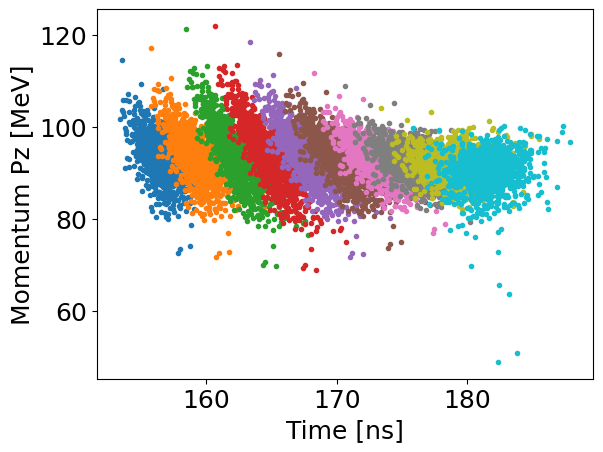

In [172]:
for md_solenoid in MD_solenoid_list[50:60]:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')]*1E9, 1e3*sol_df['Pz'] [sol_df.Z == float(f'{Z:.1f}')], '.')


plt.xlabel('Time [ns]'), plt.ylabel('Momentum Pz [MeV]')

(Text(0.5, 0, 'Time [ns]'), Text(0, 0.5, 'Momentum Pz [MeV]'))

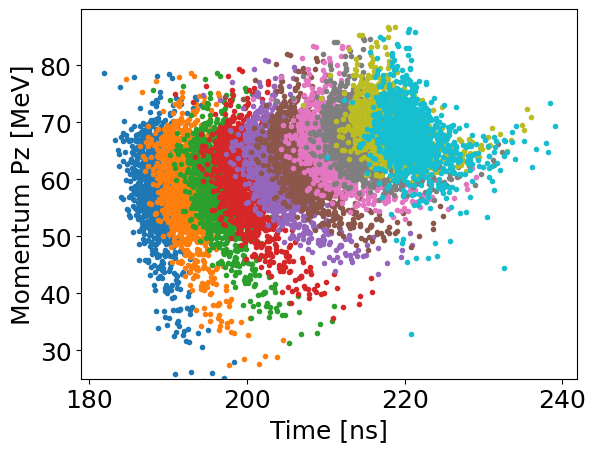

In [373]:
for md_solenoid in MD_solenoid_list[60:70]:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')]*1E9, 1e3*sol_df['Pz'] [sol_df.Z == float(f'{Z:.1f}')], '.')
plt.ylim(25,)

plt.xlabel('Time [ns]'), plt.ylabel('Momentum Pz [MeV]')

(Text(0.5, 0, 'Time [ns]'), Text(0, 0.5, 'Momentum Pz [MeV]'))

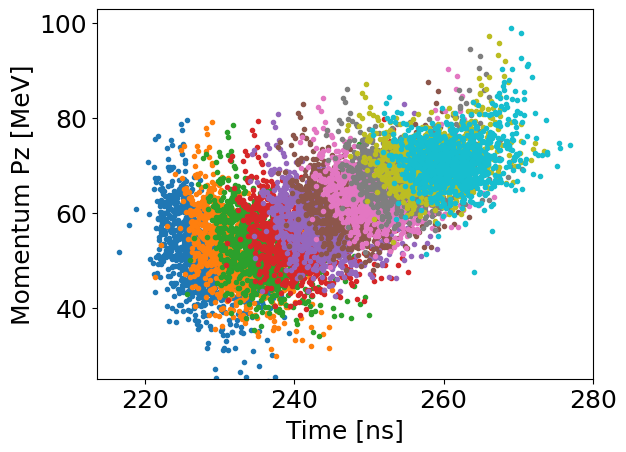

In [393]:
for md_solenoid in MD_solenoid_list[70:80]:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')]*1E9, 1e3*sol_df['Pz'] [sol_df.Z == float(f'{Z:.1f}')], '.')
plt.ylim(25,)

plt.xlabel('Time [ns]'), plt.ylabel('Momentum Pz [MeV]')

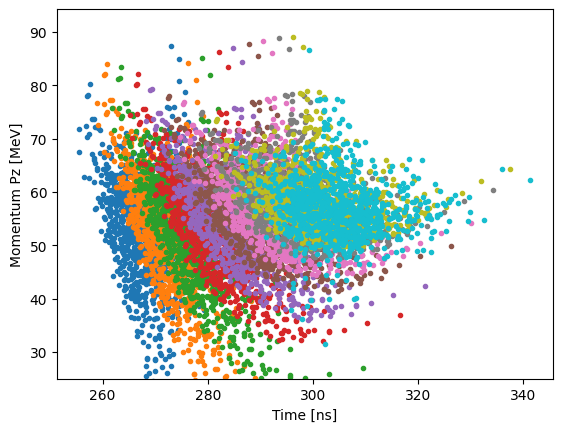

In [542]:
for md_solenoid in MD_solenoid_list[80:90]:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')]*1E9, 1e3*sol_df['Pz'] [sol_df.Z == float(f'{Z:.1f}')], '.')
plt.ylim(25,)

plt.xlabel('Time [ns]'), plt.ylabel('Momentum Pz [MeV]')
plt.show()

(Text(0.5, 0, 'Time [ns]'), Text(0, 0.5, 'Momentum Pz [MeV]'))

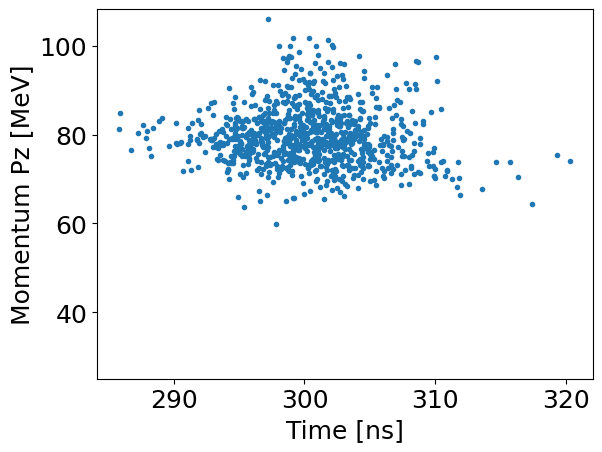

In [387]:
for md_solenoid in MD_solenoid_list[89:90]:
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')]*1E9, 1e3*sol_df['Pz'] [sol_df.Z == float(f'{Z:.1f}')], '.')
plt.ylim(25,)

plt.xlabel('Time [ns]'), plt.ylabel('Momentum Pz [MeV]')

(Text(0.5, 0, 'Time [ns]'), Text(0, 0.5, 'Momentum Pz [MeV]'))

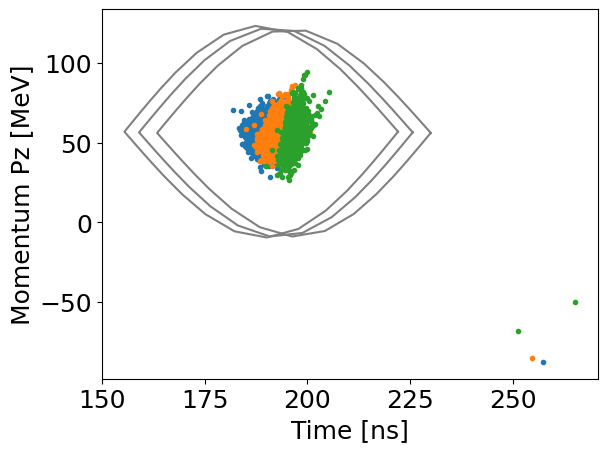

In [287]:
cellno = 6
for m, md_solenoid in enumerate(MD_solenoid_list[(cellno)*10:(cellno+1)*10-7]):
    Z = md_solenoid.position+0.25+0.05/2
    plt.plot(sol_df['T'][sol_df.Z == float(f'{Z:.1f}')]*1E9, 1e3*sol_df['Pz'] [sol_df.Z == float(f'{Z:.1f}')], '.')

    t_mean = sol_df['T'][sol_df.Z == float(f'{Z:.1f}')].mean() * 1E9
    Pz_mean = sol_df['Pz'][sol_df.Z == float(f'{Z:.1f}')].mean() * 1E3

    f_RF = 15 * 1e+6
    field, w_RF = rf_rot_grad_arr[cellno] * 1e6, 2 * pi * f_RF
    psi0 = rot_phase_arr[cellno] * pi
    W_Pz = Pz_mean
    W_kin = (np.sqrt((W_Pz)**2 + 105.65**2) - 105.65) *1E6 # 50 * 1e6 #eV
    gap, drift = 0.25 , 0.25+0.1
    psi_spx, dW_spx = cp.Separatrix(W_kin, field, w_RF, psi0, gap, drift)

    dt = psi_spx / w_RF
    plt.plot(dt * 1e9 +t_mean , (dW_spx * 1e-6) + Pz_mean, color='grey')

plt.xlabel('Time [ns]'), plt.ylabel('Momentum Pz [MeV]')

In [263]:
rot_freq_arr[cellno] 

10

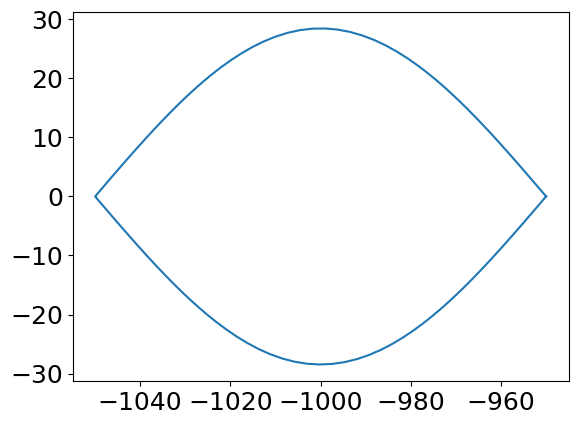

In [ ]:
f_RF = acc_freq_arr[cellno] * 1e+6
field, w_RF = rf_grad_arr[cellno] * 1e6, 2 * pi * f_RF
psi0 = acc_phase_arr[cellno] * pi
W_Pz = sol_df['Pz'][sol_df.Z == float(f'{Z:.1f}')].mean()
W_kin = (np.sqrt((W_Pz*1E3)**2 + 105.65**2) - 105.65) *1E6 # 50 * 1e6 #eV
gap, drift = 0.25 , 0.25
psi_spx, dW_spx = cp.Separatrix(W_kin, field, w_RF, psi0, gap, drift)

dt = psi_spx / w_RF
plt.plot(dt * 1e9 ,dW_spx * 1e-6)

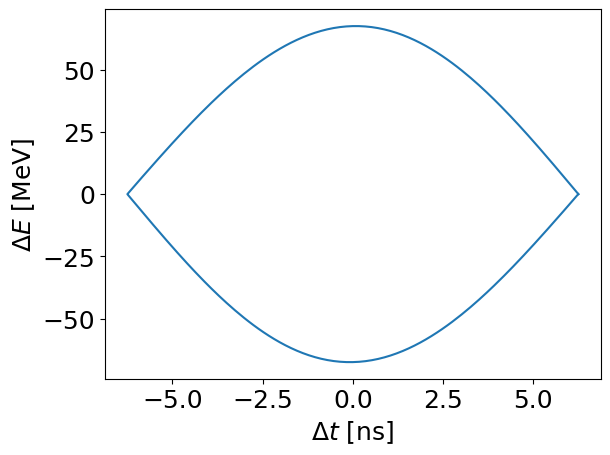

In [ ]:

pi = cp.pi
m_mu = cp.m_mu
c = cp.c

f_RF = 80. * 1e+6
#RF field strength in [V/m], RF frequency in [1/s] (not in Hz!)
field, w_RF = 15. * 1e6, 2 * pi * f_RF
#reference phase
psi0 = 0. * pi
#kinetic energy of the reference particle
W_kin = 50 * 1e6 #eVpsi_spx, dW_spx = cp.Separatrix(W_kin, field, w_RF, psi0, gap, drift)
g = plt.plot(psi_spx, dW_spx * 1e-6, 'w')    #plot separatrix


dt = psi_spx / w_RF
plt.plot(dt * 1e9 ,dW_spx * 1e-6)
#Cavity length, drift length in [m]
gap, drift = 0.1 , 0.005


plt.ylabel(r'$\Delta E$ [MeV]')
plt.xlabel(r'$\Delta t$ [ns]')
plt.show()


In [41]:
from tqdm.notebook import tqdm

In [204]:
Ez_arr = []
dEz_arr = []
dpp_arr = []
pz_arr = []
dpz_arr = []
Transmission = []
Z_unique = sol_df.Z.unique()

for Zend in tqdm(sol_df.Z.unique()):
    pz_dist = np.array(sol_df['Pz'][(sol_df.Z == Zend)])*1E3
    Ez_dist = np.sqrt(pz_dist**2 + 105.65**2) - 105.65
    
    Ez_arr.append(np.mean(Ez_dist))
    dEz_arr.append(np.std(Ez_dist))
    dpp_arr.append(np.std(pz_dist)/np.mean(pz_dist))

    pz_arr.append(np.mean(pz_dist))
    dpz_arr.append(np.std(pz_dist))
    
    No_particles = len(sol_df['IEVT'][(sol_df.Z == Zend)].unique())
    Transmission.append(No_particles)

Ez_arr, dEz_arr = np.array(Ez_arr), np.array(dEz_arr)
pz_arr, dpz_arr = np.array(pz_arr), np.array(dpz_arr)

  0%|          | 0/1244 [00:00<?, ?it/s]

(Text(0.5, 0, 'Z [m]'), Text(0, 0.5, 'Beam Momentum $P_z$ [MeV]'))

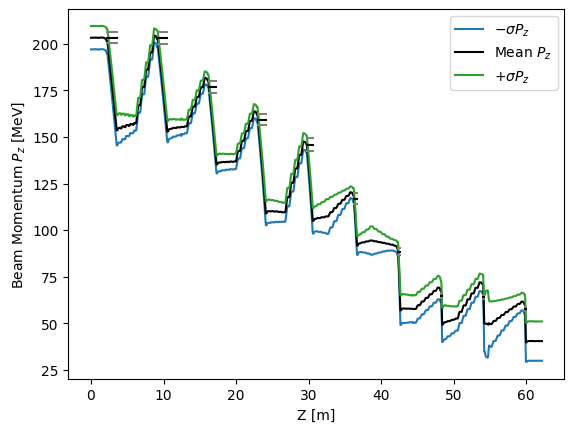

In [184]:

p1_interp = interp1d(Z_unique, 1E-3*(pz_arr-dpz_arr), kind='linear', fill_value="extrapolate")
p2_interp = interp1d(Z_unique, 1E-3*pz_arr, kind='linear', fill_value="extrapolate")
p3_interp = interp1d(Z_unique, 1E-3*(pz_arr+dpz_arr), kind='linear', fill_value="extrapolate")

plt.plot(Z_unique, 1E3*p1_interp(Z_unique), color='tab:blue', label=r'$-\sigma P_z$')
plt.plot(Z_unique, 1E3*p2_interp(Z_unique), color='black', label=r'Mean $P_z$')
plt.plot(Z_unique, 1E3*p3_interp(Z_unique), color='tab:green',  label=r'$+\sigma P_z$')

for i in range(10):
    plt.hlines(P((Energies[i]-EnergySpreads[i]/2)*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    plt.hlines(P((Energies[i]+EnergySpreads[i]/2)*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    plt.hlines(P(Energies[i]*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k')
plt.hlines(P(Energies[i]*1E6)*1E-6, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k')

plt.legend()
plt.xlabel('Z [m]'), plt.ylabel(r'Beam Momentum $P_z$ [MeV]')

In [205]:
emitT_arr, emitL_arr, emitz_arr, Z_arr, Lcanon_arr = [], [], [], [], []
transmission_arr = []
Z_unique = sol_df.Z.unique()
for Z in tqdm(Z_unique):
    try:
        emitT, emitL, emitZ, L_ = compute_emit_from_phasespace(sol_df[(sol_df['Z'] == Z) & (sol_df['IEVT'] <100000)], 2.5)
        emitT_arr.append(emitT), emitL_arr.append(emitL), emitz_arr.append(emitZ)
        Z_arr.append(Z)
        Lcanon_arr.append(L_)
        transmission_arr.append(len(sol_df[(sol_df['Z'] == Z) & (sol_df['IPTYP'] == 2)]))
    except ValueError:
        print(Z)

  0%|          | 0/1244 [00:00<?, ?it/s]

In [206]:
beta_arr, alpha_arr = [], []
for Z in tqdm(Z_unique):
    beta_, alpha_ = compute_optics_from_phasespace(sol_df[(sol_df['Z'] == Z) & (sol_df['IEVT'] <100000)], 2.5)
    beta_arr.append(beta_), alpha_arr.append(alpha_)

  0%|          | 0/1244 [00:00<?, ?it/s]

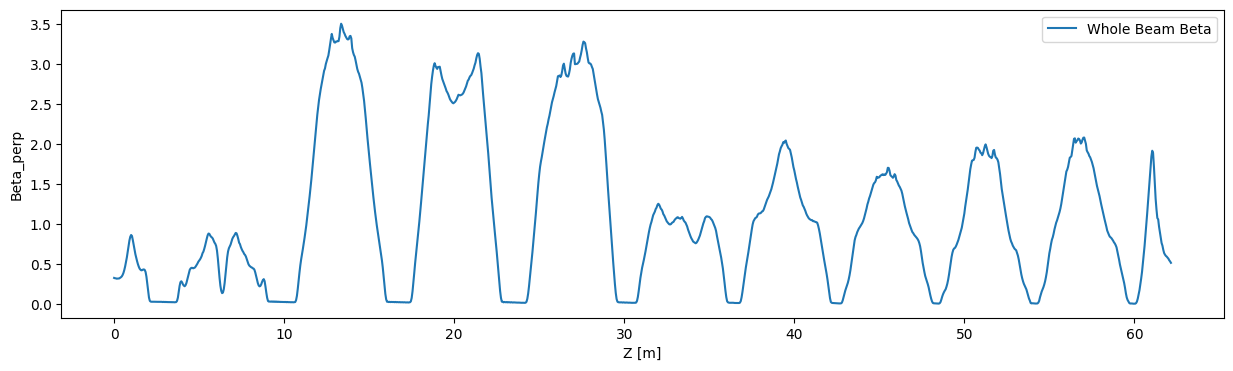

In [207]:
plt.figure(figsize=(15,4))
plt.plot(Z_arr, np.array(beta_arr), label='Whole Beam Beta')
plt.xlabel('Z [m]'), plt.ylabel('Beta_perp')

plt.legend()

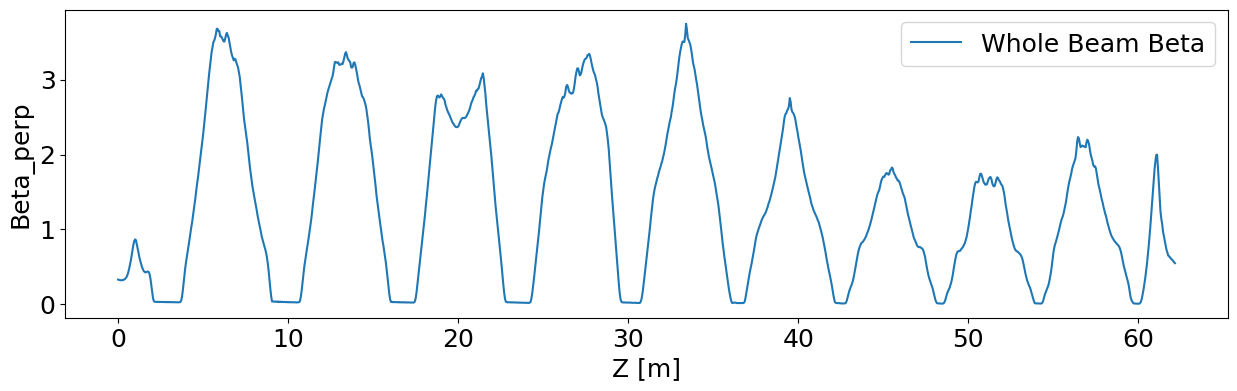

In [86]:
plt.figure(figsize=(15,4))
plt.plot(Z_arr, np.array(beta_arr), label='Whole Beam Beta')
plt.xlabel('Z [m]'), plt.ylabel('Beta_perp')

plt.legend()

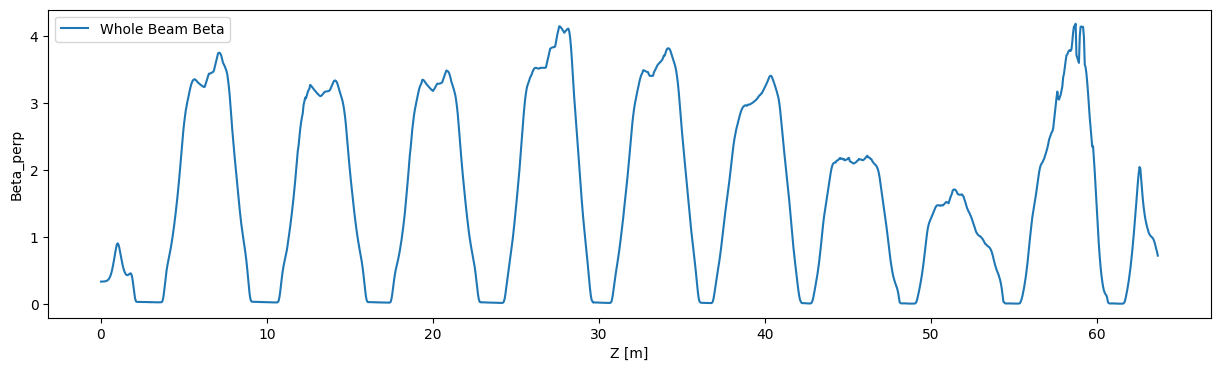

In [460]:
plt.figure(figsize=(15,4))
plt.plot(Z_arr, np.array(beta_arr), label='Whole Beam Beta')
plt.xlabel('Z [m]'), plt.ylabel('Beta_perp')
plt.legend()

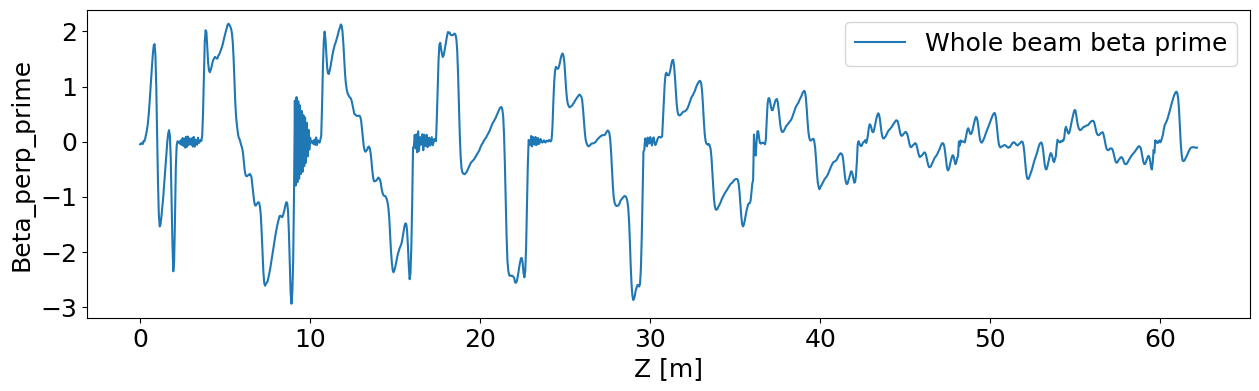

In [87]:
plt.figure(figsize=(15,4))
plt.plot(Z_arr,  -6*2*np.array(alpha_arr), label = 'Whole beam beta prime')
plt.xlabel('Z [m]'), plt.ylabel('Beta_perp_prime')

plt.legend()

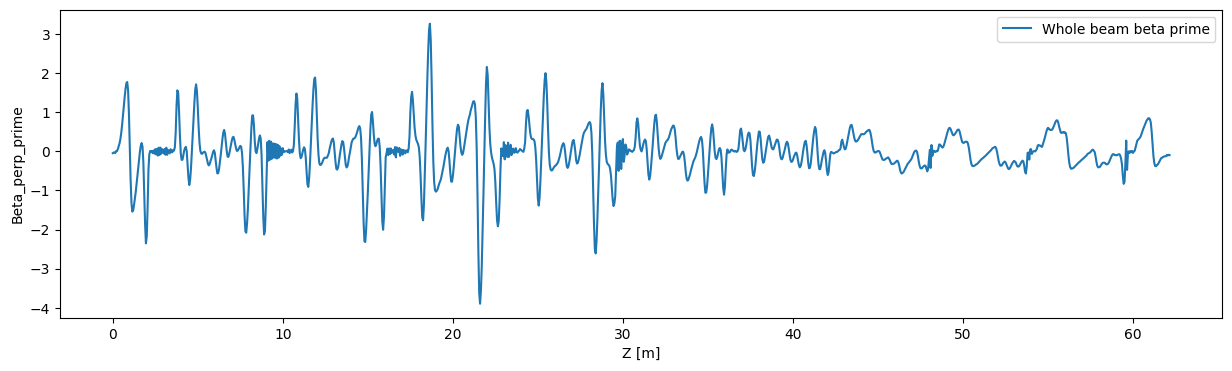

In [173]:
plt.figure(figsize=(15,4))
plt.plot(Z_arr,  -6*2*np.array(alpha_arr), label = 'Whole beam beta prime')
plt.xlabel('Z [m]'), plt.ylabel('Beta_perp_prime')

plt.legend()

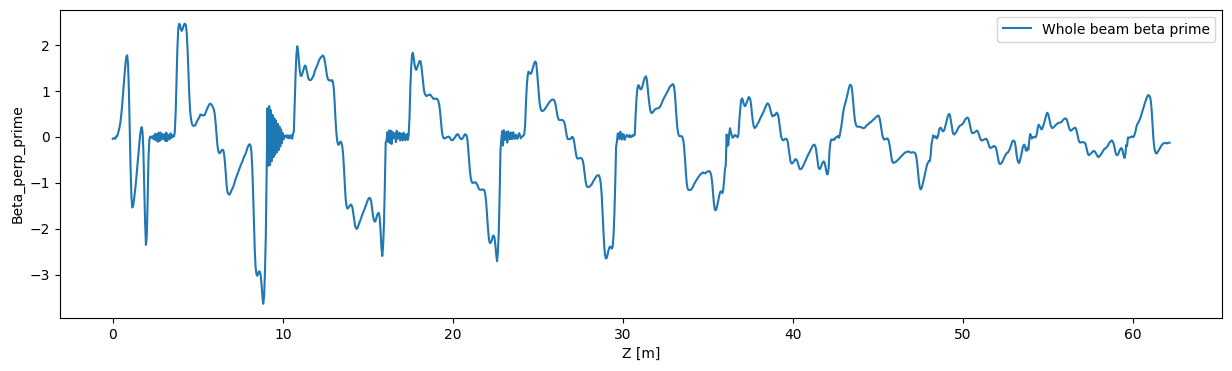

In [487]:
plt.figure(figsize=(15,4))
plt.plot(Z_arr,  -6*2*np.array(alpha_arr), label = 'Whole beam beta prime')
plt.xlabel('Z [m]'), plt.ylabel('Beta_perp_prime')

plt.legend()

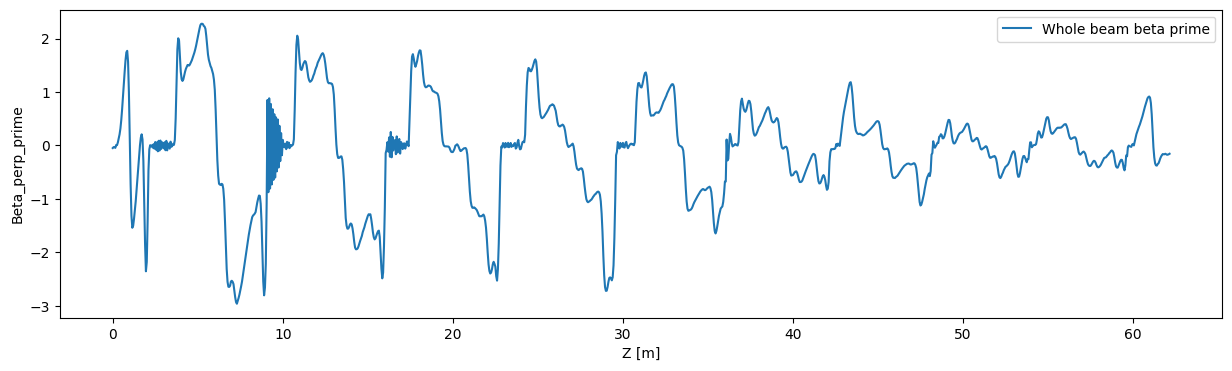

In [461]:
plt.figure(figsize=(15,4))
plt.plot(Z_arr,  -6*2*np.array(alpha_arr), label = 'Whole beam beta prime')
plt.xlabel('Z [m]'), plt.ylabel('Beta_perp_prime')

plt.legend()

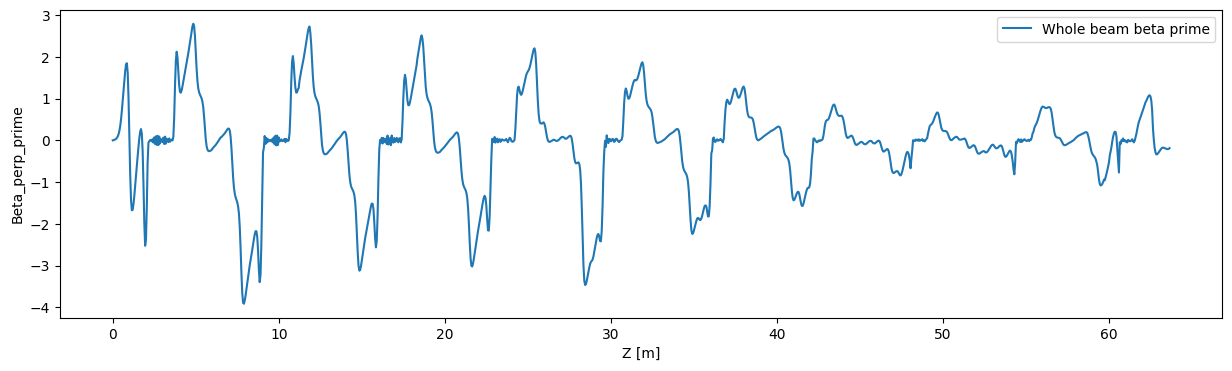

In [435]:
plt.figure(figsize=(15,4))
plt.plot(Z_arr,  -6*2*np.array(alpha_arr), label = 'Whole beam beta prime')
plt.xlabel('Z [m]'), plt.ylabel('Beta_perp_prime')

plt.legend()

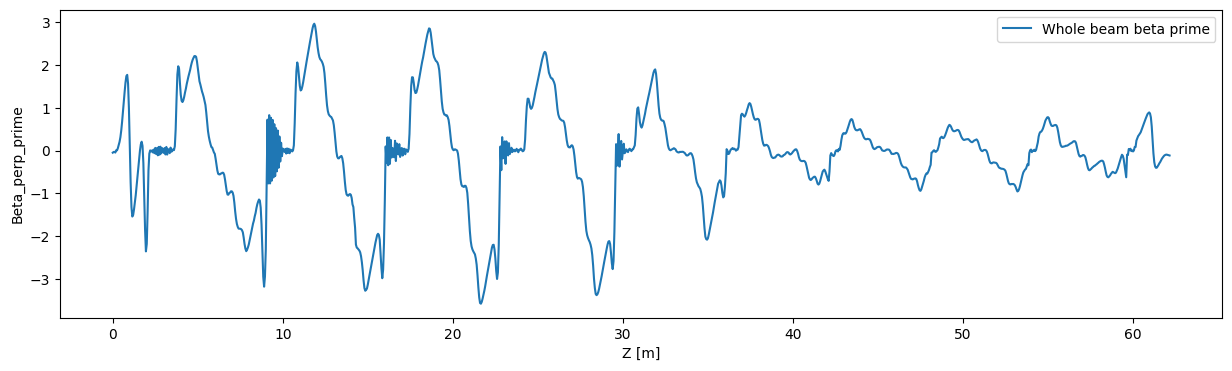

In [553]:
plt.figure(figsize=(15,4))
plt.plot(Z_arr,  -6*2*np.array(alpha_arr), label = 'Whole beam beta prime')
plt.xlabel('Z [m]'), plt.ylabel('Beta_perp_prime')


plt.legend()

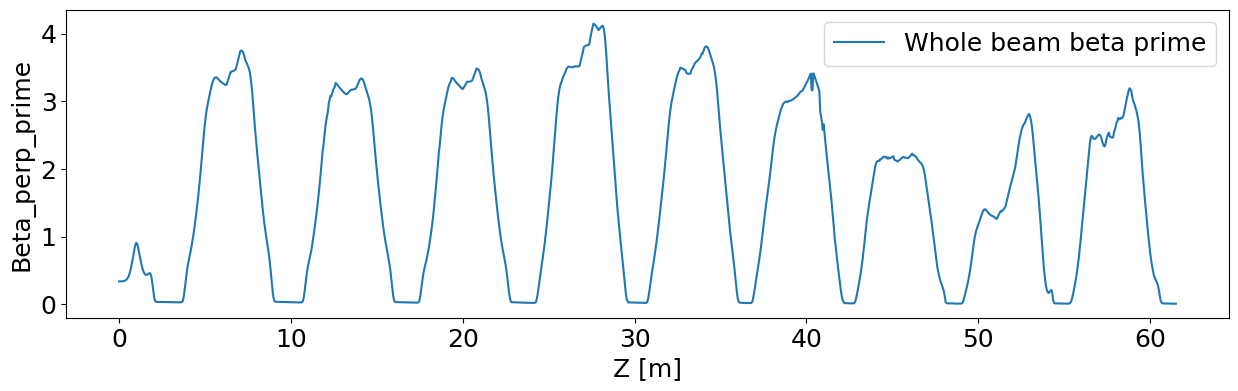

In [39]:
plt.figure(figsize=(15,4))
plt.plot(Z_arr,  np.array(beta_arr), label = 'Whole beam beta prime')
plt.xlabel('Z [m]'), plt.ylabel('Beta_perp_prime')


plt.legend()

(30.0, 300.0)

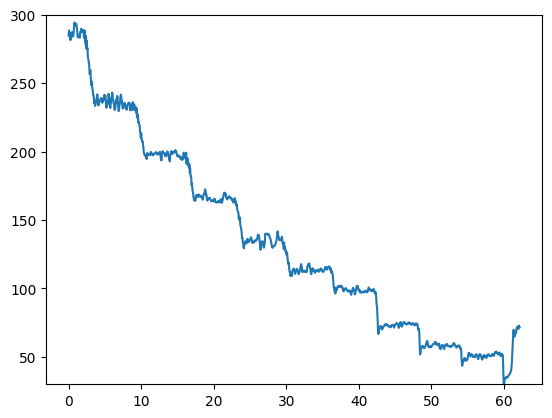

In [212]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(30, 300)

(30.0, 300.0)

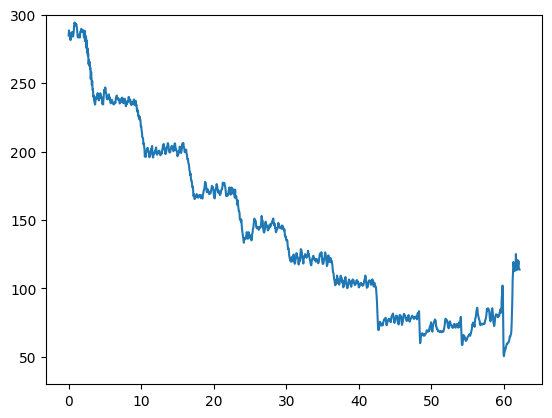

In [174]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(30, 300)

(30.0, 300.0)

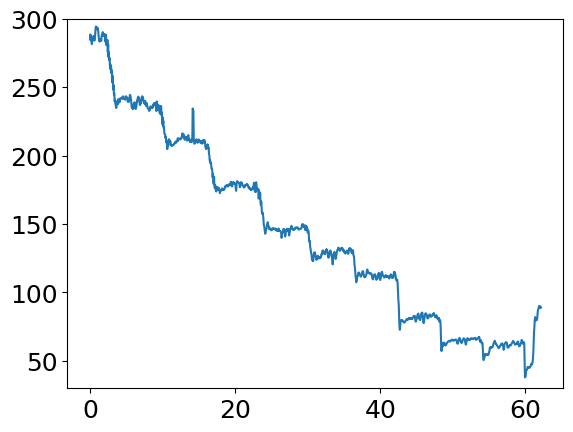

In [48]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(30, 300)

(30.0, 300.0)

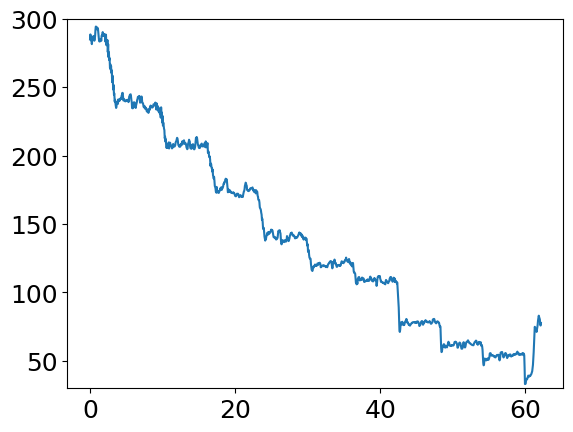

In [88]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(30, 300)

(30.0, 300.0)

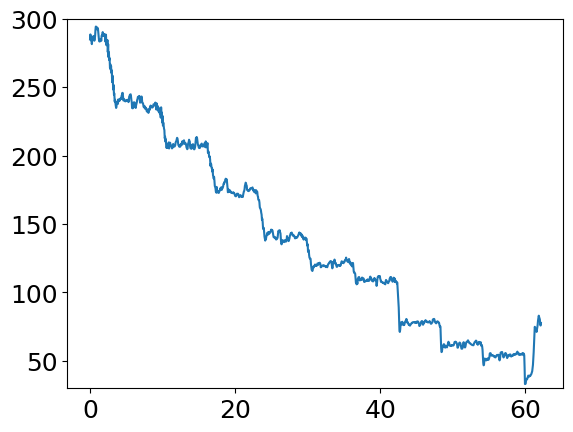

In [267]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(30, 300)

(50.0, 300.0)

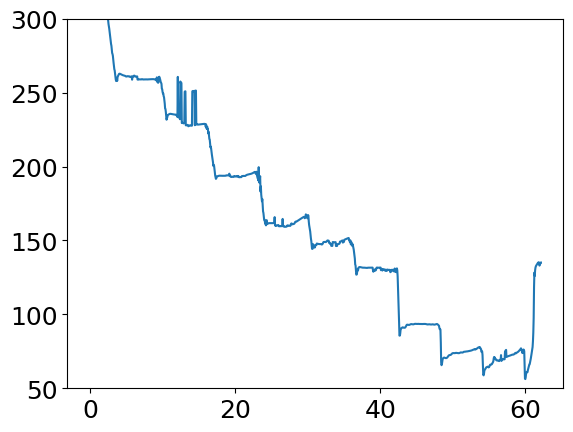

In [408]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(50, 300)

(50.0, 300.0)

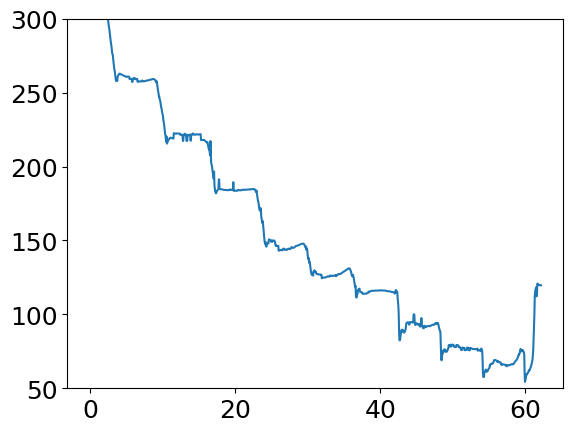

In [57]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(50, 300)

(50.0, 300.0)

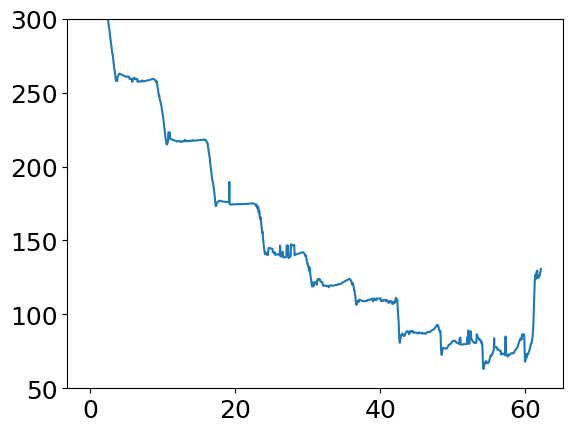

In [69]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(50, 300)

(50.0, 300.0)

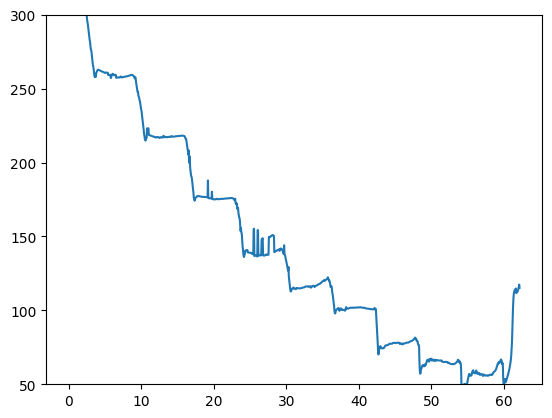

In [202]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(50, 300)

(50.0, 300.0)

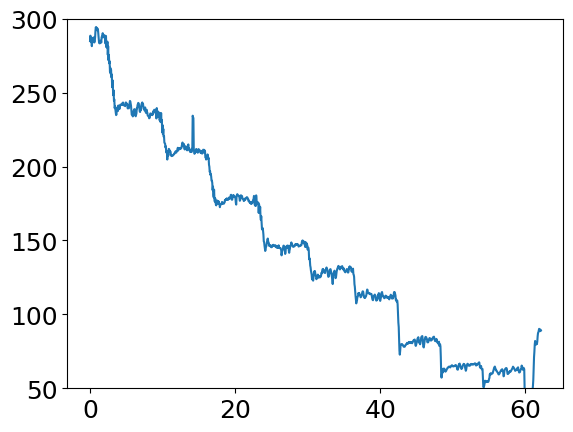

In [45]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(50, 300)

(40.0, 300.0)

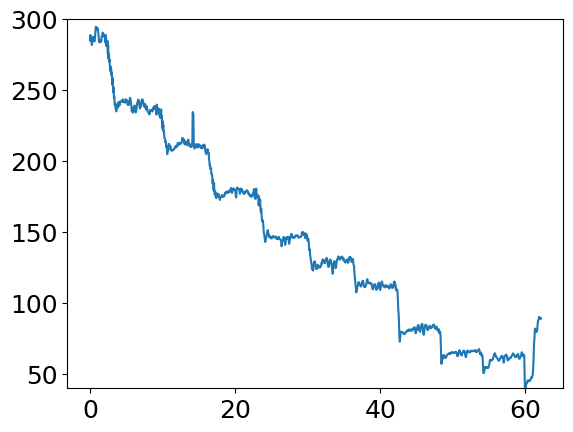

In [47]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(40, 300)

(45.0, 300.0)

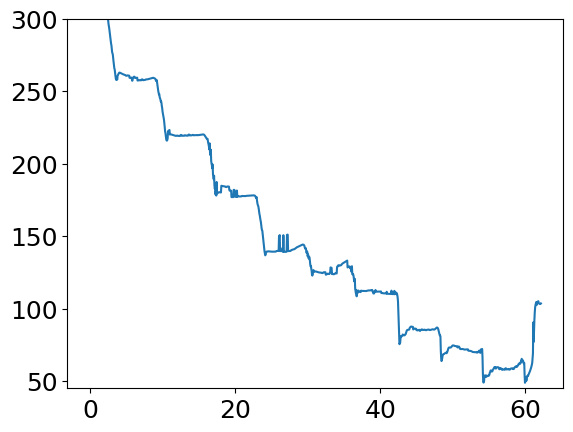

In [45]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(45, 300)

(45.0, 300.0)

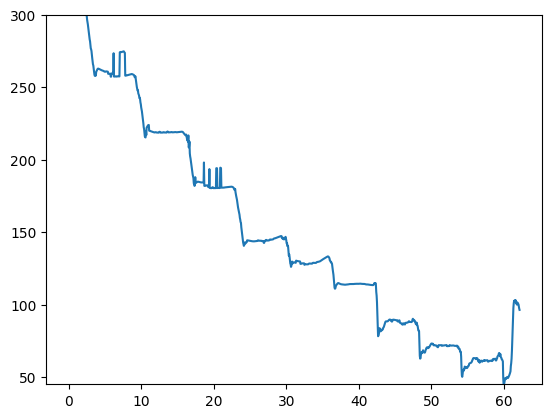

In [132]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(45, 300)

(50.0, 300.0)

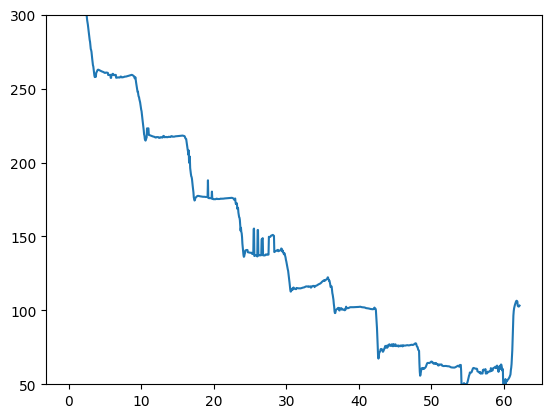

In [159]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(50, 300)

(50.0, 300.0)

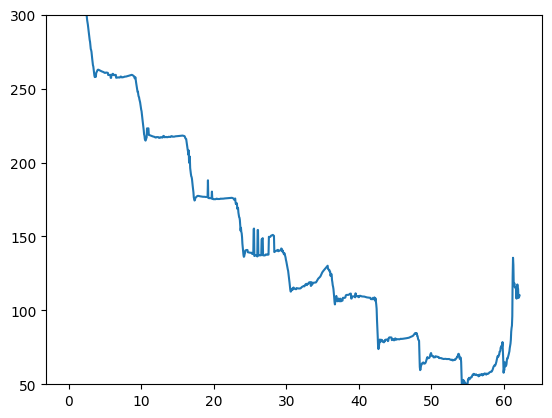

In [355]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(50, 300)

(30.0, 300.0)

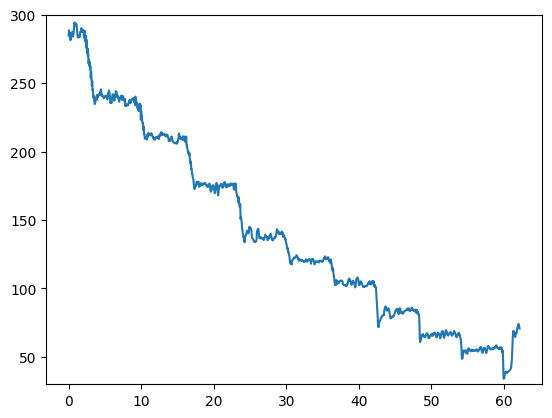

In [434]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(30, 300)

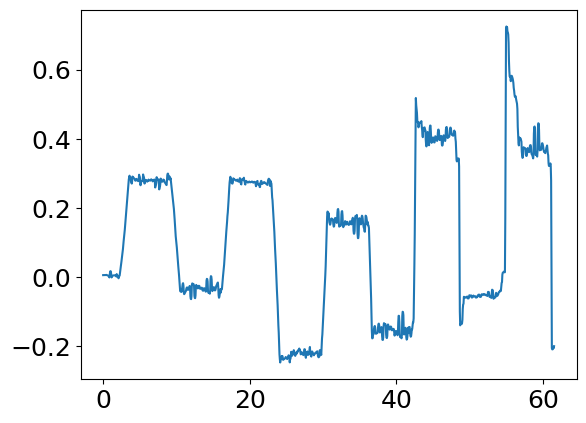

In [42]:
plt.plot(Z_arr, np.array(Lcanon_arr))

(50.0, 300.0)

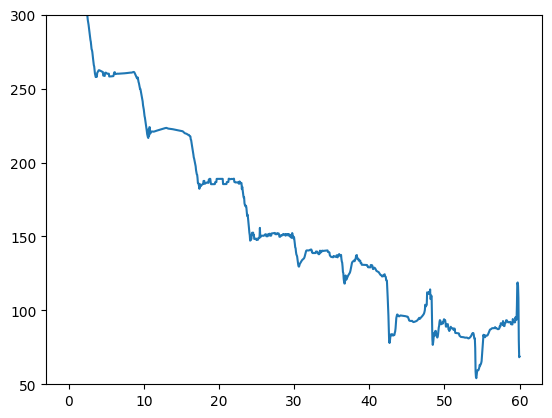

In [410]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(50, 300)

In [2]:
plt.plot(Z_arr, np.array(emitT_arr)*1E6)
plt.ylim(50, 300)

NameError: name 'plt' is not defined

C:\Users\accel\AppData\Local\Temp\ipykernel_3988\857722909.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax3.legend()
C:\Users\accel\AppData\Local\Temp\ipykernel_3988\857722909.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax4.legend(bbox_to_anchor=(1.0, 1.0))


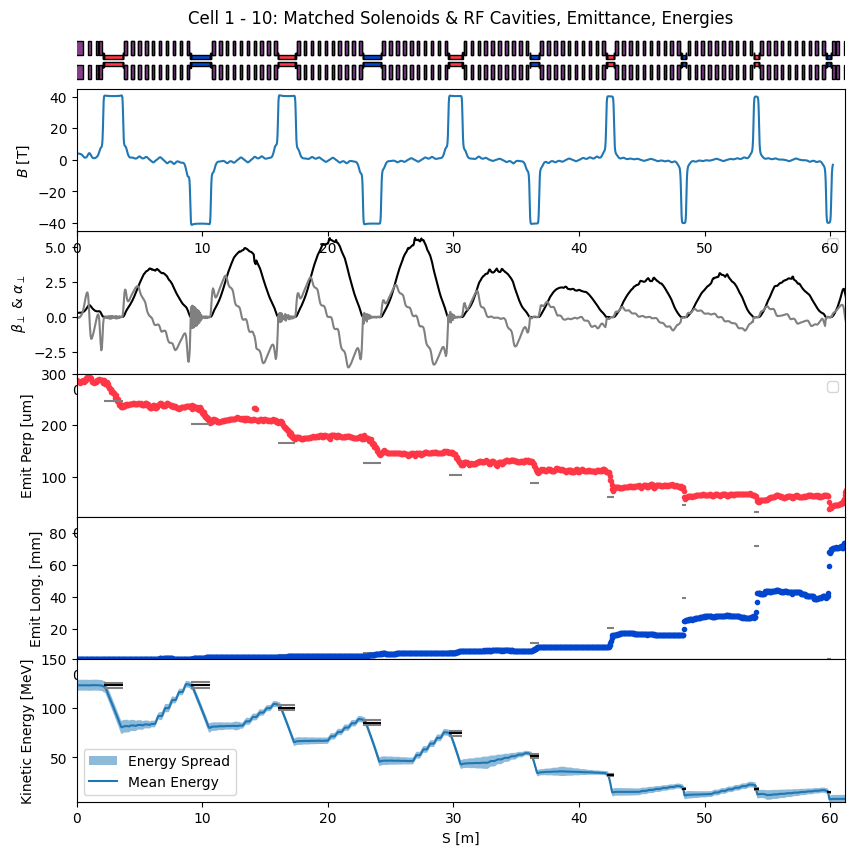

In [558]:
matplotlib.rcParams.update({'font.size': 10})

import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(12,10))
gs = mpl.gridspec.GridSpec(6, 2, height_ratios=[0.4, 1, 1,1,1,1], width_ratios=[1, 0.1])
# Create axes
ax1 = fig.add_subplot(gs[0])
ax4 = fig.add_subplot(gs[4])
ax3 = fig.add_subplot(gs[6])
ax5 = fig.add_subplot(gs[8])
ax2 = fig.add_subplot(gs[10])
ax6 = fig.add_subplot(gs[2])

plt.subplots_adjust(hspace=0)

I_max = H_current_density

ncell_match = 9
s_start, s_end = 0, H_solenoid_list[ncell_match].position + H_solenoid_list[ncell_match].L_sol
s = np.linspace(s_start, s_end, int((s_end-s_start)*100)) 
max_S = s_end
max_r = 1

for solenoid in sol_list + MD_solenoid_list:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])

# Set plot limits and labels
ax1.set(xlim=(0, max_S+1), ylim=(-0.6, 0.6), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax2.fill_between(Z_unique, Ez_arr-dEz_arr, Ez_arr+dEz_arr, alpha=0.5, label='Energy Spread')
ax2.plot(Z_unique, Ez_arr, label='Mean Energy')
for i in range(10):
    ax2.hlines(Energies[i]-EnergySpreads[i]/2, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    ax2.hlines(Energies[i]+EnergySpreads[i]/2, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    ax2.hlines(Energies[i], H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k')
#ax2.fill_between((H2_pos-1, H2_pos), (Energies[1]-EnergySpreads[1]/2, Energies[1]-EnergySpreads[1]/2), (Energies[1]+EnergySpreads[1]/2,Energies[1]+EnergySpreads[1]/2) , color='g', alpha=0)
ax2.set(xlim=(0, max_S+1), ylim=(5,150), xlabel='S [m]', ylabel='Kinetic Energy [MeV]')
ax2.legend(loc='lower left')

ax1.set_title('Cell 1 - 10: Matched Solenoids & RF Cavities, Emittance, Energies')

ax3.plot(Z_arr, np.array(emitT_arr)*1E6, '.', color=cmap(0))
ax3.set(xlabel='Z [m]',ylabel='Emit Perp [um]', ylim=(22.5,300), xlim=(0, max_S+1))

for i in range(10):
    ax3.hlines(1e6*EmitT_Target[i], H_pos_arr[i-1]-H_Lsol_list[i-1]/2, H_pos_arr[i-1]+H_Lsol_list[i-1]/2, color='grey')
    ax5.hlines(1e3*EmitL_Target[i], H_pos_arr[i-1]-H_Lsol_list[i-1]/2, H_pos_arr[i-1]+H_Lsol_list[i-1]/2, color='grey')

ax3.legend()

ax5.plot(Z_arr, np.array(emitL_arr)*1E3, '.', color=cmap(0.99))
ax5.set(xlabel='Z [m]',ylabel='Emit Long. [mm]', xlim=(0, max_S+1), ylim=(1.5, 90))


Mag_field = cp.MagneticField()
[Mag_field.add_solenoid(solenoid) for solenoid in sol_list + MD_solenoid_list];

p1 = p1_interp(s)
p2 = p2_interp(s)
p3 = p3_interp(s)
[beta_interp1, betaP_interp1], [beta_interp2, betaP_interp2], [beta_interp3, betaP_interp3], B_superposed = calc_beta_betap(Mag_field, s, p1, p2, p3)

# Plotting the results
ax4.plot(Z_arr,  np.array(beta_arr), color='k')
ax4.plot(Z_arr,  -6*2*np.array(alpha_arr), color='grey')
#ax4.plot(s, beta_interp1, c='g', lw=0.5, label=r'$\beta \ p_1$')
#ax4.plot(s, betaP_interp1, c='k', lw=0.5,label=r'$\beta^{\prime} \ p_1$')
#ax4.plot(s, beta_interp3, c='b', lw=0.5, label=r'$\beta \ p_3$')
#ax4.plot(s, betaP_interp3, c='grey', lw=0.5,label=r'$\beta^{\prime} \ p_3$')
ax4.set(xlabel='S [m]', ylabel=r'$\beta_\perp$ & $\alpha_\perp$', xlim=(0, max_S+1))
ax4.legend(bbox_to_anchor=(1.0, 1.0))


ax6.plot(s, B_superposed)
ax6.set(ylabel=(r'$B$ [T]'), xlim=(0, max_S+1))

ax1.set_axis_off()
plt.savefig('PerformanceOverview_Diagram.png')
plt.show()

C:\Users\accel\AppData\Local\Temp\ipykernel_18880\1468300214.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_eT.legend()
C:\Users\accel\AppData\Local\Temp\ipykernel_18880\1468300214.py:77: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_optics.legend(bbox_to_anchor=(1.0, 1.0))


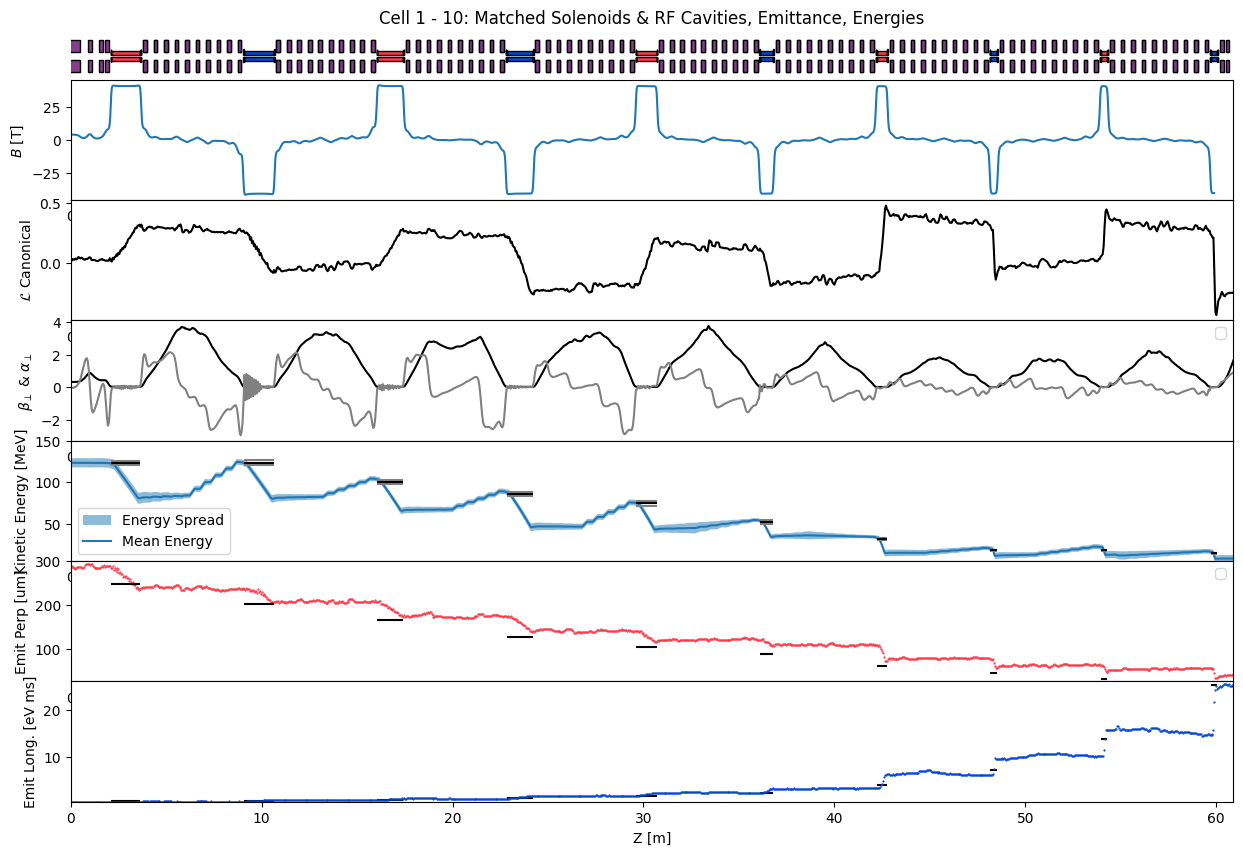

In [119]:
matplotlib.rcParams.update({'font.size': 10})

import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(15,10))
gs = mpl.gridspec.GridSpec(7, 1, height_ratios=[0.4, 1, 1,1,1,1,1])
# Create axes
ax_model = fig.add_subplot(gs[0])
ax_Bz = fig.add_subplot(gs[1])
ax_L = fig.add_subplot(gs[2])
ax_optics = fig.add_subplot(gs[3])
ax_E = fig.add_subplot(gs[4])
ax_eT = fig.add_subplot(gs[5])
ax_eL = fig.add_subplot(gs[6])

plt.subplots_adjust(hspace=0)

I_max = H_current_density

ncell_match = 9
s_start, s_end = 0, H_solenoid_list[ncell_match].position
s = np.linspace(s_start, s_end, int((s_end-s_start)*100)) 
max_S = s_end
max_r = 1

for solenoid in sol_list + MD_solenoid_list:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax_model.add_patch(rect_outer)
    ax_model.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])

# Set plot limits and labels
ax_model.set(xlim=(0, max_S+1), ylim=(-0.6, 0.6), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax_E.fill_between(Z_unique, Ez_arr-dEz_arr, Ez_arr+dEz_arr, alpha=0.5, label='Energy Spread')
ax_E.plot(Z_unique, Ez_arr, label='Mean Energy')
for i in range(10):
    ax_E.hlines(Energies[i]-EnergySpreads[i]/2, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    ax_E.hlines(Energies[i]+EnergySpreads[i]/2, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    ax_E.hlines(Energies[i], H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k')
#ax_E.fill_between((H2_pos-1, H2_pos), (Energies[1]-EnergySpreads[1]/2, Energies[1]-EnergySpreads[1]/2), (Energies[1]+EnergySpreads[1]/2,Energies[1]+EnergySpreads[1]/2) , color='g', alpha=0)
ax_E.set(xlim=(0, max_S+1), ylim=(5,150), xlabel='S [m]', ylabel='Kinetic Energy [MeV]')
ax_E.legend(loc='lower left')

ax_model.set_title('Cell 1 - 10: Matched Solenoids & RF Cavities, Emittance, Energies')

ax_eT.plot(Z_arr, np.array(emitT_arr)*1E6, '.', color=cmap(0), markersize=1.2)
ax_eT.set(xlabel='Z [m]',ylabel='Emit Perp [um]', ylim=(25,300), xlim=(0, max_S+1))

for i in range(10):
    ax_eT.hlines(1e6*EmitT_Target[i], H_pos_arr[i-1]-H_Lsol_list[i-1]/2, H_pos_arr[i-1]+H_Lsol_list[i-1]/2, color='k')
    ax_eL.hlines(1e3*EmitL_Target[i], H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k')

ax_eT.legend()

ax_eL.plot(Z_arr, np.array(emitL_arr)*1E3, '.', color=cmap(0.99), markersize=1.2)
ax_eL.set(xlabel='Z [m]',ylabel='Emit Long. [eV ms]', xlim=(0, max_S+1), ylim=(0.6, 26))
#plt.plot(Z_arr, np.array(transmission_arr)/1000*100, color='k', label='Transmission')


Mag_field = cp.MagneticField()
[Mag_field.add_solenoid(solenoid) for solenoid in sol_list + MD_solenoid_list];
B_superposed = Mag_field.superposed_field_z(s)

p1 = p1_interp(s)
p2 = p2_interp(s)
p3 = p3_interp(s)

# Plotting the results
ax_optics.plot(Z_arr,  np.array(beta_arr), color='k')
ax_optics.plot(Z_arr,  -6*2*np.array(alpha_arr), color='grey')
ax_optics.set(xlabel='S [m]', ylabel=r'$\beta_\perp$ & $\alpha_\perp$', xlim=(0, max_S+1))
ax_optics.legend(bbox_to_anchor=(1.0, 1.0))


ax_Bz.plot(s, B_superposed)
ax_Bz.set(ylabel=(r'$B$ [T]'), xlim=(0, max_S+1))

ax_L.plot(Z_arr, Lcanon_arr, color='k')
ax_L.set(ylabel=(r'$\mathcal{L}$ Canonical'), xlim=(0, max_S+1))

ax_model.set_axis_off()
plt.savefig('PerformanceOverview_Diagram.png')
plt.show()

In [116]:
EmitL_Target *1E3, emitL_arr[-1] * 1E3

(array([ 0.66386722,  0.80228246,  0.99874299,  1.4009607 ,  1.80807642,
         2.37135562,  4.16558454,  7.31586299, 13.83269717, 25.27544073]),
 25.854000887953713)

C:\Users\accel\AppData\Local\Temp\ipykernel_18880\903152923.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_eT.legend()
C:\Users\accel\AppData\Local\Temp\ipykernel_18880\903152923.py:76: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_optics.legend(bbox_to_anchor=(1.0, 1.0))


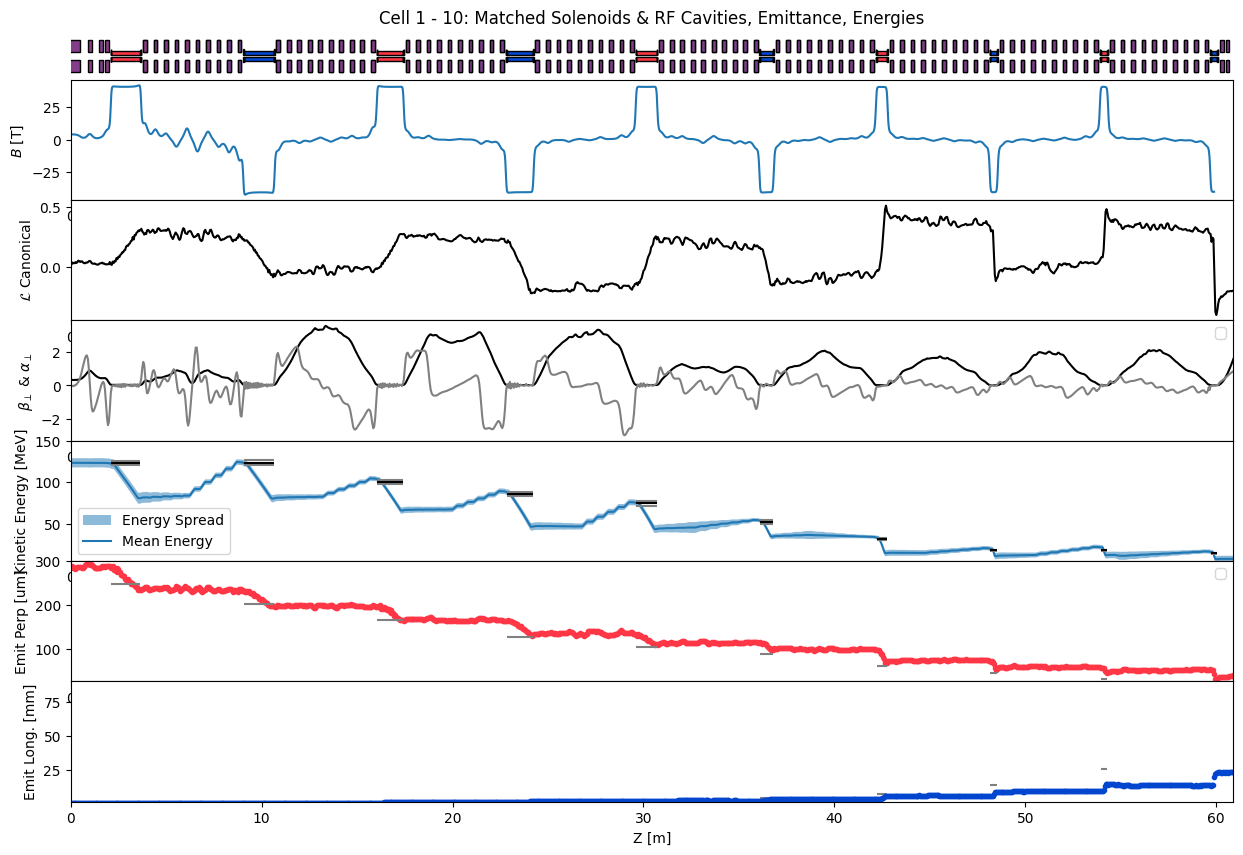

In [209]:
matplotlib.rcParams.update({'font.size': 10})

import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(15,10))
gs = mpl.gridspec.GridSpec(7, 1, height_ratios=[0.4, 1, 1,1,1,1,1])
# Create axes
ax_model = fig.add_subplot(gs[0])
ax_Bz = fig.add_subplot(gs[1])
ax_L = fig.add_subplot(gs[2])
ax_optics = fig.add_subplot(gs[3])
ax_E = fig.add_subplot(gs[4])
ax_eT = fig.add_subplot(gs[5])
ax_eL = fig.add_subplot(gs[6])

plt.subplots_adjust(hspace=0)

I_max = H_current_density

ncell_match = 9
s_start, s_end = 0, H_solenoid_list[ncell_match].position
s = np.linspace(s_start, s_end, int((s_end-s_start)*100)) 
max_S = s_end
max_r = 1

for solenoid in sol_list + MD_solenoid_list:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax_model.add_patch(rect_outer)
    ax_model.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])

# Set plot limits and labels
ax_model.set(xlim=(0, max_S+1), ylim=(-0.6, 0.6), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax_E.fill_between(Z_unique, Ez_arr-dEz_arr, Ez_arr+dEz_arr, alpha=0.5, label='Energy Spread')
ax_E.plot(Z_unique, Ez_arr, label='Mean Energy')
for i in range(10):
    ax_E.hlines(Energies[i]-EnergySpreads[i]/2, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    ax_E.hlines(Energies[i]+EnergySpreads[i]/2, H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='grey')
    ax_E.hlines(Energies[i], H_pos_arr[i]-H_Lsol_list[i]/2, H_pos_arr[i]+H_Lsol_list[i]/2, color='k')
#ax_E.fill_between((H2_pos-1, H2_pos), (Energies[1]-EnergySpreads[1]/2, Energies[1]-EnergySpreads[1]/2), (Energies[1]+EnergySpreads[1]/2,Energies[1]+EnergySpreads[1]/2) , color='g', alpha=0)
ax_E.set(xlim=(0, max_S+1), ylim=(5,150), xlabel='S [m]', ylabel='Kinetic Energy [MeV]')
ax_E.legend(loc='lower left')

ax_model.set_title('Cell 1 - 10: Matched Solenoids & RF Cavities, Emittance, Energies')

ax_eT.plot(Z_arr, np.array(emitT_arr)*1E6, '.', color=cmap(0))
ax_eT.set(xlabel='Z [m]',ylabel='Emit Perp [um]', ylim=(25,300), xlim=(0, max_S+1))

for i in range(10):
    ax_eT.hlines(1e6*EmitT_Target[i], H_pos_arr[i-1]-H_Lsol_list[i-1]/2, H_pos_arr[i-1]+H_Lsol_list[i-1]/2, color='grey')
    ax_eL.hlines(1e3*EmitL_Target[i], H_pos_arr[i-1]-H_Lsol_list[i-1]/2, H_pos_arr[i-1]+H_Lsol_list[i-1]/2, color='grey')

ax_eT.legend()

ax_eL.plot(Z_arr, np.array(emitL_arr)*1E3, '.', color=cmap(0.99))
ax_eL.set(xlabel='Z [m]',ylabel='Emit Long. [mm]', xlim=(0, max_S+1), ylim=(1.5, 90))


Mag_field = cp.MagneticField()
[Mag_field.add_solenoid(solenoid) for solenoid in sol_list + MD_solenoid_list];
B_superposed = Mag_field.superposed_field_z(s)

p1 = p1_interp(s)
p2 = p2_interp(s)
p3 = p3_interp(s)

# Plotting the results
ax_optics.plot(Z_arr,  np.array(beta_arr), color='k')
ax_optics.plot(Z_arr,  -6*2*np.array(alpha_arr), color='grey')
ax_optics.set(xlabel='S [m]', ylabel=r'$\beta_\perp$ & $\alpha_\perp$', xlim=(0, max_S+1))
ax_optics.legend(bbox_to_anchor=(1.0, 1.0))


ax_Bz.plot(s, B_superposed)
ax_Bz.set(ylabel=(r'$B$ [T]'), xlim=(0, max_S+1))

ax_L.plot(Z_arr, Lcanon_arr, color='k')
ax_L.set(ylabel=(r'$\mathcal{L}$ Canonical'), xlim=(0, max_S+1))

ax_model.set_axis_off()
plt.savefig('PerformanceOverview_Diagram.png')
plt.show()

In [210]:
CellNo = range(0,10)
Z_per_cell = []
emitT_per_cell = []
emitL_per_cell = []
E_per_cell = []
sigE_per_cell = []
transmission_init = len(sol_df[sol_df.Z == 0])
transmission_per_cell = []

for cellno in CellNo:
    Z_after_cell = H_solenoid_list[cellno].position+AbsorberLengths[cellno]/2+0.05
    Z_index = np.max(np.where(Z_arr <= Z_after_cell))
    Z_per_cell.append(Z_arr[Z_index])
    emitT_per_cell.append(emitT_arr[Z_index]*1E6)
    emitL_per_cell.append(emitL_arr[Z_index]*1E3)
    E_per_cell.append(Ez_arr[Z_index])
    sigE_per_cell.append(dEz_arr[Z_index])
    transmission_per_cell.append(len(sol_df[sol_df.Z == Z_arr[Z_index]])/transmission_init)

In [211]:
PerformanceTable = pd.DataFrame()
PerformanceTable['Cell No'] = CellNo
PerformanceTable['Z End [m]'] = Z_per_cell
PerformanceTable['εT [μm]'] = emitT_per_cell
#PerformanceTable['εT Tar'] = EmitT_Target[1:]*1E6
PerformanceTable['εL [eV ms]'] = emitL_per_cell
PerformanceTable['KE [MeV]'] = E_per_cell
PerformanceTable['σKE [MeV]'] = sigE_per_cell
PerformanceTable['Transm [%]'] = np.array(transmission_per_cell) * 100
PerformanceTable = PerformanceTable.round(1)
PerformanceTable

Cell No  Z End [m]  εT [μm]  εL [eV ms]  KE [MeV]  σKE [MeV]  Transm [%]
0        0        3.6    235.0         0.6      80.7        6.6        99.6
1        1       10.6    197.4         0.9      80.3        4.5        99.0
2        2       17.3    164.4         1.2      65.9        3.8        98.6
3        3       24.1    130.5         1.7      46.4        4.7        97.4
4        4       30.6    109.0         2.3      43.6        4.8        96.2
5        5       36.7     97.0         3.3      34.5        3.1        95.4
6        6       42.6     67.5         5.7      14.6        3.6        92.9
7        7       48.4     56.0         8.9      11.0        3.8        90.4
8        8       54.2     45.5        14.4      12.1        3.9        87.9
9        9       60.0     31.0        22.1       7.4        3.7        67.3

In [191]:
PerformanceTable = pd.DataFrame()
PerformanceTable['Cell No'] = CellNo
PerformanceTable['Z End [m]'] = Z_per_cell
PerformanceTable['εT [μm]'] = emitT_per_cell
#PerformanceTable['εT Tar'] = EmitT_Target[1:]*1E6
PerformanceTable['εL [eV ms]'] = emitL_per_cell
PerformanceTable['KE [MeV]'] = E_per_cell
PerformanceTable['σKE [MeV]'] = sigE_per_cell
PerformanceTable['Transm [%]'] = np.array(transmission_per_cell) * 100
PerformanceTable = PerformanceTable.round(1)
PerformanceTable

Cell No  Z End [m]  εT [μm]  εL [eV ms]  KE [MeV]  σKE [MeV]  Transm [%]
0        0        3.6    236.7         0.6      80.8        6.7       100.0
1        1       10.6    202.8         0.9      80.2        4.7        99.9
2        2       17.3    168.3         1.2      65.9        3.7        99.5
3        3       24.1    132.3         1.8      46.2        4.6        99.5
4        4       30.6    109.0         2.5      43.3        4.8        99.3
5        5       36.7     95.2         3.4      34.3        3.3        99.2
6        6       42.6     65.4         6.1      14.5        3.6        98.5
7        7       48.4     53.1         9.7      11.2        3.8        97.6
8        8       54.2     43.5        15.9      12.1        4.1        98.5
9        9       60.0     30.5        23.8       7.6        3.6        76.4

In [95]:
PerformanceTable = pd.DataFrame()
PerformanceTable['Cell No'] = CellNo
PerformanceTable['Z End [m]'] = Z_per_cell
PerformanceTable['εT [μm]'] = emitT_per_cell
#PerformanceTable['εT Tar'] = EmitT_Target[1:]*1E6
PerformanceTable['εL [mm]'] = emitL_per_cell
PerformanceTable['KE [MeV]'] = E_per_cell
PerformanceTable['σKE [MeV]'] = sigE_per_cell
PerformanceTable['Transm [%]'] = np.array(transmission_per_cell) * 100
PerformanceTable = PerformanceTable.round(1)
PerformanceTable

Cell No  Z End [m]  εT [μm]  εL [mm]  KE [MeV]  σKE [MeV]  Transm [%]
0        0        3.6    236.4      1.8      80.8        6.7       100.0
1        1       10.6    205.5      2.7      80.1        4.7        99.8
2        2       17.3    175.9      3.6      65.7        3.9        99.7
3        3       24.1    139.1      5.3      45.9        4.7        99.6
4        4       30.6    116.0      7.1      43.1        4.6        99.2
5        5       36.7    109.1      9.6      34.2        3.2        99.0
6        6       42.6     72.3     18.0      14.5        3.9        98.1
7        7       48.4     59.2     27.7      11.3        3.9        96.8
8        8       54.2     48.5     44.7      12.4        4.3        96.7
9        9       60.0     33.1     68.5       7.8        4.1        75.0

In [94]:
PerformanceTable = pd.DataFrame()
PerformanceTable['Cell No'] = CellNo
PerformanceTable['Z End [m]'] = Z_per_cell
PerformanceTable['εT [μm]'] = emitT_per_cell
#PerformanceTable['εT Tar'] = EmitT_Target[1:]*1E6
PerformanceTable['εL [mm]'] = emitL_per_cell
PerformanceTable['KE [MeV]'] = E_per_cell
PerformanceTable['σKE [MeV]'] = sigE_per_cell
PerformanceTable['Transm [%]'] = np.array(transmission_per_cell) * 100
PerformanceTable = PerformanceTable.round(1)
PerformanceTable

Cell No  Z End [m]  εT [μm]  εL [mm]  KE [MeV]  σKE [MeV]  Transm [%]
0        0        3.6    236.4      1.8      80.8        6.7       100.0
1        1       10.6    205.5      2.7      80.1        4.7        99.8
2        2       17.3    175.9      3.6      65.7        3.9        99.7
3        3       24.1    139.1      5.3      45.9        4.7        99.6
4        4       30.6    116.0      7.1      43.1        4.6        99.2
5        5       36.7    109.1      9.6      34.2        3.2        99.0
6        6       42.6     72.3     18.0      14.5        3.9        98.1
7        7       48.4     59.2     27.7      11.3        3.9        96.8
8        8       54.2     48.5     44.7      12.4        4.3        96.7
9        9       60.0     33.1     68.5       7.8        4.1        75.0

In [557]:
PerformanceTable = pd.DataFrame()
PerformanceTable['Cell No'] = CellNo
PerformanceTable['Z End [m]'] = Z_per_cell
PerformanceTable['εT [μm]'] = emitT_per_cell
#PerformanceTable['εT Tar'] = EmitT_Target[1:]*1E6
PerformanceTable['εL [mm]'] = emitL_per_cell
PerformanceTable['KE [MeV]'] = E_per_cell
PerformanceTable['σKE [MeV]'] = sigE_per_cell
PerformanceTable['Transm [%]'] = np.array(transmission_per_cell) * 100
PerformanceTable = PerformanceTable.round(1)
PerformanceTable

Cell No  Z End [m]  εT [μm]  εL [mm]  KE [MeV]  σKE [MeV]  Transm [%]
0        0        3.5    238.5      1.8      81.9        6.6       100.0
1        1       10.5    210.2      2.8      80.8        4.7        99.9
2        2       17.2    178.5      3.5      67.1        3.9        99.0
3        3       24.0    146.5      4.9      47.4        4.4        98.7
4        4       30.6    126.8      6.7      43.6        4.5        97.8
5        5       36.6    110.1      8.8      34.8        3.3        97.7
6        6       42.6     83.6     14.9      16.8        3.7        97.1
7        7       48.4     71.3     19.9      15.4        3.3        96.2
8        8       54.2     56.6     36.9      14.9        3.7        94.8
9        9       59.9     50.4     59.3      10.0        3.6        92.4

In [557]:
PerformanceTable

Cell No  Z End [m]  εT [μm]  εL [mm]  KE [MeV]  σKE [MeV]  Transm [%]
0        0        4.4    262.0      2.1      82.2        6.2       100.0
1        1       11.4    220.1      3.4      80.9        5.7        99.9
2        2       18.0    186.9      5.2      64.0        3.8        99.8
3        3       24.8    148.6      8.0      44.8        3.6        99.4
4        4       31.2    128.1     10.7      44.4        4.4        99.3
5        5       37.1    115.3     13.9      34.5        5.0        99.1
6        6       43.0     80.4     25.3      13.5        5.1        93.7
7        7       49.4     65.6     45.0      10.6        4.5        81.8
8        8       55.7     56.2     77.0       8.1        4.0        58.4
9        9       61.5     52.8    104.3       8.5        4.1        41.8

In [192]:
import tabulate
import re

Print to README file

In [193]:
md = PerformanceTable.to_markdown(index=False)
path = "README.md"

with open(path, "r", encoding="utf-8") as f:
    text = f.read()

# Regex: matches any markdown table (header row + separator row + body)
table_pattern = r"\|.*?\|\n\|[-| :]+\|\n(?:\|.*?\|\n)*"

if re.search(table_pattern, text, flags=re.DOTALL):
    updated = re.sub(table_pattern, md + "\n", text, flags=re.DOTALL)
else:
    updated = text.rstrip() + "\n\n" + md + "\n"

with open(path, "w", encoding="utf-8") as f:
    f.write(updated)

Text(0.5, 0, 'Z [m]')

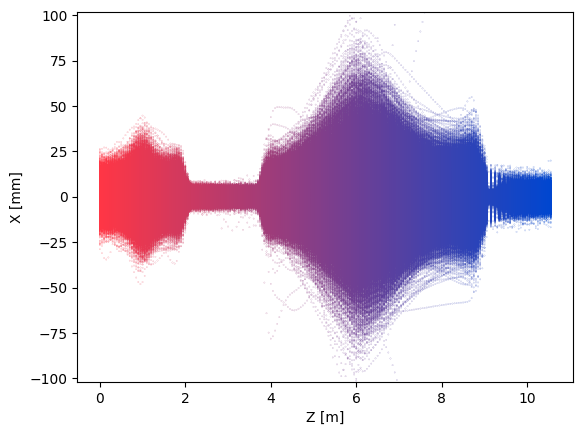

In [ ]:
plt.scatter(sol_df.Z, sol_df.X*1E3, s=0.01, c=sol_df.Z, cmap=cmap)
std_lim = 8
xlimmin, xlimmax = sol_df.X.mean()-std_lim*sol_df.X.std(), sol_df.X.mean()+std_lim*sol_df.X.std()
plt.ylim(xlimmin*1E3, xlimmax*1E3)
plt.ylabel('X [mm]')
plt.xlabel('Z [m]')

## Matching Time

- s_end should be after solenoid
- multilines instead of tuples (s_start, s_end)
- variables lower case (will be changed by code), constants all capital (I change value)
- Comment out code that shouldn't run
- Functions multi-line for expressions
- Truncated current density list: printed vs optimize-generated?
- Verify with same input - do not redefine
- collect as md

In [ ]:
new_optimisation_map = [{} for i in range(9)] 
new_optimisation_map[0]['target'] = 3.007171734892128
new_optimisation_map[0]['params'] = [194.56584495504487, 25.989002406974677, 54.84605880694238, 50.58592475019968, -47.6311758760214] 
new_optimisation_map[1]['target'] = 0.7007570121985558
new_optimisation_map[1]['params'] = [-189.39983606839365, -15.972289335470533, -54.83902935306448, -50.16499520396304, 47.861475321067374] 
new_optimisation_map[2]['target'] = 2.950678851861172
new_optimisation_map[2]['params'] = [185.8011231707078, 16.29905803615439, 56.497570952326214, 51.62388338566339, -46.74945755380631] 
new_optimisation_map[3]['target'] = 24.623969481887855
new_optimisation_map[3]['params'] = [-178.24573065467578, -16.7811704308618, -56.69118432591729, -51.62030674096943, 47.72906551924105]
new_optimisation_map[4]['target'] = 22.75685373248347
new_optimisation_map[4]['params'] = [185.7961196503444, 16.30123187940912, 59.30678986278509, 51.6275649028361, -46.750081086514385]
new_optimisation_map[5]['target'] = 21.605070663484604
new_optimisation_map[5]['params'] = [-175.2264823099029, -71.44648834961983, -67.15431928764642, -56.831215043131145, 47.47623847607771]
new_optimisation_map[6]['target'] = 23.130987640083003
new_optimisation_map[6]['params'] = [163.2559940574584, 82.40264290573054, 52.55495360515054, 52.82907404705618, -52.8176607190769]
new_optimisation_map[7]['target'] = 17.88623226740227
new_optimisation_map[7]['params'] = [-159.18785093814594, -86.87939732511857, -68.14463321923101, -40.19674985306293, 57.594135126179154]
new_optimisation_map[8]['target'] = 35.921722449927316
new_optimisation_map[8]['params'] = [177.7226089868529, 81.54659194811367, 68.14458615854453, 40.19674534290901, -57.594124989043664]

In [49]:
new_optimisation_map = [{} for i in range(9)] 
new_optimisation_map[0]['target'] =  0.41066167356397604
new_optimisation_map[0]['params'] = [ 300,   196.77660106 , 119.52545755, -167.90793199,  242.72421517]  
new_optimisation_map[1]['target'] =  0.008362399770219821
new_optimisation_map[1]['params'] = [-250,  -147.16153433, -164.88008369,   83.15953399, -128.027755  ]  
new_optimisation_map[2]['target'] = 0.05912039714352205
new_optimisation_map[2]['params'] = [160.98208559,  74.06355194, 30.62649151,  57.6883712,  -33.80815102] 
new_optimisation_map[3]['target'] =  0.2514845480131836
new_optimisation_map[3]['params'] = [-140.85372527,  -89.64816596, -6.01177313,  -50.63185751,   50.80434645] 
new_optimisation_map[4]['target'] =  2.669563827601886
new_optimisation_map[4]['params'] = [150.44578217,  90.34116888, 27.52318555,  10.52672585, -69.19268017] 
new_optimisation_map[5]['target'] =  0.22143726633081637
new_optimisation_map[5]['params'] = [-170.44305333, -103.00012069, -5.9402764,   -59.09266759,   70.48102954]  
new_optimisation_map[6]['target'] =  0.14790067988065914
new_optimisation_map[6]['params'] = [ 89.3172041,  104.4502414, 30.35822968,  -0.94859925, -67.65714265] 
new_optimisation_map[7]['target'] =  0.12653384415014785
new_optimisation_map[7]['params'] = [-274.85601303, -142.73895607,   68.52459844,  -91.43323461,   70.08098167]
new_optimisation_map[8]['target'] = 3.425290001643518
new_optimisation_map[8]['params'] = [231.23673919, 115.67564527,  39.23997303,  69.02882873, -75.3663393 ] 

In [52]:
new_optimisation_map = [{} for i in range(9)] 
new_optimisation_map[0]['params'] = [188.02230259266236, 49.898072723935016, 13.293536007796646, 66.89740546923335, -47.58911986217442]
new_optimisation_map[1]['params'] = [-186.4081958615795, -32.949539734095744, -65.66246086326912, -34.56411773485139, 49.1267336392535]
new_optimisation_map[2]['params'] = [161.01497638805182, 46.34742314873607, 88.01103564330023, -9.830688169439412, -11.553458932614955]
new_optimisation_map[3]['params'] = [-140.63946578879822, -87.49539399464119, -7.6413879109339575, -64.58099126591648, 21.92993610992005]
new_optimisation_map[4]['params'] = [146.79538137263566, 93.4584713768201, 20.761192293613412, 10.072037996073462, -69.46251948691341]
new_optimisation_map[5]['params'] = [-171.39033458185264, -103.57871648773272, -29.891277328854688, -24.365178921529612, 81.0012430346527]
new_optimisation_map[6]['params'] = [239.98508231388223, 133.9499714322465, 37.0551305888218, 84.11072800074709, -79.08018068380628]
new_optimisation_map[7]['params'] = [-250.0, -143.14108411725974, 30.01802934177153, -108.13992090874152, 54.684428598994515]
new_optimisation_map[8]['params'] = [231.2367391873342, 115.67564526817557, 39.23997302911351, 69.02882873133365, -75.36633930182539]

In [53]:
np.set_printoptions(legacy='1.25')

In [54]:
for cellno in range(1,10):
    current_density_array = []
    for m, matcher in enumerate(np.array(MD_solenoid_list)[get_matching_solenoid_index(cellno,0)]):
        if m < 5:
            current_density_array.append(new_optimisation_map[cellno-1]['params'][m] * p2_interp(matcher.position))
        if m >= 5:
            current_density_array.append(-1*(new_optimisation_map[cellno-1]['params'][4-m] * p2_interp(matcher.position)))
    print(current_density_array)

[29.111657748265788, 7.770668698322591, 2.0780735138438775, 10.49900954085786, -7.495575151591984, 7.95373971302427, -11.816292655746388, -2.4743724994023184, -9.754001590741128, -38.405798160744546]
[-28.75291932501496, -5.10160776559983, -10.18166836971315, -5.363069453702374, 7.639264017480231, -7.899052061165514, 5.739264071854043, 11.250204071335906, 5.818381929582298, 33.81469975810126]
[21.90186401612319, 6.320592677788482, 12.009145546441621, -1.3421215151747294, -1.5780337875156931, 1.6424583889103515, 1.4509902530049335, -13.465906659415078, -7.342993609800253, -26.30828332018152]
[-15.431556230093507, -9.611600087960788, -0.8383559110788232, -7.075477675647452, 2.3981197230759586, -2.5745684617479547, 8.082573316056695, 1.014213731399288, 12.269454669895454, 20.704478284982653]
[15.50829970461758, 9.913449024277261, 2.2073513529462976, 1.0747809258483876, -7.582640563326531, 7.746929031823667, -1.145990558767439, -2.407496936612131, -11.049148885114635, -17.641089016344765]


In [194]:
for cellno in range(1,10):
    current_density_array = []
    for m, matcher in enumerate(np.array(MD_solenoid_list)[get_matching_solenoid_index(cellno,0)]):
        if m < 5:
            current_density_array.append(new_optimisation_map[cellno-1]['params'][m] * p2_interp(matcher.position))
        if m >= 5:
            current_density_array.append(-1*(new_optimisation_map[cellno-1]['params'][4-m] * p2_interp(matcher.position)))
    print(current_density_array)

[29.109678826328274, 7.762337251927026, 2.0764672306013887, 10.500516819242016, -7.4959473707638224, 7.95336658657965, -11.822642820135172, -2.47175533131913, -9.741257372864567, -38.40584164060474]
[-28.773155219779163, -5.099297076572033, -10.181116421482939, -5.375580255070227, 7.650157940059772, -7.9116948749308955, 5.750863703270638, 11.253891617746019, 5.81947470950569, 33.86068640619898]
[21.959896592212413, 6.326429793616051, 12.01018162412949, -1.3463871232241473, -1.5817223491642234, 1.6452428907824952, 1.4552001357072446, -13.46624284442252, -7.344632755079872, -26.374543590081743]
[-15.507582394707757, -9.640299831582778, -0.8407535268800914, -7.107700283732729, 2.4068917473922395, -2.5819378862909956, 8.111337354569459, 1.0153104941808797, 12.280072489833005, 20.76784277682924]
[15.53791830214325, 9.923952068352747, 2.211853832383391, 1.0826687497762733, -7.632264539338844, 7.7882188379631785, -1.1518883436093472, -2.4157670032226854, -11.070451995346563, -17.6802223167510

In [320]:
for i in range(9):
    print(new_optimisation_map[i]['params'])

[188.02230259266236, 49.898072723935016, 13.293536007796646, 66.89740546923335, -47.58911986217442]
[-186.4081958615795, -32.949539734095744, -65.66246086326912, -34.56411773485139, 49.1267336392535]
[161.01497638805182, 46.34742314873607, 88.01103564330023, -9.830688169439412, -11.553458932614955]
[-140.63946578879822, -87.49539399464119, -7.6413879109339575, -64.58099126591648, 21.92993610992005]
[146.79538137263566, 93.4584713768201, 20.761192293613412, 10.072037996073462, -69.46251948691341]
[-171.39033458185264, -103.57871648773272, -29.891277328854688, -24.365178921529612, 81.0012430346527]
[239.98508231388223, 133.9499714322465, 37.0551305888218, 84.11072800074709, -79.08018068380628]
[-250.0, -143.14108411725974, 30.01802934177153, -108.13992090874152, 54.684428598994515]
[231.2367391873342, 115.67564526817557, 39.23997302911351, 69.02882873133365, -75.36633930182539]


In [316]:
new_optimisation_map[1]['params']

[-186.4081958615795,
 -32.949539734095744,
 -65.66246086326912,
 -34.56411773485139,
 49.1267336392535]

In [167]:
NCELL_MATCH = 9
N_MAGNETS = 5
BOUND_MIN = -300
BOUND_MAX = 300
bounds = np.tile([BOUND_MIN, BOUND_MAX], [N_MAGNETS, 1]) #current_density


sol_list = [item for key in all_solenoid_dict for item in all_solenoid_dict[key]]

half_sol_len = H_solenoid_list[NCELL_MATCH].L_sol/2
half_abs_len = AbsorberLengths[NCELL_MATCH]/2

s_start = 0
s_end = H_solenoid_list[NCELL_MATCH].position + half_sol_len*1.2 #Extra 20% after solenoid
s_array = np.arange(s_start, s_end, 0.001) 

In [168]:
options = {
    'maxiter': 10000,
    'xatol':1e-3,   # stop moving when parameter changes < 0.001
    'fatol':1e-3    # stop when objective change < 0.001
} #scipy minimize algo iterations

opt_point = H_solenoid_list[NCELL_MATCH].position
#points = np.array([opt_point-0.5, opt_point-0.4, opt_point-0.3, opt_point-0.2, opt_point-0.15, opt_point-0.12, opt_point, opt_point+0.12, opt_point+0.15, opt_point+0.2, opt_point+0.3, opt_point+0.4, opt_point+0.5])
points = np.arange(H_solenoid_list[NCELL_MATCH].position-half_sol_len, H_solenoid_list[NCELL_MATCH].position+half_sol_len, 0.01)

1: [231.2367391873342, 115.67564526817557, 39.23997302911351, 69.02882873133365, -75.36633930182539], 1.205188240329186


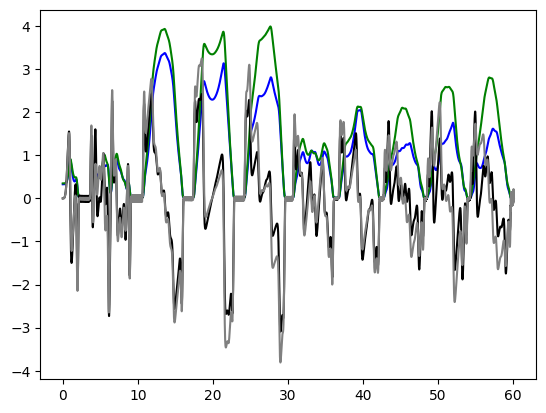

200: [243.49812793882867, 116.6700049553497, 39.37975187954372, 70.93876942595965, -74.89114063483262], 0.8617591589376442


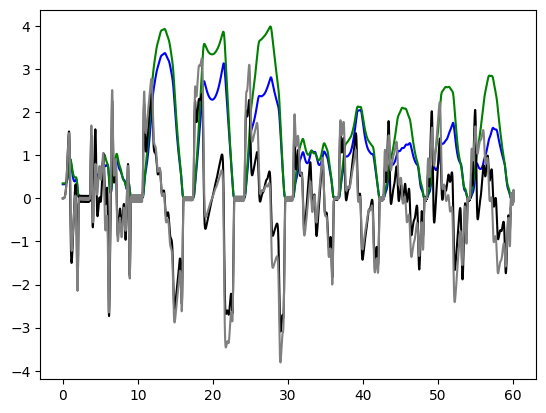

400: [243.34661147875636, 116.87655000805611, 38.44250445238581, 71.99730432653605, -74.31997514482762], 0.8616270467677393


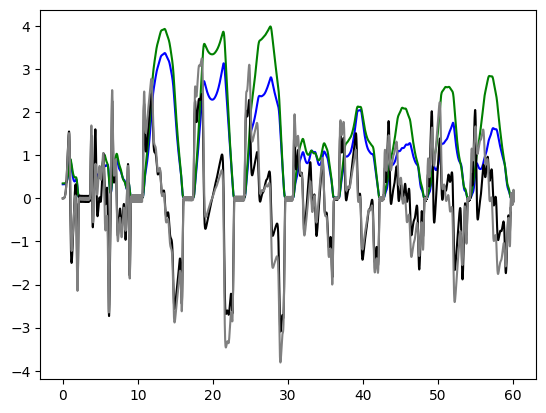

[243.34597299580565, 116.87685468682082, 38.441221510185, 71.99869434155771, -74.31929347598057] 0.8616270452207724


In [169]:
objective.counter = 0 #for the start of the interation

optimized_params = 1*np.array(new_optimisation_map[NCELL_MATCH-1]['params'])

particles = [
    dict(p_pz =   np.interp(s_array, Z_unique, 1E-3*(pz_arr-dpz_arr)),
         p_points = np.interp(points, Z_unique, 1E-3*(pz_arr-dpz_arr))
         ),
    dict(p_pz =   np.interp(s_array, Z_unique, 1E-3*(pz_arr+dpz_arr)),
         p_points = np.interp(points, Z_unique, 1E-3*(pz_arr+dpz_arr))
         ),
]

indices = get_matching_solenoid_index(NCELL_MATCH,0)

mean_momentum = np.interp([all_solenoid_dict["MD"][i].position for i in indices],
                         Z_unique,
                         (1E-3*pz_arr))

result = cp.nelder_mead(
    objective,
    optimized_params,
    args=(points,
          s_array,
          deepcopy(all_solenoid_dict),
          'MD',
          get_matching_solenoid_index(NCELL_MATCH,0),
          particles,
          mean_momentum,
          [1,1,100],
          200
          ),
    bounds=bounds,
    max_iter=10000,
    tol_f=1e-4,
    tol_x=1e-4,
)

optimisation_result = result['x'].tolist()
optimisation_target = result['fun']
print(optimisation_result, optimisation_target)

In [171]:
optimisation_result, optimisation_target = [243.34597299580565, 116.87685468682082, 38.441221510185, 71.99869434155771, -74.31929347598057], 0.8616270452207724

1: [243.34597299580565, 116.87685468682082, 38.441221510185, 71.99869434155771, -74.31929347598057], 0.8616270452207724


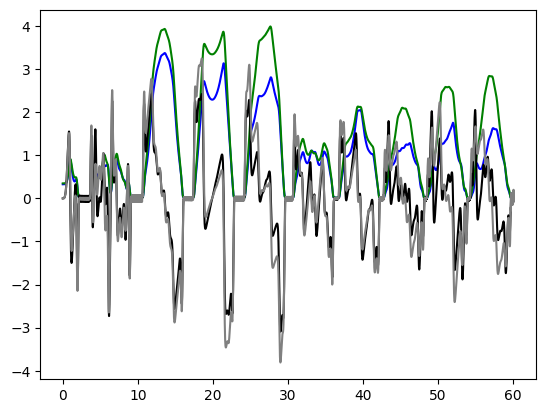

0.8616270452207724
Achieved expected target
Saved to MD_solenoid_list


In [172]:
objective.counter = 0 #for the start of the interation
# == VERIFICATION CELL ==
objective_value = objective(np.array(optimisation_result),
                   points,
                   s_array,
                   deepcopy(all_solenoid_dict),
                   'MD',
                   get_matching_solenoid_index(NCELL_MATCH,0),
                   particles,
                   mean_momentum,
                   [1,1,100],
                   100
                )

print(objective_value)
# We confirm if our optimised value matches our objective value.
# If so, save it to be checked contextually later.
if objective_value == optimisation_target:
    print('Achieved expected target')
    new_optimisation_map[NCELL_MATCH - 1] = {
        "params": optimisation_result,
        "target": optimisation_target,
        "matchers" : MD_solenoid_list
    }
    params_ = np.r_[np.array(new_optimisation_map[NCELL_MATCH - 1]["params"]), -np.array(new_optimisation_map[NCELL_MATCH - 1]["params"])[::-1]] 
    for m, matcher in enumerate(np.array(all_solenoid_dict['MD'])[get_matching_solenoid_index(NCELL_MATCH,0)]):
        matcher.current_density = params_[m] * mean_momentum[m]
    print('Saved to MD_solenoid_list')
else:
    print(f"Expected {optimisation_target}, achieved {objective_value}")

In [185]:
# == UPSTREAM VERIFICATION ==

for index, optimised_solenoid in enumerate(new_optimisation_map):
    points_verify = np.arange(H_solenoid_list[index + 1].position-AbsorberLengths[index + 1]/2, H_solenoid_list[index + 1].position+AbsorberLengths[index + 1]/2, 0.01), #points,
    particles_verify = [
        dict(p_pz =   np.interp(s_array, Z_unique, 1E-3*(pz_arr-dpz_arr)),
            p_points = np.interp(points_verify, Z_unique, 1E-3*(pz_arr-dpz_arr))
            ),
        dict(p_pz =   np.interp(s_array, Z_unique, 1E-3*(pz_arr+dpz_arr)),
            p_points = np.interp(points_verify, Z_unique, 1E-3*(pz_arr+dpz_arr))
            ),
    ]

    indices = get_matching_solenoid_index(index+1,0)
    mean_momentum = np.interp([all_solenoid_dict["MD"][i].position for i in indices],
                            Z_unique,
                            (1E-3*pz_arr))


    print(f"Checking Cell {index+1}. Target is {optimised_solenoid['target']}")
    updated_value = objective(
        np.array(optimised_solenoid['params']),
        points_verify,
        s_array,
        deepcopy(all_solenoid_dict),
        'MD',
        get_matching_solenoid_index(index + 1 ,0),
        particles_verify,
        mean_momentum,
        [1,1,100],
        100
    )
    print(np.array(optimised_solenoid['params']), ":", updated_value)

Checking Cell 1. Target is 0.052295841608081164
[255.52686333 241.56122988 183.41678208 100.9217479  157.69673035] : 1.134128108101049
Checking Cell 2. Target is 0.05430697200661781
[-250.28175878 -254.30621264 -194.95105975  -82.39845564 -152.80979279] : 1.260478689482199
Checking Cell 3. Target is 0.05152167083459419
[203.8221686  265.30838238 206.08390058  48.0112703  204.34406539] : 108.24366196843516
Checking Cell 4. Target is 0.06053017138906909
[-196.3993569  -251.29314958 -211.90645198  -77.77793157 -181.32598403] : 62.67659916785067
Checking Cell 5. Target is 0.07979085511593567
[245.63927558 240.86874806 215.32226772  84.64235322 131.07751455] : 309.57756353377
Checking Cell 6. Target is 0.10746837312561383
[-268.28847155 -231.22214517 -252.36677749 -175.5649937  -162.76699626] : 215.4827811301196
Checking Cell 7. Target is 0.18342221741138426
[297.55380815 131.7495918  -69.49846021  92.85074038 -68.78933426] : 843.7821814370122
Checking Cell 8. Target is 0.7406242214180776
[

ValueError: too many values to unpack (expected 2)

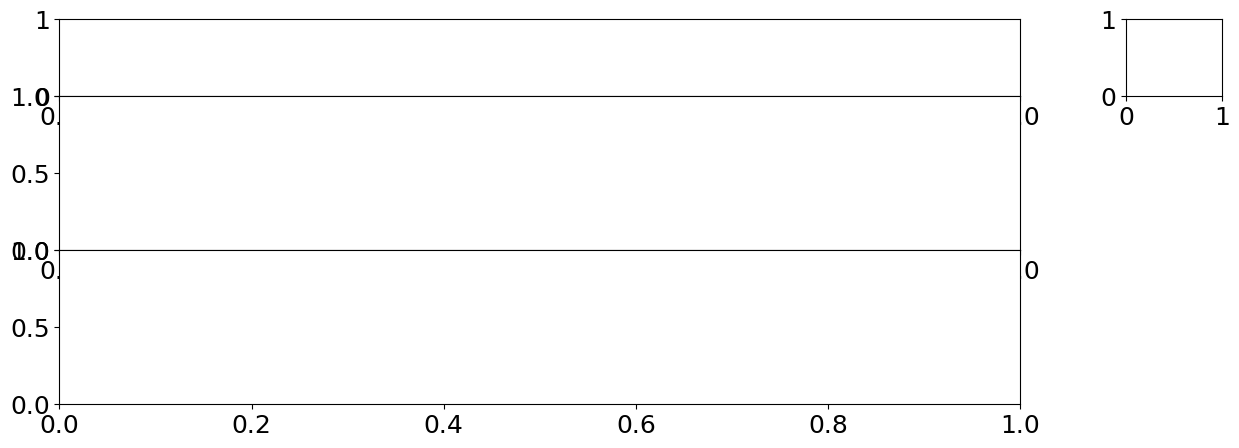

In [ ]:
import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(15,5))
gs = mpl.gridspec.GridSpec(3, 2, height_ratios=[0.5, 1, 1], width_ratios=[1, 0.1])
# Create axes~
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[4])
cax = fig.add_subplot(gs[1])
plt.subplots_adjust(hspace=0)

sol_list_test = sol_list + MD_solenoid_list
mag_field_test = cp.MagneticField()
[mag_field_test.add_solenoid(solenoid) for solenoid in sol_list_test]

p1 = p1_interp(s_array)
p2 = p2_interp(s_array)
p3 = p3_interp(s_array)

[beta_interp1, betaP_interp1], [beta_interp2, betaP_interp2], [beta_interp3, betaP_interp3], B_superposed = calc_beta_betap(mag_field_test, s_array, p1, p2, p3)

I_max = H_current_density

max_S = max(s_array)
max_r = 1

for solenoid in sol_list_test:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=cax, location='left')

# Set plot limits and labels
ax1.set(xlim=(0, max_S), ylim=(-1*max_r, max_r), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax2.plot(s_array, B_superposed)
ax2.set(ylabel=(r'$B$ [T]'), xlim=(0, max_S))

# Plotting the results

ax3.plot(s_array, beta_interp1, c='g', lw=0.5, alpha=0.9, label=r'$\beta \ p_1$')
ax3.plot(s_array, betaP_interp1, c='k', lw=0.5,alpha=0.9, label=r'$\beta^{\prime} \ p_1$')

ax3.plot(s_array, beta_interp3, c='b', lw=0.5, alpha=0.9, label=r'$\beta \ p_3$')
ax3.plot(s_array, betaP_interp3, c='grey', lw=0.5,alpha=0.9, label=r'$\beta^{\prime} \ p_3$')

ax3.set(xlabel='S [m]', ylabel='Value', xlim=(0, max_S))
ax3.legend(bbox_to_anchor=(1.0, 1.0))

#for point in points:
#    ax3.plot(point, 0, 'bo')

ax3.plot(points, np.zeros(len(points)), '.')

ax1.set_axis_off()
cax.set_axis_off()

ax1.set_title(f'Cell {NCELL_MATCH}: Matched Solenoids & B-Fields')
plt.show()

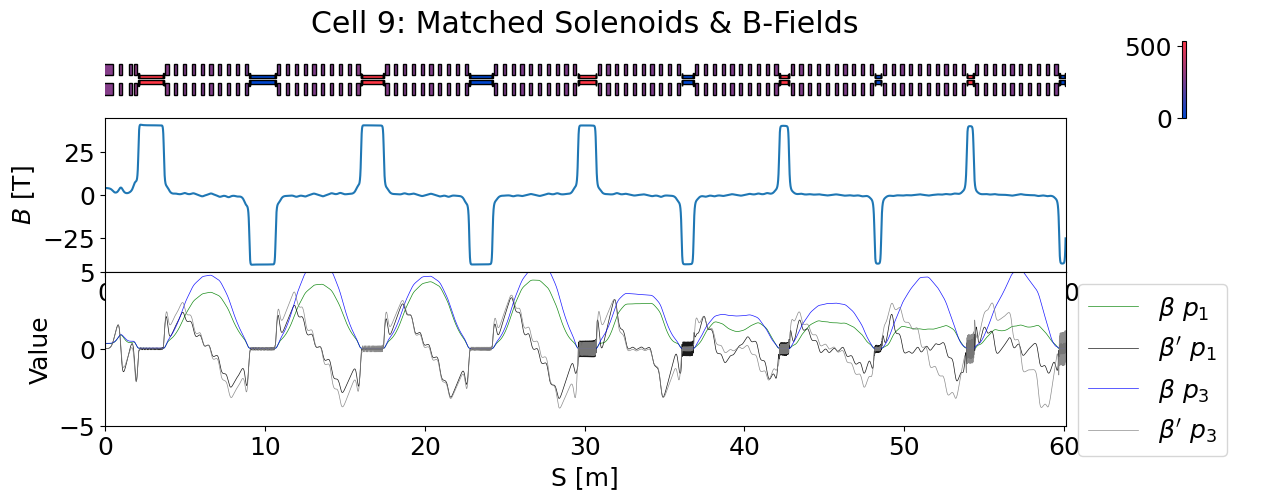

In [432]:
import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(15,5))
gs = mpl.gridspec.GridSpec(3, 2, height_ratios=[0.5, 1, 1], width_ratios=[1, 0.1])
# Create axes~
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[4])
cax = fig.add_subplot(gs[1])
plt.subplots_adjust(hspace=0)

sol_list_test = sol_list + MD_solenoid_list
mag_field_test = cp.MagneticField()
[mag_field_test.add_solenoid(solenoid) for solenoid in sol_list_test]

p1 = p1_interp(s_array)
p2 = p2_interp(s_array)
p3 = p3_interp(s_array)
[beta_interp1, betaP_interp1], [beta_interp2, betaP_interp2], [beta_interp3, betaP_interp3], B_superposed = calc_beta_betap(mag_field_test, s_array, p1, p2, p3)

I_max = H_current_density

max_S = max(s_array)
max_r = 1

for solenoid in sol_list_test:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=cax, location='left')

# Set plot limits and labels
ax1.set(xlim=(0, max_S), ylim=(-1*max_r, max_r), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax2.plot(s_array, B_superposed)
ax2.set(ylabel=(r'$B$ [T]'), xlim=(0, max_S))

# Plotting the results

ax3.plot(s_array, beta_interp1, c='g', lw=0.5, alpha=0.9, label=r'$\beta \ p_1$')
ax3.plot(s_array, betaP_interp1, c='k', lw=0.5,alpha=0.9, label=r'$\beta^{\prime} \ p_1$')

ax3.plot(s_array, beta_interp3, c='b', lw=0.5, alpha=0.9, label=r'$\beta \ p_3$')
ax3.plot(s_array, betaP_interp3, c='grey', lw=0.5,alpha=0.9, label=r'$\beta^{\prime} \ p_3$')

ax3.set(xlabel='S [m]', ylabel='Value', xlim=(0, max_S), ylim=(-5,5))
ax3.legend(bbox_to_anchor=(1.0, 1.0))

#for point in points:
#    ax3.plot(point, 0, 'bo')

ax1.set_axis_off()
cax.set_axis_off()

ax1.set_title(f'Cell {NCELL_MATCH}: Matched Solenoids & B-Fields')
plt.show()

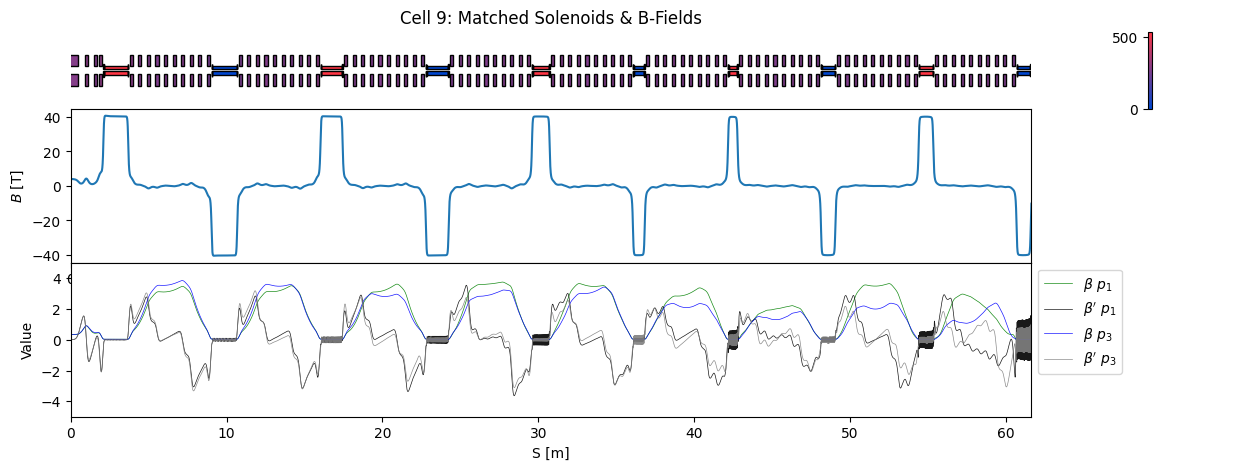

In [609]:
import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(15,5))
gs = mpl.gridspec.GridSpec(3, 2, height_ratios=[0.5, 1, 1], width_ratios=[1, 0.1])
# Create axes~
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[4])
cax = fig.add_subplot(gs[1])
plt.subplots_adjust(hspace=0)

sol_list_test = sol_list + MD_solenoid_list
mag_field_test = cp.MagneticField()
[mag_field_test.add_solenoid(solenoid) for solenoid in sol_list_test]

p1 = p1_interp(s_array)
p2 = p2_interp(s_array)
p3 = p3_interp(s_array)
[beta_interp1, betaP_interp1], [beta_interp2, betaP_interp2], [beta_interp3, betaP_interp3], B_superposed = calc_beta_betap(mag_field_test, s_array, p1, p2, p3)

I_max = H_current_density

max_S = max(s_array)
max_r = 1

for solenoid in sol_list_test:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=cax, location='left')

# Set plot limits and labels
ax1.set(xlim=(0, max_S), ylim=(-1*max_r, max_r), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax2.plot(s_array, B_superposed)
ax2.set(ylabel=(r'$B$ [T]'), xlim=(0, max_S))

# Plotting the results

ax3.plot(s_array, beta_interp1, c='g', lw=0.5, alpha=0.9, label=r'$\beta \ p_1$')
ax3.plot(s_array, betaP_interp1, c='k', lw=0.5,alpha=0.9, label=r'$\beta^{\prime} \ p_1$')

ax3.plot(s_array, beta_interp3, c='b', lw=0.5, alpha=0.9, label=r'$\beta \ p_3$')
ax3.plot(s_array, betaP_interp3, c='grey', lw=0.5,alpha=0.9, label=r'$\beta^{\prime} \ p_3$')

ax3.set(xlabel='S [m]', ylabel='Value', xlim=(0, max_S), ylim=(-5,5))
ax3.legend(bbox_to_anchor=(1.0, 1.0))

#for point in points:
#    ax3.plot(point, 0, 'bo')

ax1.set_axis_off()
cax.set_axis_off()

ax1.set_title(f'Cell {NCELL_MATCH}: Matched Solenoids & B-Fields')
plt.show()

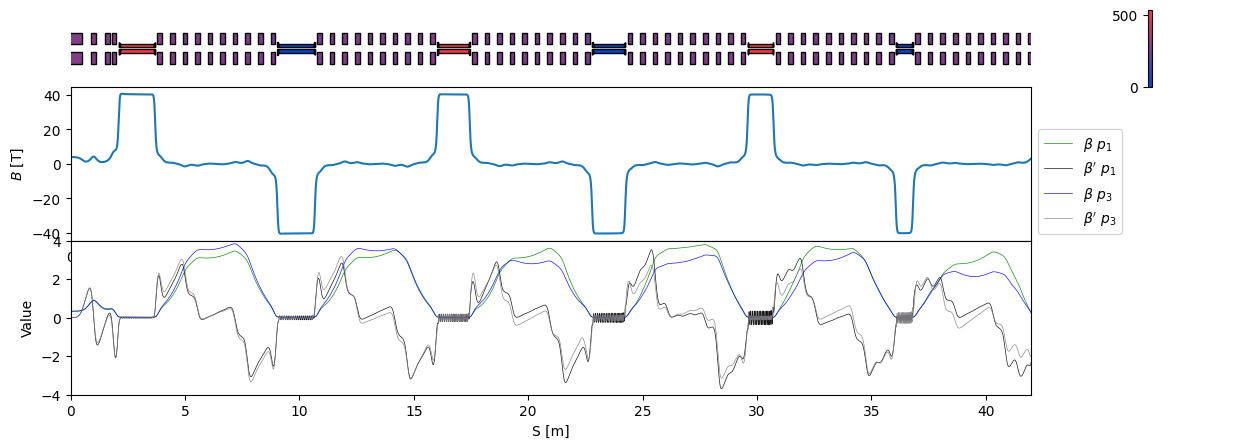

In [554]:
import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(15,5))
gs = mpl.gridspec.GridSpec(3, 2, height_ratios=[0.5, 1, 1], width_ratios=[1, 0.1])
# Create axes~
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[4])
cax = fig.add_subplot(gs[1])
plt.subplots_adjust(hspace=0)

sol_list_test = sol_list + MD_solenoid_list
mag_field_test = cp.MagneticField()
[mag_field_test.add_solenoid(solenoid) for solenoid in sol_list_test]

p1 = p1_interp(s_array)
p2 = p2_interp(s_array)
p3 = p3_interp(s_array)
[beta_interp1, betaP_interp1], [beta_interp2, betaP_interp2], [beta_interp3, betaP_interp3], B_superposed = calc_beta_betap(mag_field_test, s_array, p1, p2, p3)

I_max = H_current_density

max_S = max(s_array)
max_r = 1

for solenoid in sol_list_test:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=cax, location='left')

# Set plot limits and labels
ax1.set(xlim=(0,42), ylim=(-1*max_r, max_r), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax2.plot(s_array, B_superposed)
ax2.set(ylabel=(r'$B$ [T]'), xlim=(0,42))

# Plotting the results

ax3.plot(s_array, beta_interp1, c='g', lw=0.5, alpha=0.9, label=r'$\beta \ p_1$')
ax3.plot(s_array, betaP_interp1, c='k', lw=0.5,alpha=0.9, label=r'$\beta^{\prime} \ p_1$')

ax3.plot(s_array, beta_interp3, c='b', lw=0.5, alpha=0.9, label=r'$\beta \ p_3$')
ax3.plot(s_array, betaP_interp3, c='grey', lw=0.5,alpha=0.9, label=r'$\beta^{\prime} \ p_3$')

ax3.set(xlabel='S [m]', ylabel='Value', xlim=(0,42), ylim=(-4,4))
ax3.legend(bbox_to_anchor=(1.0, 1.0))

#for point in points:
#    ax3.plot(point, 0, 'bo')

ax1.set_axis_off()
cax.set_axis_off()

In [ ]:
MD_solenoid_list
mag_field_test = cp.MagneticField()
[mag_field_test.add_solenoid(solenoid) for solenoid in sol_list_test]

p1 = p1_interp(s_array)
p2 = p2_interp(s_array)
p3 = p3_interp(s_array)
[beta_interp1, betaP_interp1], [beta_interp2, betaP_interp2], [beta_interp3, betaP_interp3], B_superposed = calc_beta_betap(mag_field_test, s_array, p1, p2, p3)

I_max = H_current_density

max_S = max(s_array)
max_r = 1

for solenoid in sol_list_test:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=cax, location='left')

# Set plot limits and labels
ax1.set(xlim=(0, max_S), ylim=(-1*max_r, max_r), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax2.plot(s_array, B_superposed)
ax2.set(ylabel=(r'$B$ [T]'), xlim=(0, max_S))

# Plotting the results

ax3.plot(s_array, beta_interp1, c='g', lw=0.5, alpha=0.9, label=r'$\beta \ p_1$')
ax3.plot(s_array, betaP_interp1, c='k', lw=0.5,alpha=0.9, label=r'$\beta^{\prime} \ p_1$')

ax3.plot(s_array, beta_interp3, c='b', lw=0.5, alpha=0.9, label=r'$\beta \ p_3$')
ax3.plot(s_array, betaP_interp3, c='grey', lw=0.5,alpha=0.9, label=r'$\beta^{\prime} \ p_3$')

ax3.set(xlabel='S [m]', ylabel='Value', xlim=(0, max_S), ylim=(-5,5))
ax3.legend(bbox_to_anchor=(1.0, 1.0))

#for point in points:
#    ax3.plot(point, 0, 'bo')

ax1.set_axis_off()
cax.set_axis_off()

ax1.set_title(f'Cell {NCELL_MATCH}: Matched Solenoids & B-Fields')
plt.show()

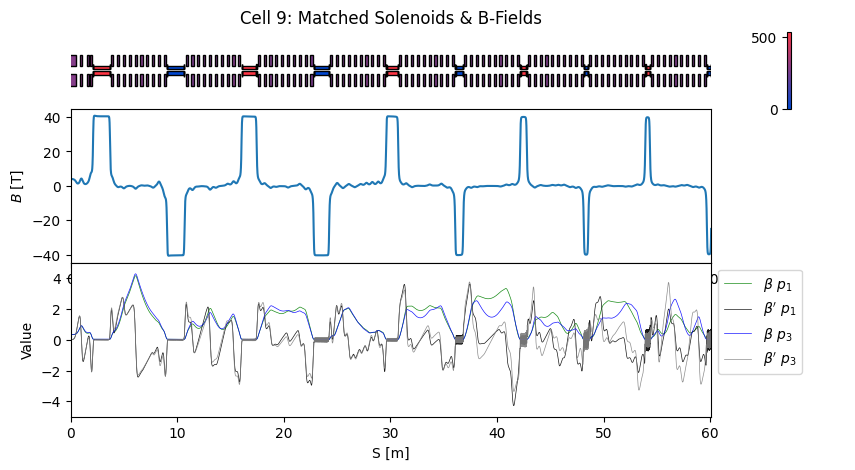

In [446]:
import matplotlib as mpl
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(10,5))
gs = mpl.gridspec.GridSpec(3, 2, height_ratios=[0.5, 1, 1], width_ratios=[1, 0.1])
# Create axes~
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[2])
ax3 = fig.add_subplot(gs[4])
cax = fig.add_subplot(gs[1])
plt.subplots_adjust(hspace=0)

ncell_match = NCELL_MATCH

sol_list_test = sol_list + MD_solenoid_list
mag_field_test = cp.MagneticField()
[mag_field_test.add_solenoid(solenoid) for solenoid in sol_list_test]

p1 = p1_interp(s_array)
p2 = p2_interp(s_array)
p3 = p3_interp(s_array)
[beta_interp1, betaP_interp1], [beta_interp2, betaP_interp2], [beta_interp3, betaP_interp3], B_superposed = calc_beta_betap(mag_field_test, s_array, p1, p2, p3)

I_max = H_current_density

max_S = max(s_array)
max_r = 1

for solenoid in sol_list_test:
    rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
    ax1.add_patch(rect_outer)
    ax1.add_patch(rect_inner)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap_r, norm=mcolors.Normalize(vmin=0, vmax=I_max))
sm.set_array([])
cbar = plt.colorbar(sm, ax=cax, location='left')

# Set plot limits and labels
ax1.set(xlim=(0, max_S), ylim=(-1*max_r, max_r), xlabel=(r'$s$ [m]'), ylabel=(r'$R$ [m]'))

ax2.plot(s_array, B_superposed)
ax2.set(ylabel=(r'$B$ [T]'), xlim=(0, max_S))

# Plotting the results

ax3.plot(s_array, beta_interp1, c='g', lw=0.5, alpha=0.9, label=r'$\beta \ p_1$')
ax3.plot(s_array, betaP_interp1, c='k', lw=0.5,alpha=0.9, label=r'$\beta^{\prime} \ p_1$')

ax3.plot(s_array, beta_interp3, c='b', lw=0.5, alpha=0.9, label=r'$\beta \ p_3$')
ax3.plot(s_array, betaP_interp3, c='grey', lw=0.5,alpha=0.9, label=r'$\beta^{\prime} \ p_3$')

ax3.set(xlabel='S [m]', ylabel='Value', xlim=(0, max_S), ylim=(-5,5))
ax3.legend(bbox_to_anchor=(1.0, 1.0))

#for point in points:
#    ax3.plot(point, 0, 'bo')

ax1.set_axis_off()
cax.set_axis_off()

ax1.set_title(f'Cell {ncell_match}: Matched Solenoids & B-Fields')
plt.show()

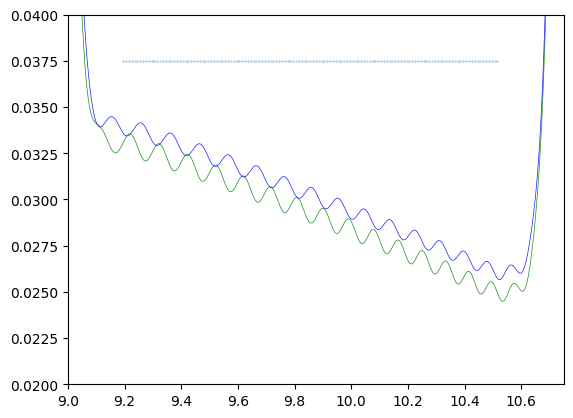

In [191]:
plt.plot(s_array, beta_interp1, c='g', lw=0.5, alpha=0.9, label=r'$\beta \ p_1$')
plt.plot(s_array, beta_interp3, c='b', lw=0.5, alpha=0.9, label=r'$\beta \ p_3$')
plt.xlim(9,10.75)
plt.ylim(0.02, 0.04)

points = np.arange(H_solenoid_list[1].position-AbsorberLengths[1]/2, H_solenoid_list[1].position+AbsorberLengths[1]/2, 0.01)
plt.plot(points, 0.0375*np.ones(len(points)), '.', markersize=0.5)

#### Gif Creation

In [110]:
def create_gif(gifname):
    m_mu = 0.105658375
    
    coord_arr = ['X [mm]', 'PX [MeV]', 'Y [mm]', 'PY [MeV]', 't [mm/c]', 'E [GeV]']
    index_arr = [1,2,3,4,5,6]
    axes_indices = [[0,1], [0,3], [0,2], [2,1], [2,3], [4,5]]
    coord_indices = [['X', 'Px'], ['X','Py'], ['X','Y'], ['Y','Px'], ['Y','Py'], ['T','Pz']]
    Zunique = sol_df.Z.unique()

    std = 10
    maxes = [sol_df.X.mean()+std*sol_df.X.std(), sol_df.Px.mean()+std*sol_df.Px.std(), sol_df.Y.mean()+std*sol_df.Y.std(), sol_df.Py.mean()+std*sol_df.Py.std()]
    mins =  [sol_df.X.mean()-std*sol_df.X.std(), sol_df.Px.mean()-std*sol_df.Px.std(), sol_df.Y.mean()-std*sol_df.Y.std(), sol_df.Py.mean()-std*sol_df.Py.std()]

    with imageio.get_writer(f"{os.getcwd()}/gifs/{gifname}.gif", mode='I') as writer:
        for z, Z in enumerate(Zunique):
            print(Z, '/', sol_df.Z.max())

            beam = sol_df[sol_df.Z == Z]
            X, PX, Y, PY, T, PZ = beam['X'], beam['Px'], beam['Y'], beam['Py'], 1E9*beam['T'], beam['Pz']
            E = (PZ*PZ + PY*PY + PX*PX + m_mu*m_mu)**0.5
            data = np.stack([X, PX, Y, PY, T, E])
            means = np.mean(data, axis=1)
            stds = np.std(data, axis=1)
            # Identify high amplitude particles (above 5 sigma)
            sigma = 5
            filtered_indices = np.all(np.abs(data - means[:, np.newaxis]) < sigma * stds[:, np.newaxis], axis=0)
            # Filter the data
            filtered_data = data[:, filtered_indices]

            fig = plt.figure(figsize=(13.5, 5.75))
            outer = fig.add_gridspec(2, 1, height_ratios=[0.5, 2], hspace=0, wspace=0.425)
            gs_top = outer[0].subgridspec(1, 4, width_ratios=[2.5, 1, 1, 1], wspace=0.425, hspace=0.3)
            gs_bot = outer[1].subgridspec(2, 4, width_ratios=[2.5, 1, 1, 1], wspace=0.425, hspace=0.3)

            # axes (same names, same positions)
            ax0 = fig.add_subplot(gs_top[0, 0])

            ax1 = fig.add_subplot(gs_bot[0, 0])
            ax2 = fig.add_subplot(gs_bot[1, 0])

            ax3 = fig.add_subplot(gs_bot[0, 1])
            ax4 = fig.add_subplot(gs_bot[0, 2])
            ax5 = fig.add_subplot(gs_bot[0, 3])

            ax6 = fig.add_subplot(gs_bot[1, 1])
            ax7 = fig.add_subplot(gs_bot[1, 2])
            ax8 = fig.add_subplot(gs_bot[1, 3])
            
            axes=[ax3,ax4,ax5,ax6,ax7,ax8]

            for i, ax in enumerate(axes):
                ax.set_xlabel(coord_arr[axes_indices[i][0]]), ax.set_ylabel(coord_arr[axes_indices[i][1]])

                scatter = ax.scatter(filtered_data[axes_indices[i][0],:], filtered_data[axes_indices[i][1],:], s=2, c=filtered_data[5], cmap=cmap)
                if i < 5:
                    ax.set(xlim=(mins[axes_indices[i][0]], maxes[axes_indices[i][0]]),
                        ylim=(mins[axes_indices[i][1]], maxes[axes_indices[i][1]]))
                    
            ax1.set_ylabel(r'$\varepsilon_\perp [$ mm]'), ax2.set_ylabel(r'$\varepsilon_\parallel [$ mm]')
            ax2.set_xlabel('S [m]')
            # Remove ticks, labels, and frame from ax10
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            ax3.set_title(f'Position {Z} m')

            ax1.plot(Zunique[:z], np.array(emitT_arr)[:z]*1E6, color='#0046d0')
            ax2.plot(Zunique[:z], np.array(emitL_arr)[:z]*1E3, color='#0046d0')
            ax1.set(xlim=(min(Zunique), max(Zunique)), ylim=(min(np.array(emitT_arr)*1E6), 300), xlabel='S [m]', ylabel=r'$\varepsilon_\perp [$ mm]')
            ax2.set(xlim=(min(Zunique), max(Zunique)), ylim=(min(np.array(emitL_arr)*1E3), 90), xlabel='S [m]', ylabel=r'$\varepsilon_\parallel [$ mm]')

            #Construct beamline
            sol_list = [L1, L2] + MU1_list + MU2_list + MD_solenoid_list + H_solenoid_list + HcorrU_solenoid_list + HcorrD_solenoid_list
            I_max = H_current_density

            for solenoid in sol_list:
                rect_outer, rect_inner = plot_solenoid(solenoid, I_max, cmap=cmap_r)
                ax0.add_patch(rect_outer)
                ax0.add_patch(rect_inner)
            

            ax0.set(xlim=(0, L2.position), ylim=(-0.5, 0.5))
            ax0.set_axis_off()

            plt.savefig(f"{os.getcwd()}/gifs/screens_{Z}.png")
            #plt.close(fig)
            image = imageio.imread(f"{os.getcwd()}/gifs/screens_{Z}.png")
            writer.append_data(image)
            os.remove(f"{os.getcwd()}/gifs/screens_{Z}.png")

In [111]:
import imageio.v2 as imageio
import os


In [ ]:
create_gif('10Cell_Ver0.3')

In [78]:
beam_dist_ideal['t']

0       0.000554
1      -0.000116
2       0.002067
3       0.004106
4       0.001436
          ...   
9995    0.000281
9996    0.003327
9997   -0.001791
9998   -0.002080
9999   -0.001419
Name: t, Length: 10000, dtype: float64

In [75]:
beam_dist['T']

1147703    3.108930e-07
1147704    3.146230e-07
1147705    3.073290e-07
1147706    2.991820e-07
1147707    3.224600e-07
               ...     
1148475    3.237140e-07
1148476    3.254220e-07
1148477    3.108900e-07
1148478    3.364440e-07
1148479    3.023750e-07
Name: T, Length: 777, dtype: float64

Comparisons to ideal scenario

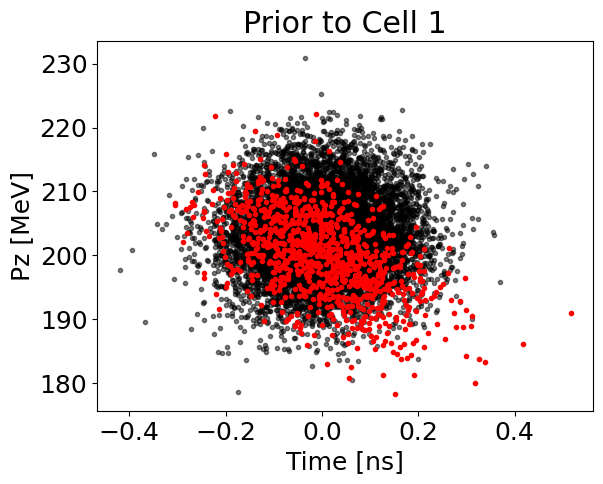

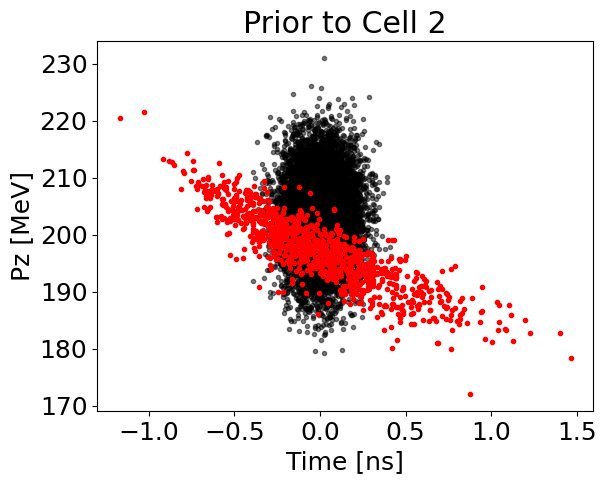

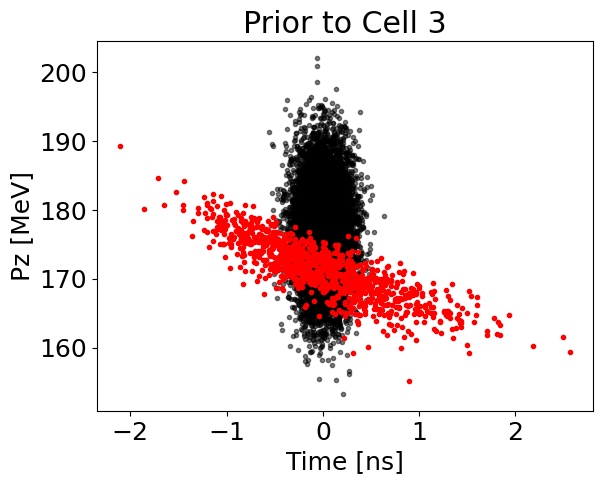

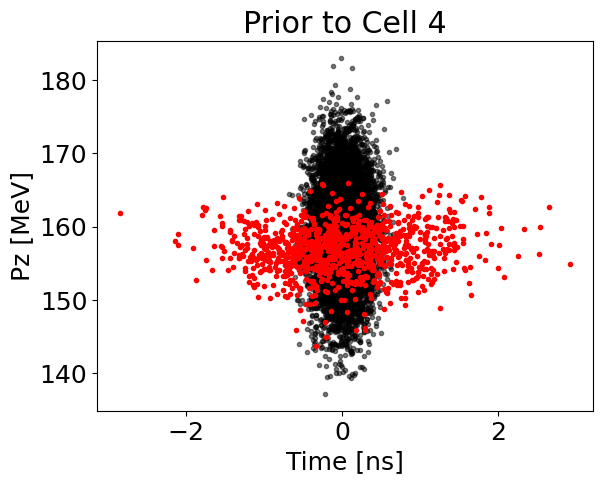

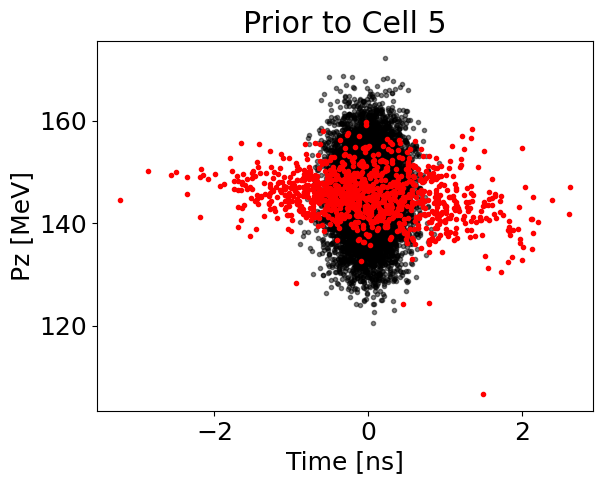

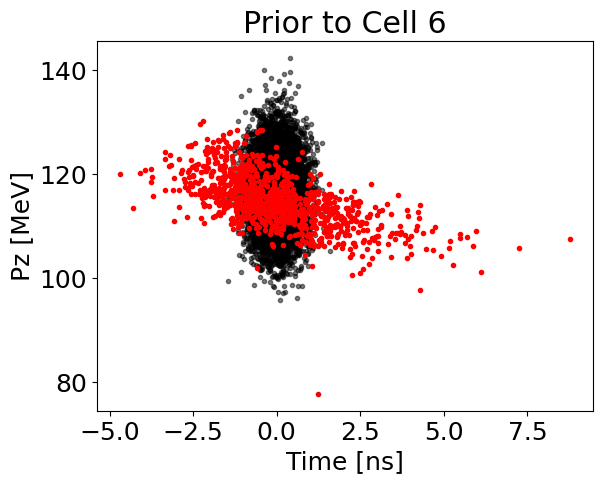

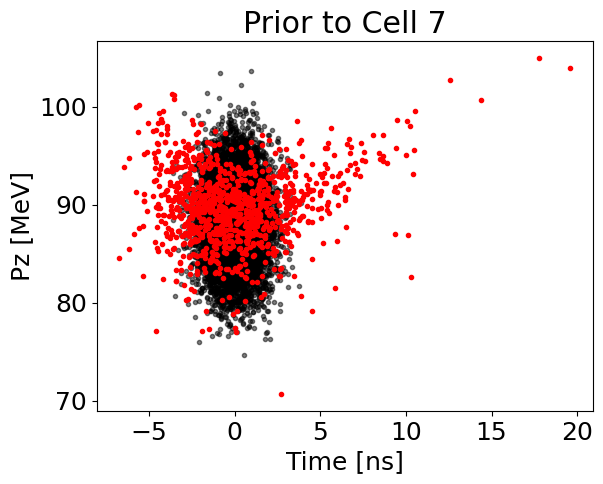

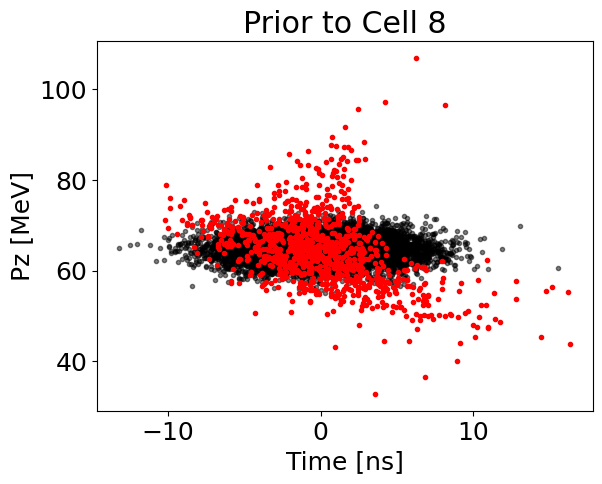

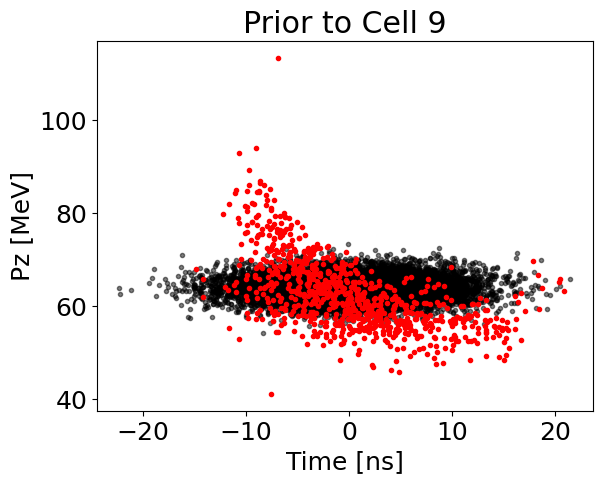

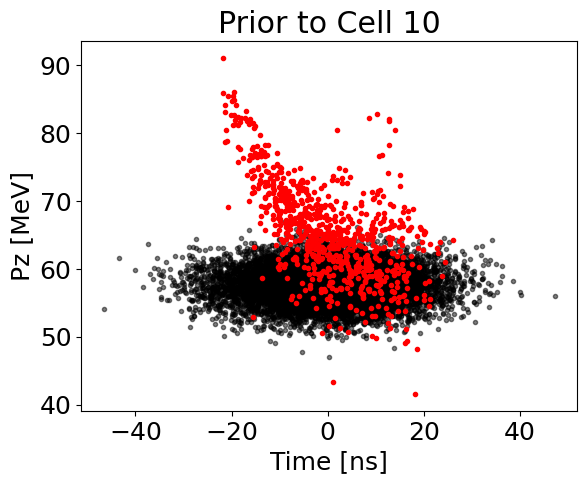

In [103]:
def CellBeamGen(N, norm_emi_T, norm_emi_L, Eref, sigE, Bfield=40):
    #cellno, norm_emi_T [m], norm_emi_L [m], Eref [MeV], sigE [MeV], Bfield [T]
    c= cp.c #[m/s]
    m_mu = cp.m_mu * 1e-9 #GeV
    Pref = P(Eref*1E6)*1E-9
    
    beta = Pref / np.sqrt(Pref*Pref + m_mu*m_mu) #Unitless
    sigPZ = sigE / beta  #Momentum spread [MeV]
    Bz = Bfield #4.629 # low field at the beginning in [T]
    #Bz = 4.056486333380374
    
    #in GeV
    p = Pref
    beta0 = p*2/(0.29979258*Bz)
    kappa = (0.29979258*Bz) / (2 * p )
    alpha = 0.
    gamma = (1 + alpha**2) / beta0
    
    Lcan = 0. #canonical angular momentum at the start
    
    sigPX = np.sqrt(p*norm_emi_T*m_mu/(beta0)) * np.sqrt(2) #std of px in GeV/c
    sigX = np.sqrt(norm_emi_T*beta0*m_mu/p)# std of x in m
    
    xpx = -m_mu*norm_emi_T*alpha
    #angular kicks
    xpy = - m_mu * norm_emi_T* (beta0 * kappa - Lcan)
    ypx =  m_mu * norm_emi_T* (beta0 * kappa - Lcan)
    X0, Y0 = sigX , sigX #sigma_x/sigma_y in m
    XP0, YP0, PZ0 = sigPX , sigPX, sigPZ    #sigma_px/sigma_py in rad
    
    XPY0 = xpy
    YPX0 = ypx
    
    XPX0 = 0
    YPY0 = 0
    
    norm_emi_L_eV = norm_emi_L / c * cp.m_mu
    sigT = norm_emi_L_eV / (sigE * 1e6) #sigma t in [s]
    T0 = sigT * 1e9 #sigma t in [ns]

    mean = np.array([0, 0, 0, 0, 0, Pref*1e3])
    cov_matrix = np.array([[X0**2, XPX0  , 0.   , XPY0  , 0, 0     ],
                          [XPX0  , XP0**2, YPX0 , 0.    , 0, 0     ],
                          [0.    , YPX0  , Y0**2, YPY0  , 0, 0     ],
                          [XPY0  , 0.    , YPY0 , YP0**2, 0, 0     ],
                          [0.    , 0.    , 0.   , 0.    , T0**2, 0     ],
                          [0.    , 0.    , 0.   , 0.    , 0, PZ0**2]])
    
    
    macro = np.random.multivariate_normal(mean, cov_matrix, N)
    
    x = macro[:,0] * 1e3 #in mm
    y = macro[:,2] * 1e3 #in mm
    px = macro[:,1] * 1e3 #in MeV
    py = macro[:,3] * 1e3 #in MeV
    z = 0
    t = macro[:,4] #in ns
    pz = macro[:,5] #in MeV

        
    def dpsi_n1_inv(dpsi_n0, dW_n0, W_kin, w_RF, L):
        W = W_kin + cp.m_mu
        beta = np.sqrt(1 - (cp.m_mu*cp.m_mu)/(W*W))
        gamma = W/cp.m_mu
        return dpsi_n0 + w_RF * dW_n0 * L / (cp.m_mu*c * (beta*gamma)**3)
    
    ts = t*1e-9 #time in [s]
    W_kin = ((Pref*Pref + m_mu*m_mu)**0.5 - m_mu) * 1e9 #Ekin in [eV]
    p = (px**2 + py**2 + pz**2)**0.5 * 1e-3 #p total in [GeV]
    dW = (p**2 + m_mu**2)**0.5 * 1e9 #E total in [eV]
    w_RF = 200 * 1e6 #random frequency
    dpsi = ts * w_RF
    
    #Focal length
    L_focal = 0
    ts0 = dpsi_n1_inv(dpsi, dW, W_kin, w_RF, L_focal) / w_RF
    ts0 =  ts0 - np.mean(ts0 )
    t = ts0 * 1e9

    print(np.std(t))

In [104]:
for i in range(0,9):
    CellBeamGen(1000, EmitT_Target[i]*1E6, EmitL_Target[i]*1E3, Energies[i+1], EnergySpreads[i+1])

113.80551330412924
153.37326473585625
197.07473089490742
247.17652497713627
420.92209139439353
1001.4600238483382
3137.700840190133
5839.009508563576
11071.355968267748


In [ ]:
CellBeamGen(EmitL_Target[0]*1E3, Energies[0], EnergySpreads[0])

0.12255551873813092


In [86]:
EmitL_Target[0]*1E3

np.float64(1.8836404178010724)

In [87]:
Energies[0]

123.4874061